## Hyperspectral Image Segmentation by Convolutional Neural Network 

### standardized spectra at full resolution with spatial dimension included

---

In [1]:
# -- here are functions that generate a class that memory maps the raw data 
#    cube.  After executing this cell, the syntax is:
#    fname = "[path to data]/foo.raw"
#    cube = read_hyper(fname)

import os
import numpy as np

def read_header(hdrfile, verbose=True):
    """
    Read a Middleton header file.

    Parameters
    ----------
    hdrfile : str
        Name of header file.
    verbose : bool, optional
        If True, alert the user.

    Returns
    -------
    dict : dict
        A dictionary continaing the number of rows, columns, and wavelengths
        as well as an array of band centers.
    """

    # -- alert
    if verbose:
        print("reading and parsing {0}...".format(hdrfile))

    # -- open the file and read in the records
    recs = [rec for rec in open(hdrfile)]

    # -- parse for samples, lines, bands, and the start of the wavelengths
    for irec, rec in enumerate(recs):
        if 'samples' in rec:
            samples = int(rec.split("=")[1])
        elif 'lines' in rec:
            lines = int(rec.split("=")[1])
        elif 'bands' in rec:
            bands = int(rec.split("=")[1])
        elif "Wavelength" in rec:
            w0ind = irec+1

    # -- parse for the wavelengths
    waves = np.array([float(rec.split(",")[0]) for rec in 
                      recs[w0ind:w0ind+bands]])

    # -- return a dictionary
    return {"nrow":samples, "ncol":lines, "nwav":bands, "waves":waves}


def read_raw(rawfile, shape, hyper=False, verbose=True):
    """
    Read a Middleton raw file.

    Parameters
    ----------
    rawfile : str
        The name of the raw file.
    shape : tuple
        The output shape of the data cube (nwav, nrow, ncol).
    hyper : bool, optional
        Set this flag to read a hyperspectral image.
    verbose : bool, optional
        Alert the user.

    Returns
    -------
    memmap : memmap
        A numpy memmap of the datacube.
    """

    # -- alert
    if verbose:
        print("reading {0}...".format(rawfile))

    # -- read either broadband or hyperspectral image
    if hyper:
        return np.memmap(rawfile, np.uint16, mode="r") \
            .reshape(shape[2], shape[0], shape[1])[:, :, ::-1] \
            .transpose(1, 2, 0)
    else:
        return np.memmap(rawfile, np.uint8, mode="r") \
            .reshape(shape[1], shape[2], shape[0])[:, :, ::-1]


def read_hyper(fpath, fname=None, full=True):
    """
    Read a full hyperspectral scan (raw and header file).

    Parameters
    ----------
    fpath : str
        Either the full name+path of the raw file or the path of the raw file.
        If the latter, fname must be supplied.
    fname : str, optional
        The name of the raw file (required if fpath is set to a path).
    full : bool, optional
        If True, output a class containing data and supplementary information.
        If False, output only the data.

    Returns
    -------
    output or memmap : class or memmap
        If full is True, a class containing data plus supplementary 
        information.  If full is False, a memmap array of the data.
    """

    # -- set up the file names
    if fname is not None:
        fpath = os.path.join(fpath, fname)

    # -- read the header
    hdr = read_header(fpath.replace("raw", "hdr"))
    sh  = (hdr["nwav"], hdr["nrow"], hdr["ncol"])

    # -- if desired, only output data cube
    if not full:
        return read_raw(fpath, sh, hyper=True)

    # -- output full structure
    class output():
        def __init__(self, fpath):
            self.filename = fpath
            self.data     = read_raw(fpath, sh, hyper=True)
            self.waves    = hdr["waves"]
            self.nwav     = sh[0]
            self.nrow     = sh[1]
            self.ncol     = sh[2]

    return output(fpath)

In [2]:
def kmeans_test_dictionary(labels, test, k):
    import collections, numpy
    
    unique_test, counts_test = numpy.unique(labels[test[:,0], test[:,1]], return_counts=True)
    counts_test_norm = (counts_test/test.shape[0])*100
    test_dict = dict(zip(unique_test, counts_test))
    test_dict_norm = dict(zip(unique_test, counts_test_norm))
    
    for i in range(0, k):
        if test_dict.get(i) is None: test_dict[i] = 0
        if test_dict_norm.get(i) is None: test_dict_norm[i] = 0
    
    return test_dict, test_dict_norm

In [3]:
def kmeans_test_dataframe(sky_dict,
                          clouds_dict,
                          veg_dict,
                          wtr_dict,
                          blt_dict,
                          windows_dict,
                          rds_dict,
                          cars_dict,
                          mtl_dict
                         ):
    import pandas as pd
    
    pixel_names = ['sky', 'clouds', 'vegetation', 'water', 'built',
                  'windows', 'roads', 'cars', 'metal']
    df_test = pd.DataFrame([sky_dict,
                            clouds_dict,
                            veg_dict,
                            wtr_dict,
                            blt_dict,
                            windows_dict,
                            rds_dict,
                            cars_dict,
                            mtl_dict], index=pixel_names)
    df_test = df_test.transpose()
    
    return df_test

In [4]:
def plot_confusion_matrix(df_test, norm=True):
    import numpy as np
    import matplotlib.pyplot as plt
    %matplotlib inline
    
    cm = np.array([df_test['sky'].values,
                   df_test['clouds'].values,
                   df_test['vegetation'].values,
                   df_test['water'].values,
                   df_test['built'].values,
                   df_test['windows'].values,
                   df_test['roads'].values,
                   df_test['cars'].values,
                   df_test['metal'].values])
    classes = ['sky', 'clouds', 'vegetation', 'water', 'built', 'windows', 'roads', 
              'cars', 'metal']
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    if norm:
        title='Normalized Confusion Matrix'
        fmt='.2f'
    else:
        title='Confusion Matrix'
        fmt='d'
    ax.set(xticks=np.arange(cm.shape[1]),
          yticks=np.arange(cm.shape[0]),
          xticklabels=np.arange(0,cm.shape[1]).astype(str), 
          yticklabels=classes,
          title=title,
          ylabel='True Label',
          xlabel='Predicted Label')
    #plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
    #        rotation_mode="anchor")
    thresh = cm.max()/2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i,j], fmt),
                   ha="center", va="center",
                   color="white" if cm[i,j] > thresh else "black")
    fig.tight_layout()
    plt.show()

In [5]:
def plot_test_result(df_Test):
    import matplotlib.pyplot as plt
    %matplotlib inline
    
    df_test = df_Test.transpose()
    ax = df_test.plot.bar(rot=0, stacked=True, colormap='tab20b')
                          #color=['tab:blue', 'tab:green', 'tab:gray'])
    plt.xlabel('Actual Class')
    plt.ylabel('%of Test Pixels')
    plt.title('Error in Prediction')
    plt.legend(bbox_to_anchor=(1,1), loc=2, borderaxespad=1.0, prop={'size':11})
    plt.show()

In [6]:
def point_from_string(text):
    
    items = text.strip("\n").split(" ")
    rind = int(items[0])
    cind = int(items[1])
    
    return rind, cind

In [7]:
def coords(row, col):
    return np.array(list(np.ndindex((row, col)))).reshape(row, col, 2)

---
### Classes:
1. Sky
2. Clouds
3. Water
4. Vegetation
5. Buildings (concrete structures)
6. Windows
7. Roads
8. Cars
9. Metal Structures
---


## CNN on veg_00108 (South Facing @ ~2pm)

In [8]:
fname = "../../image_files/veg_00108.raw"
cube = read_hyper(fname)

reading and parsing ../../image_files/veg_00108.hdr...
reading ../../image_files/veg_00108.raw...


In [9]:
cube_sub = cube.data[:, :, :].astype(float)
print(cube_sub.shape)

(848, 1600, 1600)


In [10]:
cube_reshaped = cube_sub.transpose(1, 2, 0).reshape((cube_sub.shape[1] * cube_sub.shape[2]), cube_sub.shape[0])
print(cube_reshaped.shape)

(2560000, 848)


In [11]:
cube_standard = (cube_reshaped - cube_reshaped.mean(1, keepdims=True)) / cube_reshaped.std(1, keepdims=True)

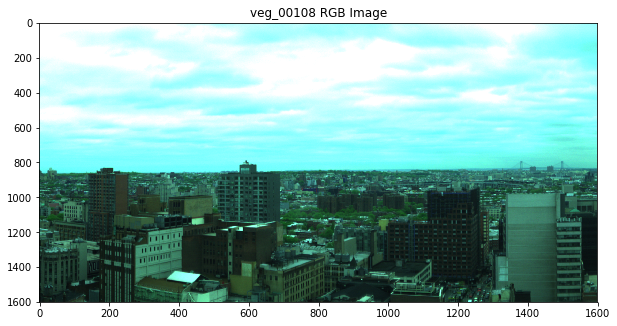

In [12]:
cube_norm = (cube_reshaped - cube_reshaped.min()) / (cube_reshaped.max() - cube_reshaped.min())

import matplotlib.pyplot as plt
%matplotlib inline

red_ind = (np.abs(cube.waves - 650.0)).argmin()
green_ind = (np.abs(cube.waves - 550.0)).argmin()
blue_ind = (np.abs(cube.waves - 450.0)).argmin()

cube_reshaped2 = cube_norm.reshape(cube_sub.shape[1], cube_sub.shape[2], cube_sub.shape[0])
cube_scene = cube_reshaped2[:, :, [red_ind, green_ind, blue_ind]]
fig, ax = plt.subplots(figsize=(10,10))
plt.title('veg_00108 RGB Image')
ax.imshow(cube_scene, aspect=0.5)
plt.show()

In [ ]:
#plt.imsave("./plots/scene_RGB_00108.png", cube_scene, format='png')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


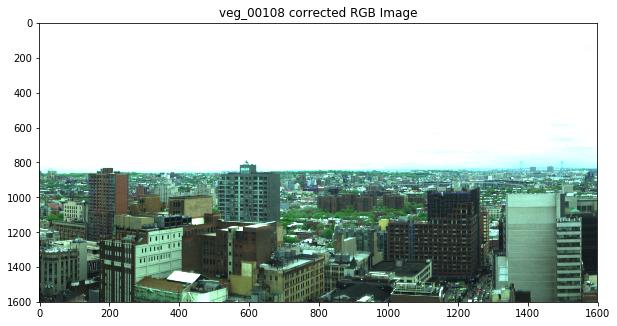

In [13]:
rgb = cube_reshaped2[:, :, [red_ind, green_ind, blue_ind]].copy()
rgb /= rgb.mean((0, 1), keepdims=True)

fig, ax = plt.subplots(figsize=(10,10))
plt.title('veg_00108 corrected RGB Image')
ax.imshow(rgb, aspect=0.5)
plt.show()

In [ ]:
#plt.imsave("./plots/scene_RGB_corrected_00108.png", rgb, format='png')

In [14]:
# create position array and normalize

xycoords = coords(cube_sub.shape[1], cube_sub.shape[2])
xycoords = xycoords/xycoords.max()

In [15]:
# append row, col position matrix to spectral data

cube_temp = cube_standard.reshape(cube_sub.shape[1], cube_sub.shape[2], cube_sub.shape[0])
cube_specxy = np.append(cube_temp, xycoords, axis=2)

In [16]:
# reshape spectral and spatial cube for clustering
cube_specxy_2d = cube_specxy.reshape((cube_specxy.shape[0] * cube_specxy.shape[1]), cube_specxy.shape[2])
print(cube_specxy_2d.shape)

(2560000, 850)


#### Reading manually classified set for training and testing

In [17]:
# read manually selected coordinates files

#sky coordinates
sky_file = open("../manual_classified_pixels/1_sky_coordinates_108.txt", "r")
sky_coords = sky_file.readlines()
sky_file.close()
sky_coords = np.array([point_from_string(line) for line in sky_coords])
print("sky:        ", sky_coords.shape)

#clouds coordinates
clouds_file = open("../manual_classified_pixels/2_clouds_coordinates_108.txt", "r")
clouds_coords = clouds_file.readlines()
clouds_file.close()
clouds_coords = np.array([point_from_string(line) for line in clouds_coords])
print("clouds:     ", clouds_coords.shape)

#vegetation coordinates
veg_file = open("../manual_classified_pixels/3_vegetation_coordinates_108.txt", "r")
veg_coords = veg_file.readlines()
veg_file.close()
veg_coords = np.array([point_from_string(line) for line in veg_coords])
print("vegetation: ", veg_coords.shape)

#water coordinates
wtr_file = open("../manual_classified_pixels/4_water_coordinates_108.txt", "r")
wtr_coords = wtr_file.readlines()
wtr_file.close()
wtr_coords = np.array([point_from_string(line) for line in wtr_coords])
print("water:      ", wtr_coords.shape)

#buildings coordinates
blt_file = open("../manual_classified_pixels/5_buildings_coordinates_108.txt", "r")
blt_coords = blt_file.readlines()
blt_file.close()
blt_coords = np.array([point_from_string(line) for line in blt_coords])
print("buildings:  ", blt_coords.shape)

#windows coordinates
windows_file = open("../manual_classified_pixels/6_windows_coordinates_108.txt", "r")
windows_coords = windows_file.readlines()
windows_file.close()
windows_coords = np.array([point_from_string(line) for line in windows_coords])
print("windows:    ", windows_coords.shape)

#roads coordinates
rds_file = open("../manual_classified_pixels/7_roads_coordinates_108.txt", "r")
rds_coords = rds_file.readlines()
rds_file.close()
rds_coords = np.array([point_from_string(line) for line in rds_coords])
print("road:       ", rds_coords.shape)

#cars coordinates
cars_file = open("../manual_classified_pixels/8_cars_coordinates_108.txt", "r")
cars_coords = cars_file.readlines()
cars_file.close()
cars_coords = np.array([point_from_string(line) for line in cars_coords])
print("cars:       ", cars_coords.shape)

#metal coordinates
mtl_file = open("../manual_classified_pixels/9_metal_coordinates_108.txt", "r")
mtl_coords = mtl_file.readlines()
mtl_file.close()
mtl_coords = np.array([point_from_string(line) for line in mtl_coords])
print("metal:      ", mtl_coords.shape)

sky:         (300, 2)
clouds:      (500, 2)
vegetation:  (600, 2)
water:       (50, 2)
buildings:   (1020, 2)
windows:     (500, 2)
road:        (30, 2)
cars:        (100, 2)
metal:       (100, 2)


## Split classified pixels into 80% training and 20% testing sets

In [18]:
train_ratio = 0.8

import random

# sky coordinates
sky_ind = np.arange(sky_coords.shape[0])
random.Random(3).shuffle(sky_ind)
lim_ind = int(len(sky_ind)*train_ratio)
sky_train_ind = sky_ind[:lim_ind]
sky_test_ind = sky_ind[lim_ind:]
print("sky %d %d" % (len(sky_train_ind), len(sky_test_ind)))

# clouds coordinates
clouds_ind = np.arange(clouds_coords.shape[0])
random.Random(3).shuffle(clouds_ind)
lim_ind = int(len(clouds_ind)*train_ratio)
clouds_train_ind = clouds_ind[:lim_ind]
clouds_test_ind = clouds_ind[lim_ind:]
print("clouds %d %d" % (len(clouds_train_ind), len(clouds_test_ind)))

# vegetation coordinates
veg_ind = np.arange(veg_coords.shape[0])
random.Random(3).shuffle(veg_ind)
lim_ind = int(len(veg_ind)*train_ratio)
veg_train_ind = veg_ind[:lim_ind]
veg_test_ind = veg_ind[lim_ind:]
print("vegetation %d %d" % (len(veg_train_ind), len(veg_test_ind)))

# water coordinates
wtr_ind = np.arange(wtr_coords.shape[0])
random.Random(3).shuffle(wtr_ind)
lim_ind = int(len(wtr_ind)*train_ratio)
wtr_train_ind = wtr_ind[:lim_ind]
wtr_test_ind = wtr_ind[lim_ind:]
print("water %d %d" % (len(wtr_train_ind), len(wtr_test_ind)))

# built coordinates
blt_ind = np.arange(blt_coords.shape[0])
random.Random(3).shuffle(blt_ind)
lim_ind = int(len(blt_ind)*train_ratio)
blt_train_ind = blt_ind[:lim_ind]
blt_test_ind = blt_ind[lim_ind:]
print("built %d %d" % (len(blt_train_ind), len(blt_test_ind)))

# windows coordinates
windows_ind = np.arange(windows_coords.shape[0])
random.Random(3).shuffle(windows_ind)
lim_ind = int(len(windows_ind)*train_ratio)
windows_train_ind = windows_ind[:lim_ind]
windows_test_ind = windows_ind[lim_ind:]
print("windows %d %d" % (len(windows_train_ind), len(windows_test_ind)))

# roads coordinates
rds_ind = np.arange(rds_coords.shape[0])
random.Random(3).shuffle(rds_ind)
lim_ind = int(len(rds_ind)*train_ratio)
rds_train_ind = rds_ind[:lim_ind]
rds_test_ind = rds_ind[lim_ind:]
print("roads %d %d" % (len(rds_train_ind), len(rds_test_ind)))

# cars coordinates
cars_ind = np.arange(cars_coords.shape[0])
random.Random(3).shuffle(cars_ind)
lim_ind = int(len(cars_ind)*train_ratio)
cars_train_ind = cars_ind[:lim_ind]
cars_test_ind = cars_ind[lim_ind:]
print("cars %d %d" % (len(cars_train_ind), len(cars_test_ind)))

# metal coordinates
mtl_ind = np.arange(mtl_coords.shape[0])
random.Random(3).shuffle(mtl_ind)
lim_ind = int(len(mtl_ind)*train_ratio)
mtl_train_ind = mtl_ind[:lim_ind]
mtl_test_ind = mtl_ind[lim_ind:]
print("metal %d %d" % (len(mtl_train_ind), len(mtl_test_ind)))

sky 240 60
clouds 400 100
vegetation 480 120
water 40 10
built 816 204
windows 400 100
roads 24 6
cars 80 20
metal 80 20


In [19]:
cube_sky_train = cube_specxy[sky_coords[sky_train_ind[:], 0], sky_coords[sky_train_ind[:], 1], :]
cube_sky_test = cube_specxy[sky_coords[sky_test_ind[:], 0], sky_coords[sky_test_ind[:], 1], :]
print("sky ", cube_sky_train.shape, cube_sky_test.shape)

cube_clouds_train = cube_specxy[clouds_coords[clouds_train_ind[:], 0], clouds_coords[clouds_train_ind[:], 1], :]
cube_clouds_test = cube_specxy[clouds_coords[clouds_test_ind[:], 0], clouds_coords[clouds_test_ind[:], 1], :]
print("clouds ", cube_clouds_train.shape, cube_clouds_test.shape)

cube_veg_train = cube_specxy[veg_coords[veg_train_ind[:], 0], veg_coords[veg_train_ind[:], 1], :]
cube_veg_test = cube_specxy[veg_coords[veg_test_ind[:], 0], veg_coords[veg_test_ind[:], 1], :]
print("vegetation ", cube_veg_train.shape, cube_veg_test.shape)

cube_wtr_train = cube_specxy[wtr_coords[wtr_train_ind[:], 0], wtr_coords[wtr_train_ind[:], 1], :]
cube_wtr_test = cube_specxy[wtr_coords[wtr_test_ind[:], 0], wtr_coords[wtr_test_ind[:], 1], :]
print("water ", cube_wtr_train.shape, cube_wtr_test.shape)

cube_blt_train = cube_specxy[blt_coords[blt_train_ind[:], 0], blt_coords[blt_train_ind[:], 1], :]
cube_blt_test = cube_specxy[blt_coords[blt_test_ind[:], 0], blt_coords[blt_test_ind[:], 1], :]
print("built ", cube_blt_train.shape, cube_blt_test.shape)

cube_windows_train = cube_specxy[windows_coords[windows_train_ind[:], 0], windows_coords[windows_train_ind[:], 1], :]
cube_windows_test = cube_specxy[windows_coords[windows_test_ind[:], 0], windows_coords[windows_test_ind[:], 1], :]
print("windows ", cube_windows_train.shape, cube_windows_test.shape)

cube_rds_train = cube_specxy[rds_coords[rds_train_ind[:], 0], rds_coords[rds_train_ind[:], 1], :]
cube_rds_test = cube_specxy[rds_coords[rds_test_ind[:], 0], rds_coords[rds_test_ind[:], 1], :]
print("roads ", cube_rds_train.shape, cube_rds_test.shape)

cube_cars_train = cube_specxy[cars_coords[cars_train_ind[:], 0], cars_coords[cars_train_ind[:], 1], :]
cube_cars_test = cube_specxy[cars_coords[cars_test_ind[:], 0], cars_coords[cars_test_ind[:], 1], :]
print("cars ", cube_cars_train.shape, cube_cars_test.shape)

cube_mtl_train = cube_specxy[mtl_coords[mtl_train_ind[:], 0], mtl_coords[mtl_train_ind[:], 1], :]
cube_mtl_test = cube_specxy[mtl_coords[mtl_test_ind[:], 0], mtl_coords[mtl_test_ind[:], 1], :]
print("metal ", cube_mtl_train.shape, cube_mtl_test.shape)

sky  (240, 850) (60, 850)
clouds  (400, 850) (100, 850)
vegetation  (480, 850) (120, 850)
water  (40, 850) (10, 850)
built  (816, 850) (204, 850)
windows  (400, 850) (100, 850)
roads  (24, 850) (6, 850)
cars  (80, 850) (20, 850)
metal  (80, 850) (20, 850)


In [20]:
# concatenate training and testing sets and create index arrays

cube_train = np.concatenate((cube_sky_train, cube_clouds_train, cube_veg_train, cube_wtr_train, cube_blt_train,
                            cube_windows_train, cube_rds_train, cube_cars_train, cube_mtl_train), axis=0)
cube_train_labels = [0]*cube_sky_train.shape[0] + [1]*cube_clouds_train.shape[0] \
                    + [2]*cube_veg_train.shape[0] + [3]*cube_wtr_train.shape[0] \
                    + [4]*cube_blt_train.shape[0] + [5]*cube_windows_train.shape[0] \
                    + [6]*cube_rds_train.shape[0] + [7]*cube_cars_train.shape[0] + [8]*cube_mtl_train.shape[0]

print(cube_train.shape)

cube_test = np.concatenate((cube_sky_test, cube_clouds_test, cube_veg_test, cube_wtr_test, cube_blt_test,
                            cube_windows_test, cube_rds_test, cube_cars_test, cube_mtl_test), axis=0)
cube_test_labels = [0]*cube_sky_test.shape[0] + [1]*cube_clouds_test.shape[0] \
                    + [2]*cube_veg_test.shape[0] + [3]*cube_wtr_test.shape[0] \
                    + [4]*cube_blt_test.shape[0] + [5]*cube_windows_test.shape[0] \
                    + [6]*cube_rds_test.shape[0] + [7]*cube_cars_test.shape[0] + [8]*cube_mtl_test.shape[0]

print(cube_test.shape)

(2560, 850)
(640, 850)


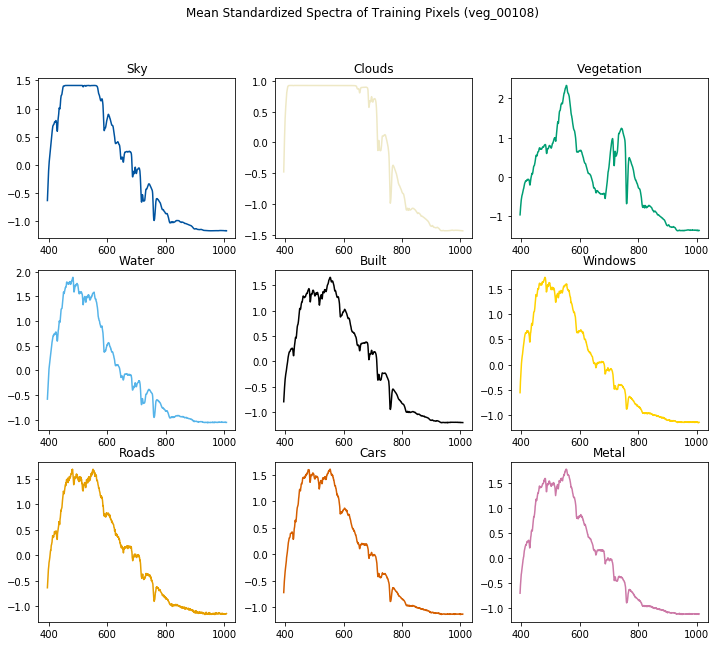

In [21]:
# plot mean spectra for training set separately

import matplotlib.pyplot as plt
%matplotlib inline

f, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(12, 10))
plt.suptitle('Mean Standardized Spectra of Training Pixels (veg_00108)')
ax1.plot(cube.waves, cube_sky_train[:,:-2].mean(0), color=[0,0.32549,0.62353])
ax1.set_title("Sky")
ax2.plot(cube.waves, cube_clouds_train[:,:-2].mean(0), color=[0.93333,0.9098,0.77255])
ax2.set_title("Clouds")
ax3.plot(cube.waves, cube_veg_train[:,:-2].mean(0), color=[0,0.61961,0.45098])
ax3.set_title("Vegetation")
ax4.plot(cube.waves, cube_wtr_train[:,:-2].mean(0), color=[0.33725,0.70588,0.91373])
ax4.set_title("Water")
ax5.plot(cube.waves, cube_blt_train[:,:-2].mean(0), color=[0,0,0])
ax5.set_title("Built")
ax6.plot(cube.waves, cube_windows_train[:,:-2].mean(0), color=[1,0.82353,0])
ax6.set_title("Windows")
ax7.plot(cube.waves, cube_rds_train[:,:-2].mean(0), color=[0.90196,0.62353,0])
ax7.set_title("Roads")
ax8.plot(cube.waves, cube_cars_train[:,:-2].mean(0), color=[0.83529,0.36863,0])
ax8.set_title("Cars")
ax9.plot(cube.waves, cube_mtl_train[:,:-2].mean(0), color=[0.8,0.47451,0.65490])
ax9.set_title("Metal")
plt.show()
#f.savefig("./plots/CNN_spatial_train_108_1_mean_spectra_108_training_pixels_3x3.png")

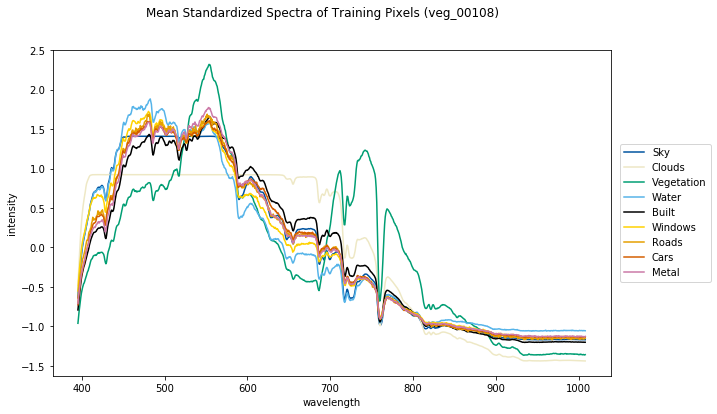

In [22]:
# plot mean spectra for training set together

import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,6))
plt.suptitle('Mean Standardized Spectra of Training Pixels (veg_00108)')
ax.plot(cube.waves, cube_sky_train[:,:-2].mean(0), color=[0,0.32549,0.62353], label="Sky")
ax.plot(cube.waves, cube_clouds_train[:,:-2].mean(0), color=[0.93333,0.9098,0.77255], label="Clouds")
ax.plot(cube.waves, cube_veg_train[:,:-2].mean(0), color=[0,0.61961,0.45098], label="Vegetation")
ax.plot(cube.waves, cube_wtr_train[:,:-2].mean(0), color=[0.33725,0.70588,0.91373], label="Water")
ax.plot(cube.waves, cube_blt_train[:,:-2].mean(0), color=[0,0,0], label="Built")
ax.plot(cube.waves, cube_windows_train[:,:-2].mean(0), color=[1,0.82353,0], label="Windows")
ax.plot(cube.waves, cube_rds_train[:,:-2].mean(0), color=[0.90196,0.62353,0], label="Roads")
ax.plot(cube.waves, cube_cars_train[:,:-2].mean(0), color=[0.83529,0.36863,0], label="Cars")
ax.plot(cube.waves, cube_mtl_train[:,:-2].mean(0), color=[0.8,0.47451,0.65490], label="Metal")
ax.legend(loc="center right", borderaxespad=-10.0)
ax.set_xlabel("wavelength")
ax.set_ylabel("intensity")
plt.show()
#fig.savefig("./plots/CNN_spatial_train_108_2_mean_spectra_108_training_pixels_all.png")

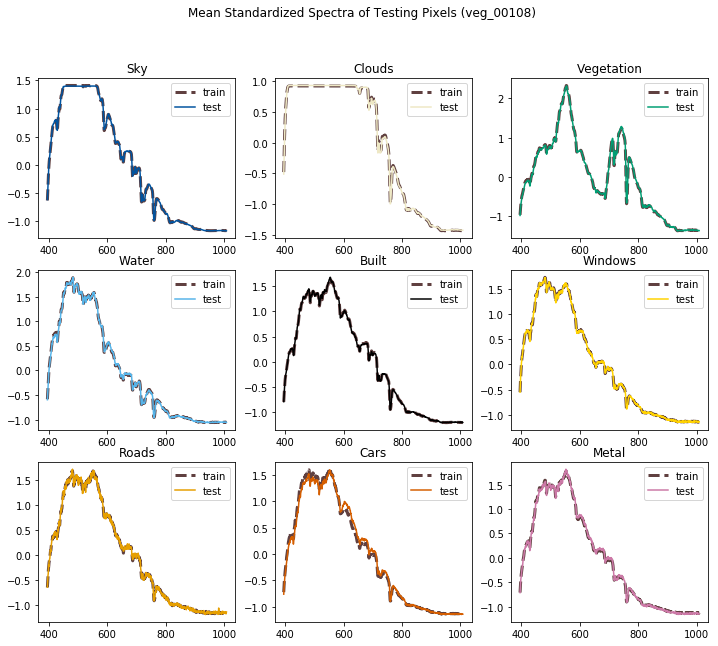

In [23]:
# plot mean spectra for testing set separately

import matplotlib.pyplot as plt
%matplotlib inline

f, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(12, 10))
plt.suptitle('Mean Standardized Spectra of Testing Pixels (veg_00108)')
ax1.plot(cube.waves, cube_sky_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=3, ls="dashed")
ax1.plot(cube.waves, cube_sky_test[:,:-2].mean(0), color=[0,0.32549,0.62353])
ax1.set_title("Sky")
ax1.legend(['train', 'test'], loc='upper right')
ax2.plot(cube.waves, cube_clouds_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=3, ls="dashed")
ax2.plot(cube.waves, cube_clouds_test[:,:-2].mean(0), color=[0.93333,0.9098,0.77255])
ax2.set_title("Clouds")
ax2.legend(['train', 'test'], loc='upper right')
ax3.plot(cube.waves, cube_veg_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=3, ls="dashed")
ax3.plot(cube.waves, cube_veg_test[:,:-2].mean(0), color=[0,0.61961,0.45098])
ax3.set_title("Vegetation")
ax3.legend(['train', 'test'], loc='upper right')
ax4.plot(cube.waves, cube_wtr_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=3, ls="dashed")
ax4.plot(cube.waves, cube_wtr_test[:,:-2].mean(0), color=[0.33725,0.70588,0.91373])
ax4.set_title("Water")
ax4.legend(['train', 'test'], loc='upper right')
ax5.plot(cube.waves, cube_blt_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=3, ls="dashed")
ax5.plot(cube.waves, cube_blt_test[:,:-2].mean(0), color=[0,0,0])
ax5.set_title("Built")
ax5.legend(['train', 'test'], loc='upper right')
ax6.plot(cube.waves, cube_windows_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=3, ls="dashed")
ax6.plot(cube.waves, cube_windows_test[:,:-2].mean(0), color=[1,0.82353,0])
ax6.set_title("Windows")
ax6.legend(['train', 'test'], loc='upper right')
ax7.plot(cube.waves, cube_rds_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=3, ls="dashed")
ax7.plot(cube.waves, cube_rds_test[:,:-2].mean(0), color=[0.90196,0.62353,0])
ax7.set_title("Roads")
ax7.legend(['train', 'test'], loc='upper right')
ax8.plot(cube.waves, cube_cars_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=3, ls="dashed")
ax8.plot(cube.waves, cube_cars_test[:,:-2].mean(0), color=[0.83529,0.36863,0])
ax8.set_title("Cars")
ax8.legend(['train', 'test'], loc='upper right')
ax9.plot(cube.waves, cube_mtl_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=3, ls="dashed")
ax9.plot(cube.waves, cube_mtl_test[:,:-2].mean(0), color=[0.8,0.47451,0.65490])
ax9.set_title("Metal")
ax9.legend(['train', 'test'], loc='upper right')
plt.show()
#f.savefig("./plots/CNN_spatial_train_108_3_mean_spectra_108_training_vs_testing_pixels_3x3.png")

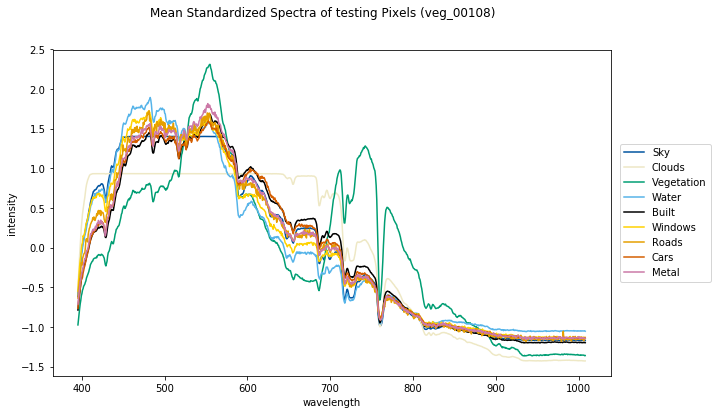

In [24]:
# plot mean spectra for testing set together

import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,6))
plt.suptitle('Mean Standardized Spectra of testing Pixels (veg_00108)')
ax.plot(cube.waves, cube_sky_test[:,:-2].mean(0), color=[0,0.32549,0.62353], label="Sky")
ax.plot(cube.waves, cube_clouds_test[:,:-2].mean(0), color=[0.93333,0.9098,0.77255], label="Clouds")
ax.plot(cube.waves, cube_veg_test[:,:-2].mean(0), color=[0,0.61961,0.45098], label="Vegetation")
ax.plot(cube.waves, cube_wtr_test[:,:-2].mean(0), color=[0.33725,0.70588,0.91373], label="Water")
ax.plot(cube.waves, cube_blt_test[:,:-2].mean(0), color=[0,0,0], label="Built")
ax.plot(cube.waves, cube_windows_test[:,:-2].mean(0), color=[1,0.82353,0], label="Windows")
ax.plot(cube.waves, cube_rds_test[:,:-2].mean(0), color=[0.90196,0.62353,0], label="Roads")
ax.plot(cube.waves, cube_cars_test[:,:-2].mean(0), color=[0.83529,0.36863,0], label="Cars")
ax.plot(cube.waves, cube_mtl_test[:,:-2].mean(0), color=[0.8,0.47451,0.65490], label="Metal")
ax.legend(loc="center right", borderaxespad=-10.0)
ax.set_xlabel("wavelength")
ax.set_ylabel("intensity")
plt.show()
#fig.savefig("./plots/CNN_spatial_train_108_4_mean_spectra_108_testing_pixels_all.png")

#### Train CNN on 80%

In [25]:
cube_train_labels = np.array(cube_train_labels)
cube_test_labels = np.array(cube_test_labels)

In [26]:
import tensorflow as tf
from tensorflow import keras

cnn = keras.Sequential([keras.layers.Conv1D(16, kernel_size=(50), padding="same", 
                                            activation="relu", input_shape=(cube_specxy.shape[2], 1)),
                       keras.layers.MaxPooling1D((2), strides=2),
                        keras.layers.Conv1D(32, kernel_size=(50), padding="same", activation="relu"),
                        keras.layers.MaxPooling1D((2), strides=2),
                        keras.layers.Flatten(),
                        keras.layers.Dense(512, activation="relu"),
                        keras.layers.Dense(10, activation="softmax")])

cnn.compile(optimizer="adam", loss=["sparse_categorical_crossentropy"], metrics=['accuracy'])

cube_train2 = cube_train.reshape(cube_train.shape[0], cube_train.shape[1], 1)
cube_test2 = cube_test.reshape(cube_test.shape[0], cube_test.shape[1], 1)

CNNmodel = cnn.fit(cube_train2, cube_train_labels, validation_data=(cube_test2, cube_test_labels), 
                   epochs=100, batch_size=512)

Train on 2560 samples, validate on 640 samples
Epoch 1/100
2560/2560 [==============================] - 2s 856us/sample - loss: 1.7711 - accuracy: 0.4066 - val_loss: 1.2665 - val_accuracy: 0.5000
Epoch 2/100
2560/2560 [==============================] - 1s 428us/sample - loss: 1.0546 - accuracy: 0.6637 - val_loss: 0.8234 - val_accuracy: 0.7312
Epoch 3/100
2560/2560 [==============================] - 1s 418us/sample - loss: 0.7405 - accuracy: 0.7680 - val_loss: 0.6688 - val_accuracy: 0.7734
Epoch 4/100
2560/2560 [==============================] - 1s 417us/sample - loss: 0.6348 - accuracy: 0.8012 - val_loss: 0.6015 - val_accuracy: 0.8031
Epoch 5/100
2560/2560 [==============================] - 1s 416us/sample - loss: 0.5575 - accuracy: 0.8387 - val_loss: 0.5326 - val_accuracy: 0.8156
Epoch 6/100
2560/2560 [==============================] - 1s 391us/sample - loss: 0.4821 - accuracy: 0.8527 - val_loss: 0.4442 - val_accuracy: 0.8422
Epoch 7/100
2560/2560 [==============================] - 1s

<function matplotlib.pyplot.show(*args, **kw)>

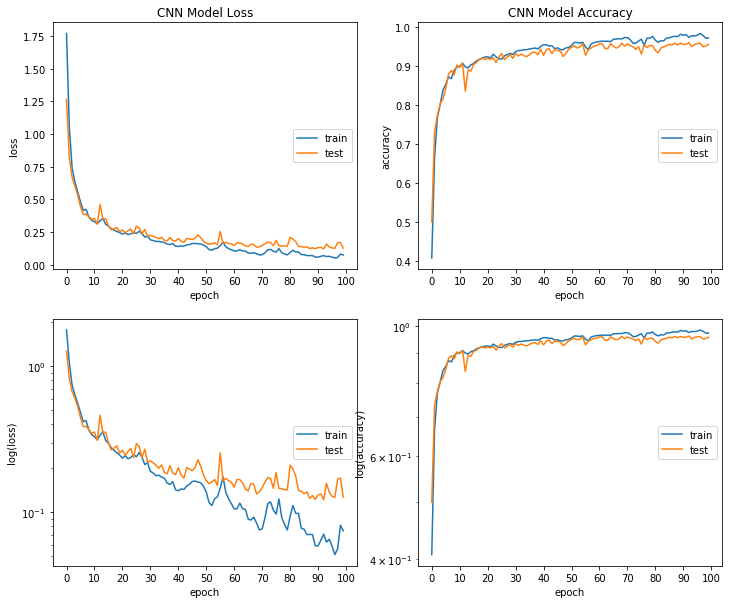

In [27]:
# summarize history of loss

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(12, 10))
ax1.plot(CNNmodel.history['loss'])
ax1.plot(CNNmodel.history['val_loss'])
ax1.set_title('CNN Model Loss')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.locator_params(nbins=13, axis='x')
ax1.legend(['train', 'test'], loc='center right')
ax2.plot(CNNmodel.history['accuracy'])
ax2.plot(CNNmodel.history['val_accuracy'])
ax2.set_title('CNN Model Accuracy')
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')
ax2.locator_params(nbins=12, axis='x')
ax2.legend(['train', 'test'], loc='center right')
ax3.plot(CNNmodel.history['loss'])
ax3.plot(CNNmodel.history['val_loss'])
ax3.set_ylabel('log(loss)')
ax3.set_xlabel('epoch')
ax3.locator_params(nbins=13, axis='x')
ax3.legend(['train', 'test'], loc='center right')
ax3.set_yscale('log')
ax4.plot(CNNmodel.history['accuracy'])
ax4.plot(CNNmodel.history['val_accuracy'])
ax4.set_ylabel('log(accuracy)')
ax4.set_xlabel('epoch')
ax4.locator_params(nbins=12, axis='x')
ax4.legend(['train', 'test'], loc='center right')
ax4.set_yscale('log')
plt.show
#f.savefig("./plots/CNN_spatial_train_108_5_CNN_loss_accuracy_vs_epoch.png")

In [28]:
import tensorflow as tf
from tensorflow import keras

cnn = keras.Sequential([keras.layers.Conv1D(16, kernel_size=(50), padding="same", 
                                            activation="relu", input_shape=(cube_specxy.shape[2], 1)),
                       keras.layers.MaxPooling1D((2), strides=2),
                        keras.layers.Conv1D(32, kernel_size=(50), padding="same", activation="relu"),
                        keras.layers.MaxPooling1D((2), strides=2),
                        keras.layers.Flatten(),
                        keras.layers.Dense(512, activation="relu"),
                        keras.layers.Dense(10, activation="softmax")])

cnn.compile(optimizer="adam", loss=["sparse_categorical_crossentropy"], metrics=['accuracy'])

cube_train2 = cube_train.reshape(cube_train.shape[0], cube_train.shape[1], 1)
cube_test2 = cube_test.reshape(cube_test.shape[0], cube_test.shape[1], 1)

CNNmodel = cnn.fit(cube_train2, cube_train_labels, validation_data=(cube_test2, cube_test_labels), 
                   epochs=30, batch_size=512)

Train on 2560 samples, validate on 640 samples
Epoch 1/30
2560/2560 [==============================] - 2s 787us/sample - loss: 1.6900 - accuracy: 0.3754 - val_loss: 1.2487 - val_accuracy: 0.6375
Epoch 2/30
2560/2560 [==============================] - 1s 390us/sample - loss: 0.9637 - accuracy: 0.6793 - val_loss: 0.8075 - val_accuracy: 0.7250
Epoch 3/30
2560/2560 [==============================] - 1s 398us/sample - loss: 0.7506 - accuracy: 0.7578 - val_loss: 0.6593 - val_accuracy: 0.7953
Epoch 4/30
2560/2560 [==============================] - 1s 434us/sample - loss: 0.6363 - accuracy: 0.8031 - val_loss: 0.5928 - val_accuracy: 0.8109
Epoch 5/30
2560/2560 [==============================] - 1s 435us/sample - loss: 0.5463 - accuracy: 0.8328 - val_loss: 0.4856 - val_accuracy: 0.8422
Epoch 6/30
2560/2560 [==============================] - 1s 443us/sample - loss: 0.5005 - accuracy: 0.8406 - val_loss: 0.4764 - val_accuracy: 0.8562
Epoch 7/30
2560/2560 [==============================] - 1s 417us/

In [29]:
# model accuracy on training and testing sets

train_loss_80, train_acc_80 = cnn.evaluate(cube_train2, cube_train_labels)
test_loss_80, test_acc_80 = cnn.evaluate(cube_test2, cube_test_labels)

print(train_acc_80, test_acc_80)

640/640 [==============================] - 0s 245us/sample - loss: 0.2187 - accuracy: 0.9281
0.9433594 0.928125


### Predict pixel classification on veg_00108 trained with 80-20 split

In [30]:
# classify entire binned cube
import time
start_time = time.time()

cube_specxy_2d_1 = cube_specxy_2d.reshape(cube_specxy_2d.shape[0], cube_specxy_2d.shape[1], 1)
predictCube = cnn.predict_classes(cube_specxy_2d_1)

elapsed_time = time.time() - start_time
print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

00:09:03


In [31]:
predictCube_reshape = predictCube.reshape(cube_specxy.shape[0], cube_specxy.shape[1])

In [32]:
veg_by_row = np.zeros(cube_sub.shape[1])
for row in range(0, cube_sub.shape[1]):
    veg_by_row[row] = np.count_nonzero(predictCube_reshape[row,:] == 2)# + np.count_nonzero(labels_reshape[row,:] == 8) + np.count_nonzero(labels_reshape[row,:] == 9)

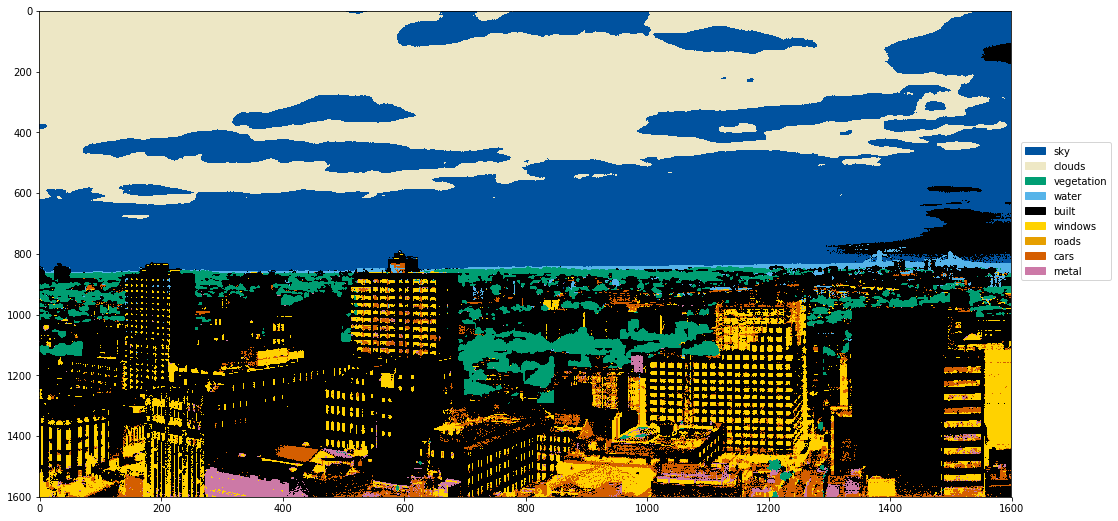

In [35]:
import matplotlib.pyplot as plt
import matplotlib.colors as ListedColorMap
import matplotlib.patches as mpatches
from matplotlib.ticker import NullFormatter
%matplotlib inline

cmap = {0:[0,0.32549,0.62353,1], 1:[0.93333,0.9098,0.77255,1], 2:[0,0.61961,0.45098,1],  3:[0.33725,0.70588,0.91373,1],
        4:[0,0,0,1], 5:[1,0.82353,0,1], 6:[0.90196,0.62353,0,1], 7:[0.83529,0.36863,0,1],
        8:[0.8,0.47451,0.65490,1]}
labels = {0:'sky', 1:'clouds', 2:'vegetation', 3:'water', 4:'built',
          5:'windows', 6:'roads', 7:'cars', 8:'metal'}
arrayShow = np.array([[cmap[i] for i in j] for j in predictCube_reshape])
patches = [mpatches.Patch(color=cmap[i], label=labels[i]) for i in cmap]

fig = plt.figure(figsize=(15,15))
ax = fig.add_axes([0.1,0.1,0.9,0.9])
ax.tick_params(labelsize=10)
ax.imshow(arrayShow, aspect=0.5)
lgd = ax.legend(handles=patches, bbox_to_anchor=(1,0.75), loc='upper left', borderaxespad=1.0, prop={'size':10}, ncol=1)
plt.show()
#fig.savefig("./plots/CNN_spatial_train_108_6_108_predict_map.png", bbox_extra_artists=(lgd,), bbox_inches='tight')

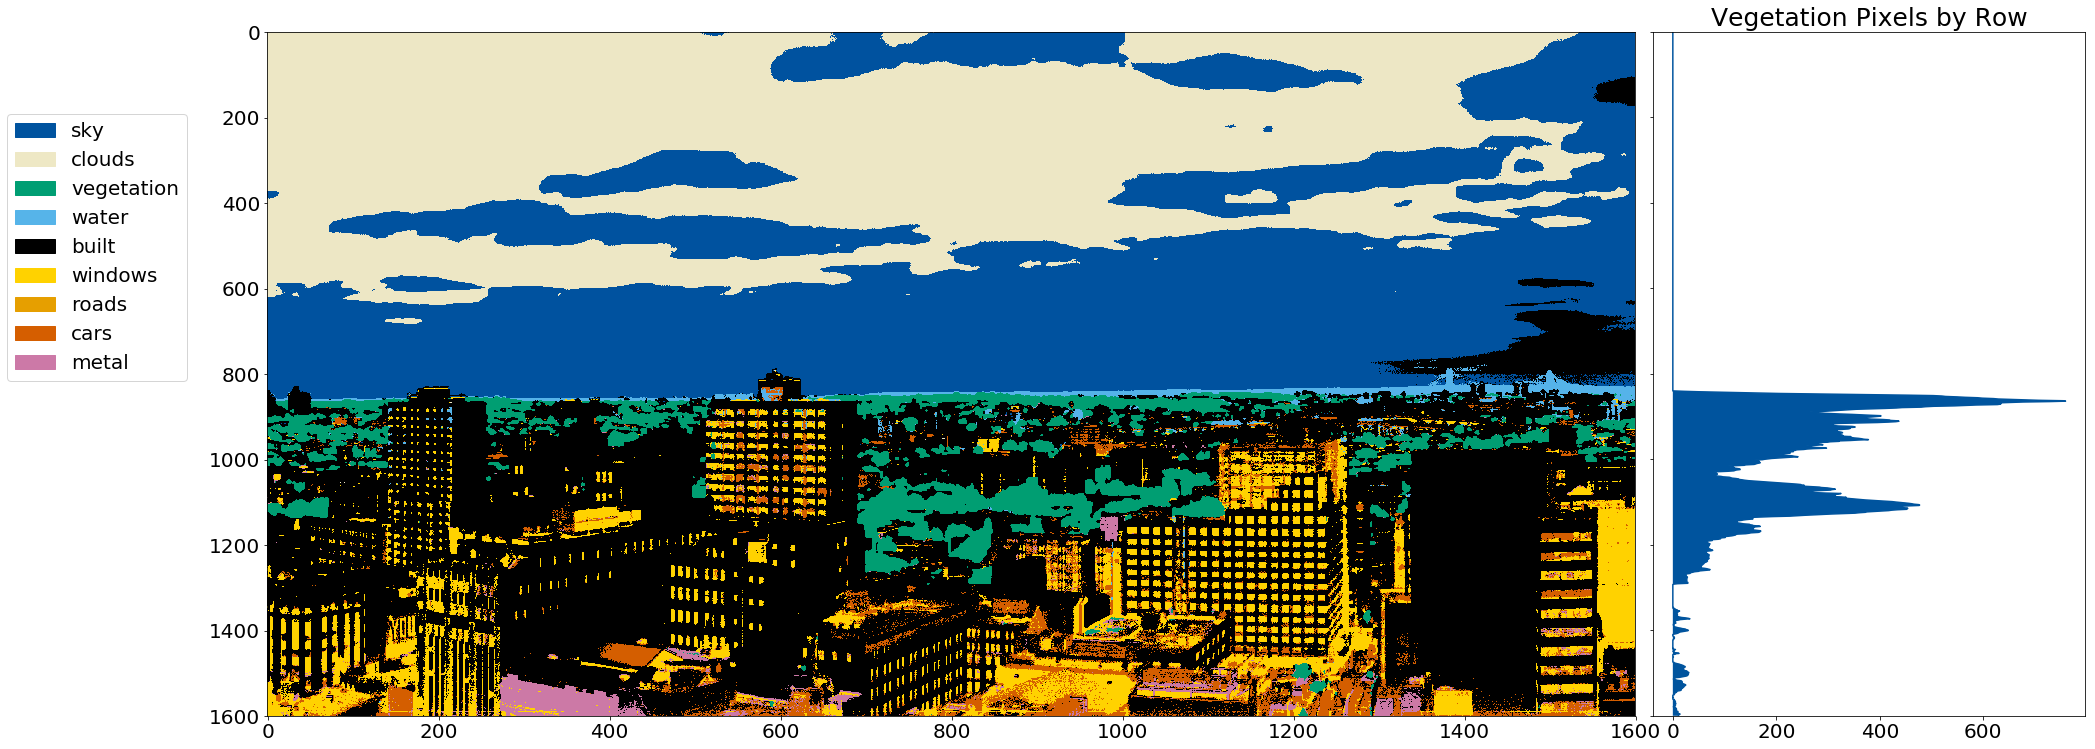

In [36]:
import matplotlib.pyplot as plt
import matplotlib.colors as ListedColorMap
import matplotlib.patches as mpatches
from matplotlib.ticker import NullFormatter
%matplotlib inline

cmap = {0:[0,0.32549,0.62353,1], 1:[0.93333,0.9098,0.77255,1], 2:[0,0.61961,0.45098,1],  3:[0.33725,0.70588,0.91373,1],
        4:[0,0,0,1], 5:[1,0.82353,0,1], 6:[0.90196,0.62353,0,1], 7:[0.83529,0.36863,0,1],
        8:[0.8,0.47451,0.65490,1]}
labels = {0:'sky', 1:'clouds', 2:'vegetation', 3:'water', 4:'built',
          5:'windows', 6:'roads', 7:'cars', 8:'metal'}
arrayShow = np.array([[cmap[i] for i in j] for j in predictCube_reshape])
patches = [mpatches.Patch(color=cmap[i], label=labels[i]) for i in cmap]
#fig, ax = plt.subplots(figsize = (20,10))

fig = plt.figure(1, figsize=(30,10))
axImage = plt.axes([0.1,0.1,0.85,0.95])
axHist = plt.axes([0.85,0.1,0.2,0.95])
axHist.yaxis.set_major_formatter(NullFormatter())
axImage.tick_params(labelsize=20)
axHist.tick_params(labelsize=20)
axImage.imshow(arrayShow, aspect=0.5)
axHist.plot(veg_by_row, np.arange(0,cube_sub.shape[1]), color=[0.0,0.33,0.62])
axHist.fill_between(veg_by_row, np.arange(0,cube_sub.shape[1]), cube_sub.shape[1], facecolor=[0.0,0.33,0.62])
axHist.set_ylim(cube_sub.shape[1], 0)
axHist.set(title='Vegetation Pixels by Row')
axHist.title.set_fontsize(25)
lgd = axImage.legend(handles=patches, bbox_to_anchor=(0,0.5), loc=2, borderaxespad=-13.0, prop={'size':20}, ncol=1)
plt.show()
#fig.savefig("./plots/CNN_spatial_train_108_6_108_predict_map_veg_by_row.png", bbox_extra_artists=(lgd,), bbox_inches='tight')

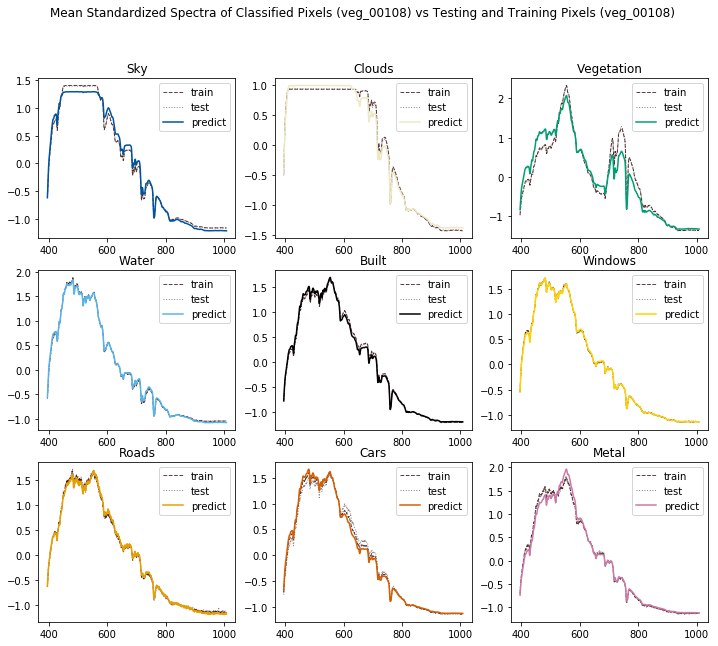

In [37]:
# plot mean spectra for testing set separately

import matplotlib.pyplot as plt
%matplotlib inline

f, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(12, 10))
plt.suptitle('Mean Standardized Spectra of Classified Pixels (veg_00108) vs Testing and Training Pixels (veg_00108)')
ax1.plot(cube.waves, cube_sky_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=1, ls="dashed")
ax1.plot(cube.waves, cube_sky_test[:,:-2].mean(0), color=[0.170,0,0,0.5], lw=1, ls="dotted")
ax1.plot(cube.waves, cube_standard[np.where(predictCube == 0)[0]].mean(0), color=[0,0.32549,0.62353])
ax1.set_title("Sky")
ax1.legend(['train', 'test', 'predict'], loc='upper right')
ax2.plot(cube.waves, cube_clouds_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=1, ls="dashed")
ax2.plot(cube.waves, cube_clouds_test[:,:-2].mean(0), color=[0.170,0,0,0.5], lw=1, ls="dotted")
ax2.plot(cube.waves, cube_standard[np.where(predictCube == 1)[0]].mean(0), color=[0.93333,0.9098,0.77255])
ax2.set_title("Clouds")
ax2.legend(['train', 'test', 'predict'], loc='upper right')
ax3.plot(cube.waves, cube_veg_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=1, ls="dashed")
ax3.plot(cube.waves, cube_veg_test[:,:-2].mean(0), color=[0.170,0,0,0.5], lw=1, ls="dotted")
ax3.plot(cube.waves, cube_standard[np.where(predictCube == 2)[0]].mean(0), color=[0,0.61961,0.45098])
ax3.set_title("Vegetation")
ax3.legend(['train', 'test', 'predict'], loc='upper right')
ax4.plot(cube.waves, cube_wtr_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=1, ls="dashed")
ax4.plot(cube.waves, cube_wtr_test[:,:-2].mean(0), color=[0.170,0,0,0.5], lw=1, ls="dotted")
ax4.plot(cube.waves, cube_standard[np.where(predictCube == 3)[0]].mean(0), color=[0.33725,0.70588,0.91373])
ax4.set_title("Water")
ax4.legend(['train', 'test', 'predict'], loc='upper right')
ax5.plot(cube.waves, cube_blt_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=1, ls="dashed")
ax5.plot(cube.waves, cube_blt_test[:,:-2].mean(0), color=[0.170,0,0,0.5], lw=1, ls="dotted")
ax5.plot(cube.waves, cube_standard[np.where(predictCube == 4)[0]].mean(0), color=[0,0,0])
ax5.set_title("Built")
ax5.legend(['train', 'test', 'predict'], loc='upper right')
ax6.plot(cube.waves, cube_windows_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=1, ls="dashed")
ax6.plot(cube.waves, cube_windows_test[:,:-2].mean(0), color=[0.170,0,0,0.5], lw=1, ls="dotted")
ax6.plot(cube.waves, cube_standard[np.where(predictCube == 5)[0]].mean(0), color=[1,0.82353,0])
ax6.set_title("Windows")
ax6.legend(['train', 'test', 'predict'], loc='upper right')
ax7.plot(cube.waves, cube_rds_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=1, ls="dashed")
ax7.plot(cube.waves, cube_rds_test[:,:-2].mean(0), color=[0.170,0,0,0.5], lw=1, ls="dotted")
ax7.plot(cube.waves, cube_standard[np.where(predictCube == 6)[0]].mean(0), color=[0.90196,0.62353,0])
ax7.set_title("Roads")
ax7.legend(['train', 'test', 'predict'], loc='upper right')
ax8.plot(cube.waves, cube_cars_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=1, ls="dashed")
ax8.plot(cube.waves, cube_cars_test[:,:-2].mean(0), color=[0.170,0,0,0.5], lw=1, ls="dotted")
ax8.plot(cube.waves, cube_standard[np.where(predictCube == 7)[0]].mean(0), color=[0.83529,0.36863,0])
ax8.set_title("Cars")
ax8.legend(['train', 'test', 'predict'], loc='upper right')
ax9.plot(cube.waves, cube_mtl_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=1, ls="dashed")
ax9.plot(cube.waves, cube_mtl_test[:,:-2].mean(0), color=[0.170,0,0,0.5], lw=1, ls="dotted")
ax9.plot(cube.waves, cube_standard[np.where(predictCube == 8)[0]].mean(0), color=[0.8,0.47451,0.65490])
ax9.set_title("Metal")
ax9.legend(['train', 'test', 'predict'], loc='upper right')
plt.show()
#f.savefig("./plots/CNN_spatial_train_108_7_108_mean_spectra_train_test_predict_3x3.png")

### Evaluation Metrics 80-20 split

In [38]:
labels_pred_sky = predictCube_reshape[sky_coords[:,0], sky_coords[:,1]]
labels_pred_clouds = predictCube_reshape[clouds_coords[:,0], clouds_coords[:,1]]
labels_pred_veg = predictCube_reshape[veg_coords[:,0], veg_coords[:,1]]
labels_pred_wtr = predictCube_reshape[wtr_coords[:,0], wtr_coords[:,1]]
labels_pred_blt = predictCube_reshape[blt_coords[:,0], blt_coords[:,1]]
labels_pred_windows = predictCube_reshape[windows_coords[:,0], windows_coords[:,1]]
labels_pred_rds = predictCube_reshape[rds_coords[:,0], rds_coords[:,1]]
labels_pred_cars = predictCube_reshape[cars_coords[:,0], cars_coords[:,1]]
labels_pred_mtl = predictCube_reshape[mtl_coords[:,0], mtl_coords[:,1]]

labels_pred = np.concatenate((labels_pred_sky, labels_pred_clouds, labels_pred_veg, labels_pred_wtr, 
                             labels_pred_blt, labels_pred_windows, labels_pred_rds, labels_pred_cars, labels_pred_mtl))

In [39]:
labels_true_sky = np.full((sky_coords.shape[0]), 0)
labels_true_clouds = np.full((clouds_coords.shape[0]), 1)
labels_true_veg = np.full((veg_coords.shape[0]), 2)
labels_true_wtr = np.full((wtr_coords.shape[0]), 3)
labels_true_blt = np.full((blt_coords.shape[0]), 4)
labels_true_windows = np.full((windows_coords.shape[0]), 5)
labels_true_rds = np.full((rds_coords.shape[0]), 6)
labels_true_cars = np.full((cars_coords.shape[0]), 7)
labels_true_mtl = np.full((mtl_coords.shape[0]), 8)

labels_true = np.concatenate((labels_true_sky, labels_true_clouds, labels_true_veg, labels_true_wtr, 
                             labels_true_blt, labels_true_windows, labels_true_rds, labels_true_cars, labels_true_mtl))

In [40]:
print(labels_pred.shape)
print(labels_true.shape)

(3200,)
(3200,)


In [41]:
from sklearn import metrics

print("Confusion Matrix")
print(metrics.confusion_matrix(labels_true, labels_pred))

print("")
print("Accuracy Score")
print(metrics.accuracy_score(labels_true, labels_pred))

target_names = ['sky', 'clouds', 'vegetation', 'water', 'built', 'windows', 'roads', 'cars', 'metal']
print("")
print("Classification Report")
print(metrics.classification_report(labels_true, labels_pred, target_names=target_names))

Confusion Matrix
[[300   0   0   0   0   0   0   0   0]
 [  1 499   0   0   0   0   0   0   0]
 [  0   0 595   1   4   0   0   0   0]
 [  0   0   0  50   0   0   0   0   0]
 [  0   0   1   3 998   4   0  11   3]
 [  0   0   0   0  34 448   0  16   2]
 [  0   0   0   0  17   0   0  13   0]
 [  0   0   0   0   4   3   0  93   0]
 [  0   0   0   0  49   5   0  20  26]]

Accuracy Score
0.9403125

Classification Report
             precision    recall  f1-score   support

        sky       1.00      1.00      1.00       300
     clouds       1.00      1.00      1.00       500
 vegetation       1.00      0.99      0.99       600
      water       0.93      1.00      0.96        50
      built       0.90      0.98      0.94      1020
    windows       0.97      0.90      0.93       500
      roads       0.00      0.00      0.00        30
       cars       0.61      0.93      0.74       100
      metal       0.84      0.26      0.40       100

avg / total       0.94      0.94      0.93      32

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [42]:
#f = open("./metrics/CNN_spatial_train_108_test_108_binned_848_metrics.txt", "w")
#f.write("Confusion Matrix")
#f.write('\n')
#f.write(str(metrics.confusion_matrix(labels_true, labels_pred)))
#f.write('\n')
#f.write('\n')
#f.write("Accuracy Score")
#f.write('\n')
#f.write(str(metrics.accuracy_score(labels_true, labels_pred)))
#target_names = ['sky', 'clouds', 'vegetation', 'water', 'built', 'windows', 'roads', 'cars', 'metal']
#f.write('\n')
#f.write('\n')
#f.write("Classification Report")
#f.write('\n')
#f.write(metrics.classification_report(labels_true, labels_pred, target_names=target_names))
#f.close()

In [43]:
sky_dict, sky_dict_norm = kmeans_test_dictionary(predictCube_reshape, sky_coords, 9)
clouds_dict, cloud_dict_norm = kmeans_test_dictionary(predictCube_reshape, clouds_coords, 9)
veg_dict, veg_dict_norm = kmeans_test_dictionary(predictCube_reshape, veg_coords, 9)
wtr_dict, wtr_dict_norm = kmeans_test_dictionary(predictCube_reshape, wtr_coords, 9)
blt_dict, blt_dict_norm = kmeans_test_dictionary(predictCube_reshape, blt_coords, 9)
windows_dict, windows_dict_norm = kmeans_test_dictionary(predictCube_reshape, windows_coords, 9)
rds_dict, rds_dict_norm = kmeans_test_dictionary(predictCube_reshape, rds_coords, 9)
cars_dict, cars_dict_norm = kmeans_test_dictionary(predictCube_reshape, cars_coords, 9)
mtl_dict, mtl_dict_norm = kmeans_test_dictionary(predictCube_reshape, mtl_coords, 9)

df_test = kmeans_test_dataframe(sky_dict, clouds_dict, veg_dict, wtr_dict,
                                blt_dict, windows_dict, rds_dict, cars_dict, mtl_dict)
print(df_test.transpose())
df_test_norm = kmeans_test_dataframe(sky_dict, clouds_dict, veg_dict, wtr_dict,
                                     blt_dict, windows_dict, rds_dict, cars_dict, mtl_dict)
#print("")
#print(df_test_norm.transpose())

              0    1    2   3    4    5  6   7   8
sky         300    0    0   0    0    0  0   0   0
clouds        1  499    0   0    0    0  0   0   0
vegetation    0    0  595   1    4    0  0   0   0
water         0    0    0  50    0    0  0   0   0
built         0    0    1   3  998    4  0  11   3
windows       0    0    0   0   34  448  0  16   2
roads         0    0    0   0   17    0  0  13   0
cars          0    0    0   0    4    3  0  93   0
metal         0    0    0   0   49    5  0  20  26


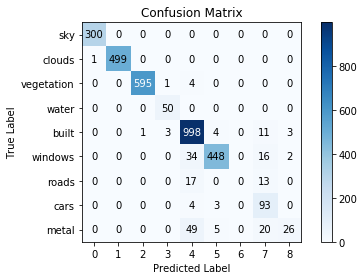

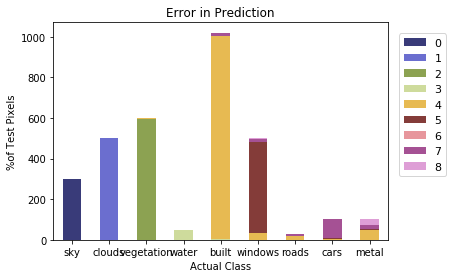

In [44]:
plot_confusion_matrix(df_test, norm=False)
#plot_confusion_matrix(df_test_norm, norm=True)
plot_test_result(df_test_norm)

## Split classified pixels into 50% training and 50% testing sets

In [45]:
train_ratio = 0.5

import random

# sky coordinates
sky_ind = np.arange(sky_coords.shape[0])
random.Random(3).shuffle(sky_ind)
lim_ind = int(len(sky_ind)*train_ratio)
sky_train_ind = sky_ind[:lim_ind]
sky_test_ind = sky_ind[lim_ind:]
print("sky %d %d" % (len(sky_train_ind), len(sky_test_ind)))

# clouds coordinates
clouds_ind = np.arange(clouds_coords.shape[0])
random.Random(3).shuffle(clouds_ind)
lim_ind = int(len(clouds_ind)*train_ratio)
clouds_train_ind = clouds_ind[:lim_ind]
clouds_test_ind = clouds_ind[lim_ind:]
print("clouds %d %d" % (len(clouds_train_ind), len(clouds_test_ind)))

# vegetation coordinates
veg_ind = np.arange(veg_coords.shape[0])
random.Random(3).shuffle(veg_ind)
lim_ind = int(len(veg_ind)*train_ratio)
veg_train_ind = veg_ind[:lim_ind]
veg_test_ind = veg_ind[lim_ind:]
print("vegetation %d %d" % (len(veg_train_ind), len(veg_test_ind)))

# water coordinates
wtr_ind = np.arange(wtr_coords.shape[0])
random.Random(3).shuffle(wtr_ind)
lim_ind = int(len(wtr_ind)*train_ratio)
wtr_train_ind = wtr_ind[:lim_ind]
wtr_test_ind = wtr_ind[lim_ind:]
print("water %d %d" % (len(wtr_train_ind), len(wtr_test_ind)))

# built coordinates
blt_ind = np.arange(blt_coords.shape[0])
random.Random(3).shuffle(blt_ind)
lim_ind = int(len(blt_ind)*train_ratio)
blt_train_ind = blt_ind[:lim_ind]
blt_test_ind = blt_ind[lim_ind:]
print("built %d %d" % (len(blt_train_ind), len(blt_test_ind)))

# windows coordinates
windows_ind = np.arange(windows_coords.shape[0])
random.Random(3).shuffle(windows_ind)
lim_ind = int(len(windows_ind)*train_ratio)
windows_train_ind = windows_ind[:lim_ind]
windows_test_ind = windows_ind[lim_ind:]
print("windows %d %d" % (len(windows_train_ind), len(windows_test_ind)))

# roads coordinates
rds_ind = np.arange(rds_coords.shape[0])
random.Random(3).shuffle(rds_ind)
lim_ind = int(len(rds_ind)*train_ratio)
rds_train_ind = rds_ind[:lim_ind]
rds_test_ind = rds_ind[lim_ind:]
print("roads %d %d" % (len(rds_train_ind), len(rds_test_ind)))

# cars coordinates
cars_ind = np.arange(cars_coords.shape[0])
random.Random(3).shuffle(cars_ind)
lim_ind = int(len(cars_ind)*train_ratio)
cars_train_ind = cars_ind[:lim_ind]
cars_test_ind = cars_ind[lim_ind:]
print("cars %d %d" % (len(cars_train_ind), len(cars_test_ind)))

# metal coordinates
mtl_ind = np.arange(mtl_coords.shape[0])
random.Random(3).shuffle(mtl_ind)
lim_ind = int(len(mtl_ind)*train_ratio)
mtl_train_ind = mtl_ind[:lim_ind]
mtl_test_ind = mtl_ind[lim_ind:]
print("metal %d %d" % (len(mtl_train_ind), len(mtl_test_ind)))

sky 150 150
clouds 250 250
vegetation 300 300
water 25 25
built 510 510
windows 250 250
roads 15 15
cars 50 50
metal 50 50


In [46]:
cube_sky_train = cube_specxy[sky_coords[sky_train_ind[:], 0], sky_coords[sky_train_ind[:], 1], :]
cube_sky_test = cube_specxy[sky_coords[sky_test_ind[:], 0], sky_coords[sky_test_ind[:], 1], :]
print("sky ", cube_sky_train.shape, cube_sky_test.shape)

cube_clouds_train = cube_specxy[clouds_coords[clouds_train_ind[:], 0], clouds_coords[clouds_train_ind[:], 1], :]
cube_clouds_test = cube_specxy[clouds_coords[clouds_test_ind[:], 0], clouds_coords[clouds_test_ind[:], 1], :]
print("clouds ", cube_clouds_train.shape, cube_clouds_test.shape)

cube_veg_train = cube_specxy[veg_coords[veg_train_ind[:], 0], veg_coords[veg_train_ind[:], 1], :]
cube_veg_test = cube_specxy[veg_coords[veg_test_ind[:], 0], veg_coords[veg_test_ind[:], 1], :]
print("vegetation ", cube_veg_train.shape, cube_veg_test.shape)

cube_wtr_train = cube_specxy[wtr_coords[wtr_train_ind[:], 0], wtr_coords[wtr_train_ind[:], 1], :]
cube_wtr_test = cube_specxy[wtr_coords[wtr_test_ind[:], 0], wtr_coords[wtr_test_ind[:], 1], :]
print("water ", cube_wtr_train.shape, cube_wtr_test.shape)

cube_blt_train = cube_specxy[blt_coords[blt_train_ind[:], 0], blt_coords[blt_train_ind[:], 1], :]
cube_blt_test = cube_specxy[blt_coords[blt_test_ind[:], 0], blt_coords[blt_test_ind[:], 1], :]
print("built ", cube_blt_train.shape, cube_blt_test.shape)

cube_windows_train = cube_specxy[windows_coords[windows_train_ind[:], 0], windows_coords[windows_train_ind[:], 1], :]
cube_windows_test = cube_specxy[windows_coords[windows_test_ind[:], 0], windows_coords[windows_test_ind[:], 1], :]
print("windows ", cube_windows_train.shape, cube_windows_test.shape)

cube_rds_train = cube_specxy[rds_coords[rds_train_ind[:], 0], rds_coords[rds_train_ind[:], 1], :]
cube_rds_test = cube_specxy[rds_coords[rds_test_ind[:], 0], rds_coords[rds_test_ind[:], 1], :]
print("roads ", cube_rds_train.shape, cube_rds_test.shape)

cube_cars_train = cube_specxy[cars_coords[cars_train_ind[:], 0], cars_coords[cars_train_ind[:], 1], :]
cube_cars_test = cube_specxy[cars_coords[cars_test_ind[:], 0], cars_coords[cars_test_ind[:], 1], :]
print("cars ", cube_cars_train.shape, cube_cars_test.shape)

cube_mtl_train = cube_specxy[mtl_coords[mtl_train_ind[:], 0], mtl_coords[mtl_train_ind[:], 1], :]
cube_mtl_test = cube_specxy[mtl_coords[mtl_test_ind[:], 0], mtl_coords[mtl_test_ind[:], 1], :]
print("metal ", cube_mtl_train.shape, cube_mtl_test.shape)

sky  (150, 850) (150, 850)
clouds  (250, 850) (250, 850)
vegetation  (300, 850) (300, 850)
water  (25, 850) (25, 850)
built  (510, 850) (510, 850)
windows  (250, 850) (250, 850)
roads  (15, 850) (15, 850)
cars  (50, 850) (50, 850)
metal  (50, 850) (50, 850)


In [47]:
# concatenate training and testing sets and create index arrays

cube_train = np.concatenate((cube_sky_train, cube_clouds_train, cube_veg_train, cube_wtr_train, cube_blt_train,
                            cube_windows_train, cube_rds_train, cube_cars_train, cube_mtl_train), axis=0)
cube_train_labels = [0]*cube_sky_train.shape[0] + [1]*cube_clouds_train.shape[0] \
                    + [2]*cube_veg_train.shape[0] + [3]*cube_wtr_train.shape[0] \
                    + [4]*cube_blt_train.shape[0] + [5]*cube_windows_train.shape[0] \
                    + [6]*cube_rds_train.shape[0] + [7]*cube_cars_train.shape[0] + [8]*cube_mtl_train.shape[0]

print(cube_train.shape)

cube_test = np.concatenate((cube_sky_test, cube_clouds_test, cube_veg_test, cube_wtr_test, cube_blt_test,
                            cube_windows_test, cube_rds_test, cube_cars_test, cube_mtl_test), axis=0)
cube_test_labels = [0]*cube_sky_test.shape[0] + [1]*cube_clouds_test.shape[0] \
                    + [2]*cube_veg_test.shape[0] + [3]*cube_wtr_test.shape[0] \
                    + [4]*cube_blt_test.shape[0] + [5]*cube_windows_test.shape[0] \
                    + [6]*cube_rds_test.shape[0] + [7]*cube_cars_test.shape[0] + [8]*cube_mtl_test.shape[0]

print(cube_test.shape)

(1600, 850)
(1600, 850)


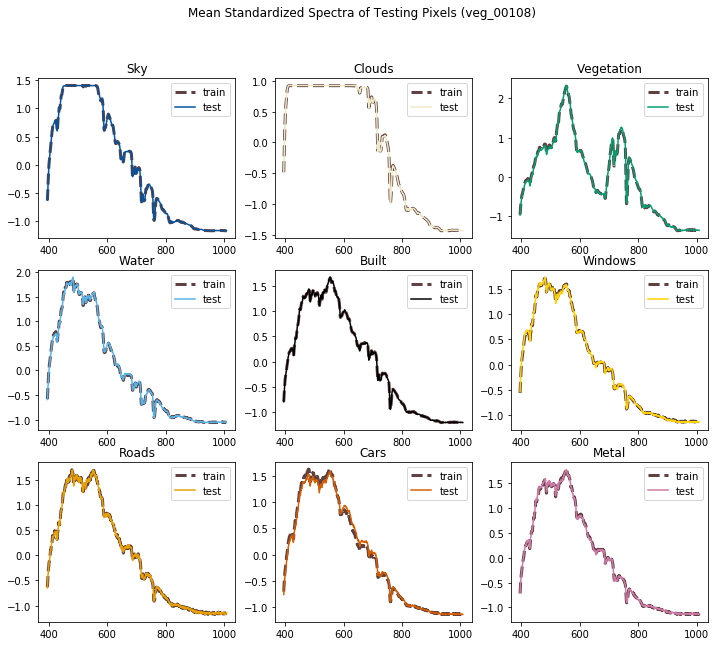

In [48]:
# plot mean spectra for testing set separately

import matplotlib.pyplot as plt
%matplotlib inline

f, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(12, 10))
plt.suptitle('Mean Standardized Spectra of Testing Pixels (veg_00108)')
ax1.plot(cube.waves, cube_sky_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=3, ls="dashed")
ax1.plot(cube.waves, cube_sky_test[:,:-2].mean(0), color=[0,0.32549,0.62353])
ax1.set_title("Sky")
ax1.legend(['train', 'test'], loc='upper right')
ax2.plot(cube.waves, cube_clouds_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=3, ls="dashed")
ax2.plot(cube.waves, cube_clouds_test[:,:-2].mean(0), color=[0.93333,0.9098,0.77255])
ax2.set_title("Clouds")
ax2.legend(['train', 'test'], loc='upper right')
ax3.plot(cube.waves, cube_veg_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=3, ls="dashed")
ax3.plot(cube.waves, cube_veg_test[:,:-2].mean(0), color=[0,0.61961,0.45098])
ax3.set_title("Vegetation")
ax3.legend(['train', 'test'], loc='upper right')
ax4.plot(cube.waves, cube_wtr_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=3, ls="dashed")
ax4.plot(cube.waves, cube_wtr_test[:,:-2].mean(0), color=[0.33725,0.70588,0.91373])
ax4.set_title("Water")
ax4.legend(['train', 'test'], loc='upper right')
ax5.plot(cube.waves, cube_blt_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=3, ls="dashed")
ax5.plot(cube.waves, cube_blt_test[:,:-2].mean(0), color=[0,0,0])
ax5.set_title("Built")
ax5.legend(['train', 'test'], loc='upper right')
ax6.plot(cube.waves, cube_windows_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=3, ls="dashed")
ax6.plot(cube.waves, cube_windows_test[:,:-2].mean(0), color=[1,0.82353,0])
ax6.set_title("Windows")
ax6.legend(['train', 'test'], loc='upper right')
ax7.plot(cube.waves, cube_rds_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=3, ls="dashed")
ax7.plot(cube.waves, cube_rds_test[:,:-2].mean(0), color=[0.90196,0.62353,0])
ax7.set_title("Roads")
ax7.legend(['train', 'test'], loc='upper right')
ax8.plot(cube.waves, cube_cars_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=3, ls="dashed")
ax8.plot(cube.waves, cube_cars_test[:,:-2].mean(0), color=[0.83529,0.36863,0])
ax8.set_title("Cars")
ax8.legend(['train', 'test'], loc='upper right')
ax9.plot(cube.waves, cube_mtl_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=3, ls="dashed")
ax9.plot(cube.waves, cube_mtl_test[:,:-2].mean(0), color=[0.8,0.47451,0.65490])
ax9.set_title("Metal")
ax9.legend(['train', 'test'], loc='upper right')
plt.show()
#f.savefig("./plots/CNN_spatial_train_108_3_mean_spectra_108_training_vs_testing_pixels_3x3.png")

#### Train CNN on 50%

In [49]:
cube_train_labels = np.array(cube_train_labels)
cube_test_labels = np.array(cube_test_labels)

In [50]:
import tensorflow as tf
from tensorflow import keras

cnn = keras.Sequential([keras.layers.Conv1D(16, kernel_size=(50), padding="same", 
                                            activation="relu", input_shape=(cube_specxy.shape[2], 1)),
                       keras.layers.MaxPooling1D((2), strides=2),
                        keras.layers.Conv1D(32, kernel_size=(50), padding="same", activation="relu"),
                        keras.layers.MaxPooling1D((2), strides=2),
                        keras.layers.Flatten(),
                        keras.layers.Dense(512, activation="relu"),
                        keras.layers.Dense(10, activation="softmax")])

cnn.compile(optimizer="adam", loss=["sparse_categorical_crossentropy"], metrics=['accuracy'])

cube_train2 = cube_train.reshape(cube_train.shape[0], cube_train.shape[1], 1)
cube_test2 = cube_test.reshape(cube_test.shape[0], cube_test.shape[1], 1)

CNNmodel = cnn.fit(cube_train2, cube_train_labels, validation_data=(cube_test2, cube_test_labels), 
                   epochs=100, batch_size=512)

Train on 1600 samples, validate on 1600 samples
Epoch 1/100
1600/1600 [==============================] - 1s 931us/sample - loss: 1.9652 - accuracy: 0.2506 - val_loss: 1.3455 - val_accuracy: 0.7331
Epoch 2/100
1600/1600 [==============================] - 1s 446us/sample - loss: 1.1859 - accuracy: 0.6719 - val_loss: 1.1019 - val_accuracy: 0.5831
Epoch 3/100
1600/1600 [==============================] - 1s 437us/sample - loss: 0.9731 - accuracy: 0.6275 - val_loss: 0.8080 - val_accuracy: 0.7019
Epoch 4/100
1600/1600 [==============================] - 1s 412us/sample - loss: 0.8099 - accuracy: 0.7100 - val_loss: 0.7727 - val_accuracy: 0.7475
Epoch 5/100
1600/1600 [==============================] - 1s 413us/sample - loss: 0.7983 - accuracy: 0.7381 - val_loss: 0.6394 - val_accuracy: 0.8156
Epoch 6/100
1600/1600 [==============================] - 1s 445us/sample - loss: 0.6756 - accuracy: 0.7688 - val_loss: 0.5939 - val_accuracy: 0.8313
Epoch 7/100
1600/1600 [==============================] - 1

<function matplotlib.pyplot.show(*args, **kw)>

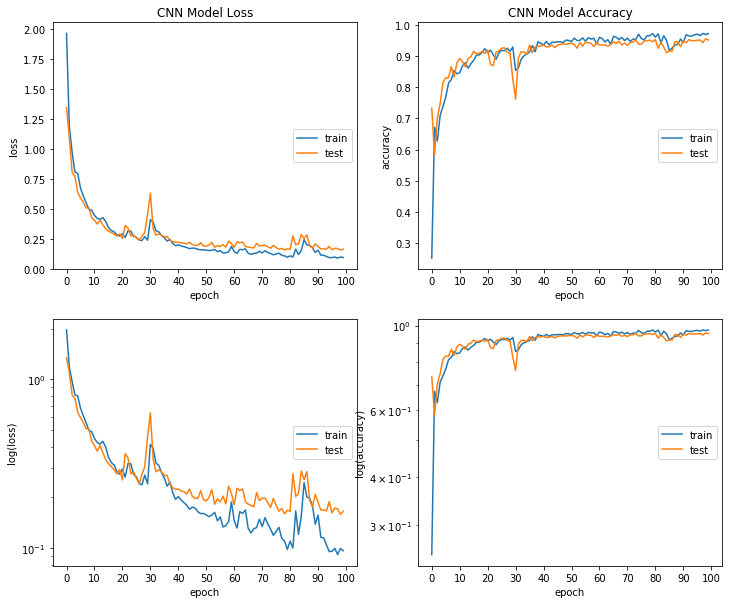

In [51]:
# summarize history of loss

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(12, 10))
ax1.plot(CNNmodel.history['loss'])
ax1.plot(CNNmodel.history['val_loss'])
ax1.set_title('CNN Model Loss')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.locator_params(nbins=13, axis='x')
ax1.legend(['train', 'test'], loc='center right')
ax2.plot(CNNmodel.history['accuracy'])
ax2.plot(CNNmodel.history['val_accuracy'])
ax2.set_title('CNN Model Accuracy')
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')
ax2.locator_params(nbins=12, axis='x')
ax2.legend(['train', 'test'], loc='center right')
ax3.plot(CNNmodel.history['loss'])
ax3.plot(CNNmodel.history['val_loss'])
ax3.set_ylabel('log(loss)')
ax3.set_xlabel('epoch')
ax3.locator_params(nbins=13, axis='x')
ax3.legend(['train', 'test'], loc='center right')
ax3.set_yscale('log')
ax4.plot(CNNmodel.history['accuracy'])
ax4.plot(CNNmodel.history['val_accuracy'])
ax4.set_ylabel('log(accuracy)')
ax4.set_xlabel('epoch')
ax4.locator_params(nbins=12, axis='x')
ax4.legend(['train', 'test'], loc='center right')
ax4.set_yscale('log')
plt.show
#f.savefig("./plots/CNN_spatial_train_108_5_CNN_loss_accuracy_vs_epoch.png")

In [52]:
import tensorflow as tf
from tensorflow import keras

cnn = keras.Sequential([keras.layers.Conv1D(16, kernel_size=(50), padding="same", 
                                            activation="relu", input_shape=(cube_specxy.shape[2], 1)),
                       keras.layers.MaxPooling1D((2), strides=2),
                        keras.layers.Conv1D(32, kernel_size=(50), padding="same", activation="relu"),
                        keras.layers.MaxPooling1D((2), strides=2),
                        keras.layers.Flatten(),
                        keras.layers.Dense(512, activation="relu"),
                        keras.layers.Dense(10, activation="softmax")])

cnn.compile(optimizer="adam", loss=["sparse_categorical_crossentropy"], metrics=['accuracy'])

cube_train2 = cube_train.reshape(cube_train.shape[0], cube_train.shape[1], 1)
cube_test2 = cube_test.reshape(cube_test.shape[0], cube_test.shape[1], 1)

CNNmodel = cnn.fit(cube_train2, cube_train_labels, validation_data=(cube_test2, cube_test_labels), 
                   epochs=35, batch_size=512)

Train on 1600 samples, validate on 1600 samples
Epoch 1/35
1600/1600 [==============================] - 2s 1ms/sample - loss: 1.8880 - accuracy: 0.2944 - val_loss: 1.1710 - val_accuracy: 0.7356
Epoch 2/35
1600/1600 [==============================] - 1s 440us/sample - loss: 1.1029 - accuracy: 0.6988 - val_loss: 0.9316 - val_accuracy: 0.7944
Epoch 3/35
1600/1600 [==============================] - 1s 481us/sample - loss: 0.8631 - accuracy: 0.7487 - val_loss: 0.7246 - val_accuracy: 0.7469
Epoch 4/35
1600/1600 [==============================] - 1s 487us/sample - loss: 0.7165 - accuracy: 0.7956 - val_loss: 0.6586 - val_accuracy: 0.8194
Epoch 5/35
1600/1600 [==============================] - 1s 444us/sample - loss: 0.6377 - accuracy: 0.8256 - val_loss: 0.6966 - val_accuracy: 0.7987
Epoch 6/35
1600/1600 [==============================] - 1s 434us/sample - loss: 0.6662 - accuracy: 0.8012 - val_loss: 0.5365 - val_accuracy: 0.8163
Epoch 7/35
1600/1600 [==============================] - 1s 420us/s

In [53]:
# model accuracy on training and testing sets

train_loss_50, train_acc_50 = cnn.evaluate(cube_train2, cube_train_labels)
test_loss_50, test_acc_50 = cnn.evaluate(cube_test2, cube_test_labels)

print(train_acc_50, test_acc_50)

1600/1600 [==============================] - 1s 564us/sample - loss: 0.2313 - accuracy: 0.9175
0.920625 0.9175


### Predict pixel classification on veg_00108 trained with 50-50 split

In [54]:
# classify entire binned cube
import time
start_time = time.time()

cube_specxy_2d_1 = cube_specxy_2d.reshape(cube_specxy_2d.shape[0], cube_specxy_2d.shape[1], 1)
predictCube = cnn.predict_classes(cube_specxy_2d_1)

elapsed_time = time.time() - start_time
print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

00:09:09


In [55]:
predictCube_reshape = predictCube.reshape(cube_specxy.shape[0], cube_specxy.shape[1])

In [56]:
veg_by_row = np.zeros(cube_sub.shape[1])
for row in range(0, cube_sub.shape[1]):
    veg_by_row[row] = np.count_nonzero(predictCube_reshape[row,:] == 2)

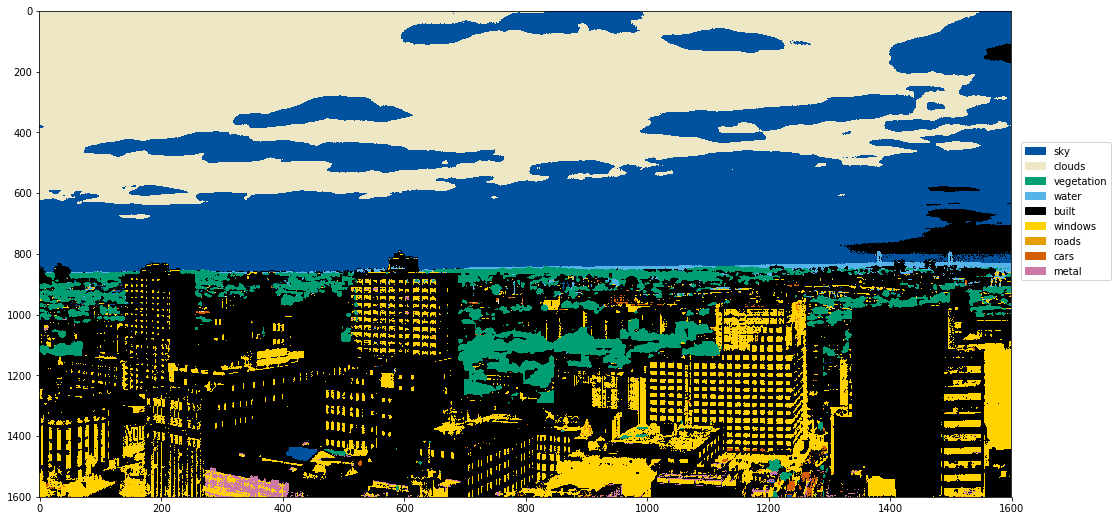

In [57]:
import matplotlib.pyplot as plt
import matplotlib.colors as ListedColorMap
import matplotlib.patches as mpatches
from matplotlib.ticker import NullFormatter
%matplotlib inline

cmap = {0:[0,0.32549,0.62353,1], 1:[0.93333,0.9098,0.77255,1], 2:[0,0.61961,0.45098,1],  3:[0.33725,0.70588,0.91373,1],
        4:[0,0,0,1], 5:[1,0.82353,0,1], 6:[0.90196,0.62353,0,1], 7:[0.83529,0.36863,0,1],
        8:[0.8,0.47451,0.65490,1]}
labels = {0:'sky', 1:'clouds', 2:'vegetation', 3:'water', 4:'built',
          5:'windows', 6:'roads', 7:'cars', 8:'metal'}
arrayShow = np.array([[cmap[i] for i in j] for j in predictCube_reshape])
patches = [mpatches.Patch(color=cmap[i], label=labels[i]) for i in cmap]

fig = plt.figure(figsize=(15,15))
ax = fig.add_axes([0.1,0.1,0.9,0.9])
ax.tick_params(labelsize=10)
ax.imshow(arrayShow, aspect=0.5)
lgd = ax.legend(handles=patches, bbox_to_anchor=(1,0.75), loc='upper left', borderaxespad=1.0, prop={'size':10}, ncol=1)
plt.show()
#fig.savefig("./plots/CNN_spatial_train_108_6_108_predict_map.png", bbox_extra_artists=(lgd,), bbox_inches='tight')

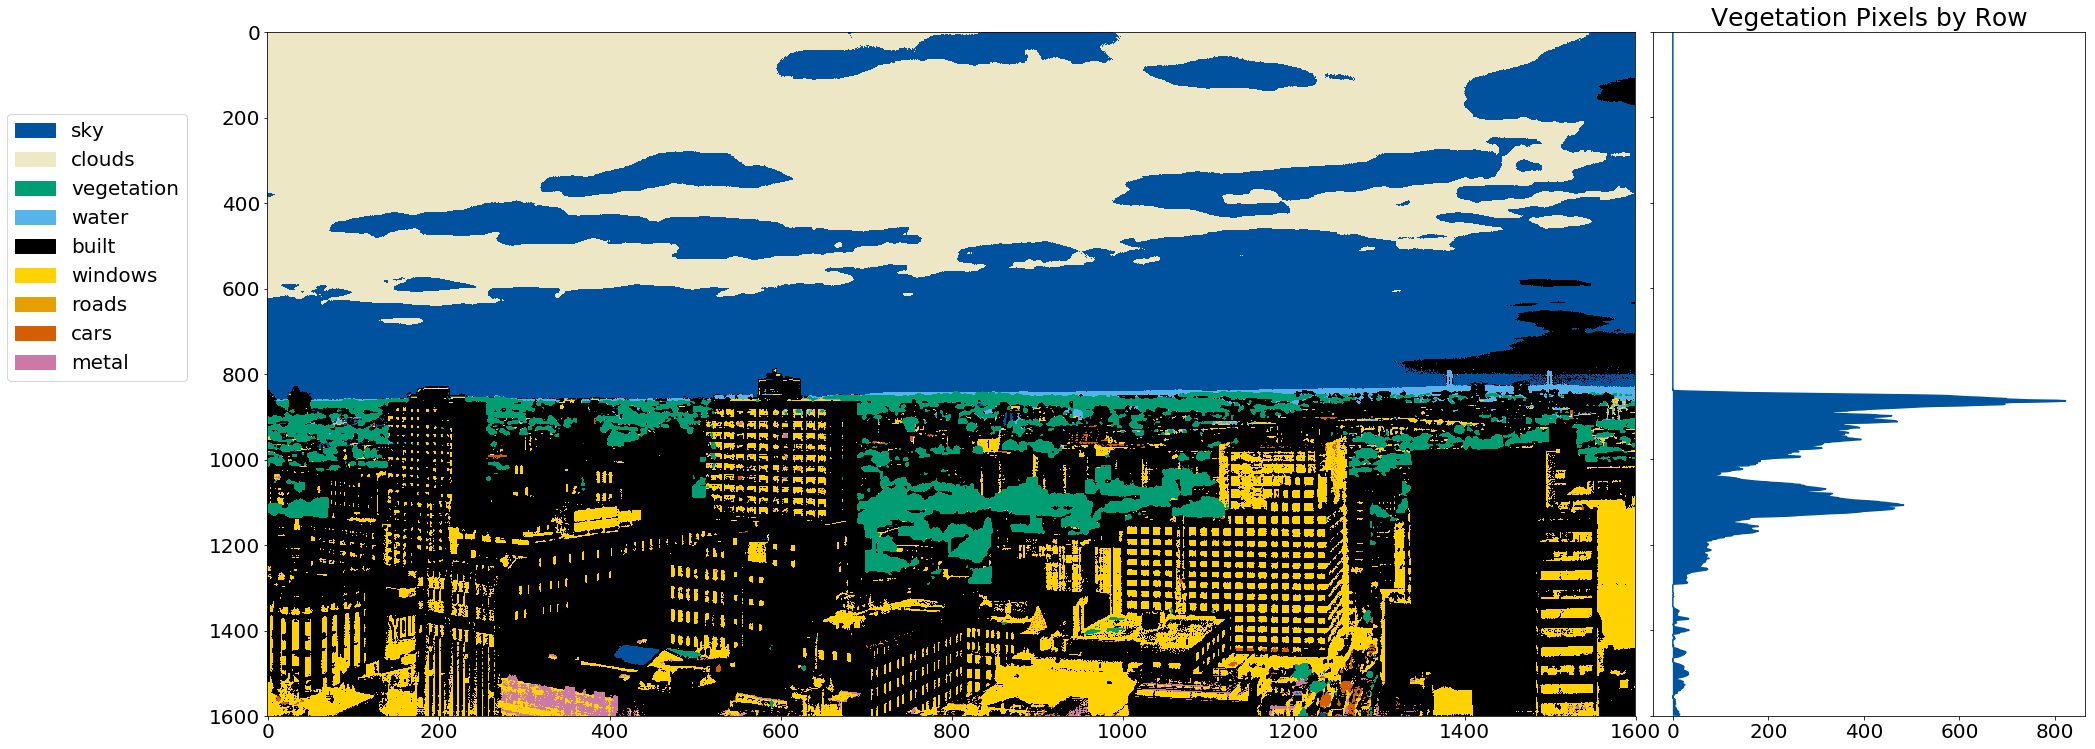

In [58]:
import matplotlib.pyplot as plt
import matplotlib.colors as ListedColorMap
import matplotlib.patches as mpatches
from matplotlib.ticker import NullFormatter
%matplotlib inline

cmap = {0:[0,0.32549,0.62353,1], 1:[0.93333,0.9098,0.77255,1], 2:[0,0.61961,0.45098,1],  3:[0.33725,0.70588,0.91373,1],
        4:[0,0,0,1], 5:[1,0.82353,0,1], 6:[0.90196,0.62353,0,1], 7:[0.83529,0.36863,0,1],
        8:[0.8,0.47451,0.65490,1]}
labels = {0:'sky', 1:'clouds', 2:'vegetation', 3:'water', 4:'built',
          5:'windows', 6:'roads', 7:'cars', 8:'metal'}
arrayShow = np.array([[cmap[i] for i in j] for j in predictCube_reshape])
patches = [mpatches.Patch(color=cmap[i], label=labels[i]) for i in cmap]
#fig, ax = plt.subplots(figsize = (20,10))

fig = plt.figure(1, figsize=(30,10))
axImage = plt.axes([0.1,0.1,0.85,0.95])
axHist = plt.axes([0.85,0.1,0.2,0.95])
axHist.yaxis.set_major_formatter(NullFormatter())
axImage.tick_params(labelsize=20)
axHist.tick_params(labelsize=20)
axImage.imshow(arrayShow, aspect=0.5)
axHist.plot(veg_by_row, np.arange(0,cube_sub.shape[1]), color=[0.0,0.33,0.62])
axHist.fill_between(veg_by_row, np.arange(0,cube_sub.shape[1]), cube_sub.shape[1], facecolor=[0.0,0.33,0.62])
axHist.set_ylim(cube_sub.shape[1], 0)
axHist.set(title='Vegetation Pixels by Row')
axHist.title.set_fontsize(25)
lgd = axImage.legend(handles=patches, bbox_to_anchor=(0,0.5), loc=2, borderaxespad=-13.0, prop={'size':20}, ncol=1)
plt.show()
#fig.savefig("./plots/CNN_spatial_train_108_6_108_predict_map_veg_by_row.png", bbox_extra_artists=(lgd,), bbox_inches='tight')

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.6/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


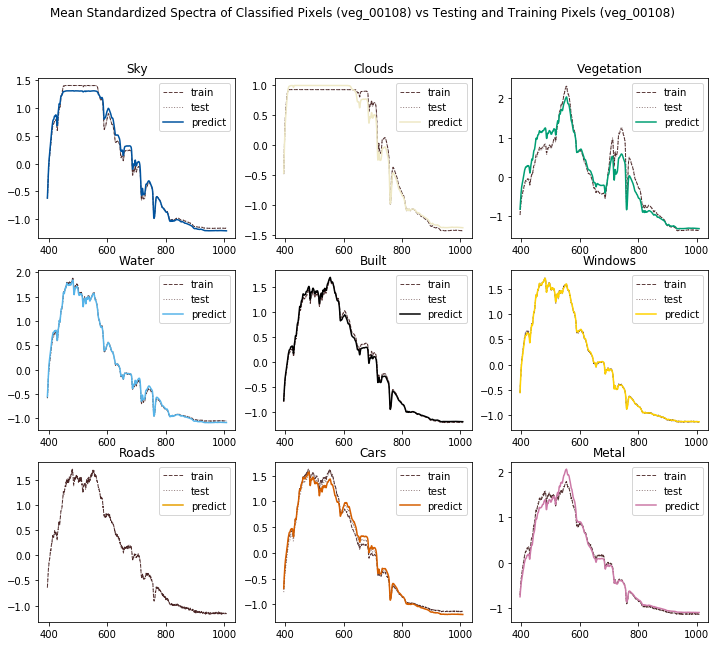

In [59]:
# plot mean spectra for testing set separately

import matplotlib.pyplot as plt
%matplotlib inline

f, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(12, 10))
plt.suptitle('Mean Standardized Spectra of Classified Pixels (veg_00108) vs Testing and Training Pixels (veg_00108)')
ax1.plot(cube.waves, cube_sky_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=1, ls="dashed")
ax1.plot(cube.waves, cube_sky_test[:,:-2].mean(0), color=[0.170,0,0,0.5], lw=1, ls="dotted")
ax1.plot(cube.waves, cube_standard[np.where(predictCube == 0)[0]].mean(0), color=[0,0.32549,0.62353])
ax1.set_title("Sky")
ax1.legend(['train', 'test', 'predict'], loc='upper right')
ax2.plot(cube.waves, cube_clouds_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=1, ls="dashed")
ax2.plot(cube.waves, cube_clouds_test[:,:-2].mean(0), color=[0.170,0,0,0.5], lw=1, ls="dotted")
ax2.plot(cube.waves, cube_standard[np.where(predictCube == 1)[0]].mean(0), color=[0.93333,0.9098,0.77255])
ax2.set_title("Clouds")
ax2.legend(['train', 'test', 'predict'], loc='upper right')
ax3.plot(cube.waves, cube_veg_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=1, ls="dashed")
ax3.plot(cube.waves, cube_veg_test[:,:-2].mean(0), color=[0.170,0,0,0.5], lw=1, ls="dotted")
ax3.plot(cube.waves, cube_standard[np.where(predictCube == 2)[0]].mean(0), color=[0,0.61961,0.45098])
ax3.set_title("Vegetation")
ax3.legend(['train', 'test', 'predict'], loc='upper right')
ax4.plot(cube.waves, cube_wtr_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=1, ls="dashed")
ax4.plot(cube.waves, cube_wtr_test[:,:-2].mean(0), color=[0.170,0,0,0.5], lw=1, ls="dotted")
ax4.plot(cube.waves, cube_standard[np.where(predictCube == 3)[0]].mean(0), color=[0.33725,0.70588,0.91373])
ax4.set_title("Water")
ax4.legend(['train', 'test', 'predict'], loc='upper right')
ax5.plot(cube.waves, cube_blt_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=1, ls="dashed")
ax5.plot(cube.waves, cube_blt_test[:,:-2].mean(0), color=[0.170,0,0,0.5], lw=1, ls="dotted")
ax5.plot(cube.waves, cube_standard[np.where(predictCube == 4)[0]].mean(0), color=[0,0,0])
ax5.set_title("Built")
ax5.legend(['train', 'test', 'predict'], loc='upper right')
ax6.plot(cube.waves, cube_windows_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=1, ls="dashed")
ax6.plot(cube.waves, cube_windows_test[:,:-2].mean(0), color=[0.170,0,0,0.5], lw=1, ls="dotted")
ax6.plot(cube.waves, cube_standard[np.where(predictCube == 5)[0]].mean(0), color=[1,0.82353,0])
ax6.set_title("Windows")
ax6.legend(['train', 'test', 'predict'], loc='upper right')
ax7.plot(cube.waves, cube_rds_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=1, ls="dashed")
ax7.plot(cube.waves, cube_rds_test[:,:-2].mean(0), color=[0.170,0,0,0.5], lw=1, ls="dotted")
ax7.plot(cube.waves, cube_standard[np.where(predictCube == 6)[0]].mean(0), color=[0.90196,0.62353,0])
ax7.set_title("Roads")
ax7.legend(['train', 'test', 'predict'], loc='upper right')
ax8.plot(cube.waves, cube_cars_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=1, ls="dashed")
ax8.plot(cube.waves, cube_cars_test[:,:-2].mean(0), color=[0.170,0,0,0.5], lw=1, ls="dotted")
ax8.plot(cube.waves, cube_standard[np.where(predictCube == 7)[0]].mean(0), color=[0.83529,0.36863,0])
ax8.set_title("Cars")
ax8.legend(['train', 'test', 'predict'], loc='upper right')
ax9.plot(cube.waves, cube_mtl_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=1, ls="dashed")
ax9.plot(cube.waves, cube_mtl_test[:,:-2].mean(0), color=[0.170,0,0,0.5], lw=1, ls="dotted")
ax9.plot(cube.waves, cube_standard[np.where(predictCube == 8)[0]].mean(0), color=[0.8,0.47451,0.65490])
ax9.set_title("Metal")
ax9.legend(['train', 'test', 'predict'], loc='upper right')
plt.show()
#f.savefig("./plots/CNN_spatial_train_108_7_108_mean_spectra_train_test_predict_3x3.png")

### Evaluation Metrics 50-50 split

In [60]:
labels_pred_sky = predictCube_reshape[sky_coords[:,0], sky_coords[:,1]]
labels_pred_clouds = predictCube_reshape[clouds_coords[:,0], clouds_coords[:,1]]
labels_pred_veg = predictCube_reshape[veg_coords[:,0], veg_coords[:,1]]
labels_pred_wtr = predictCube_reshape[wtr_coords[:,0], wtr_coords[:,1]]
labels_pred_blt = predictCube_reshape[blt_coords[:,0], blt_coords[:,1]]
labels_pred_windows = predictCube_reshape[windows_coords[:,0], windows_coords[:,1]]
labels_pred_rds = predictCube_reshape[rds_coords[:,0], rds_coords[:,1]]
labels_pred_cars = predictCube_reshape[cars_coords[:,0], cars_coords[:,1]]
labels_pred_mtl = predictCube_reshape[mtl_coords[:,0], mtl_coords[:,1]]

labels_pred = np.concatenate((labels_pred_sky, labels_pred_clouds, labels_pred_veg, labels_pred_wtr, 
                             labels_pred_blt, labels_pred_windows, labels_pred_rds, labels_pred_cars, labels_pred_mtl))

In [61]:
labels_true_sky = np.full((sky_coords.shape[0]), 0)
labels_true_clouds = np.full((clouds_coords.shape[0]), 1)
labels_true_veg = np.full((veg_coords.shape[0]), 2)
labels_true_wtr = np.full((wtr_coords.shape[0]), 3)
labels_true_blt = np.full((blt_coords.shape[0]), 4)
labels_true_windows = np.full((windows_coords.shape[0]), 5)
labels_true_rds = np.full((rds_coords.shape[0]), 6)
labels_true_cars = np.full((cars_coords.shape[0]), 7)
labels_true_mtl = np.full((mtl_coords.shape[0]), 8)

labels_true = np.concatenate((labels_true_sky, labels_true_clouds, labels_true_veg, labels_true_wtr, 
                             labels_true_blt, labels_true_windows, labels_true_rds, labels_true_cars, labels_true_mtl))

In [62]:
print(labels_pred.shape)
print(labels_true.shape)

(3200,)
(3200,)


In [63]:
from sklearn import metrics

print("Confusion Matrix")
print(metrics.confusion_matrix(labels_true, labels_pred))

print("")
print("Accuracy Score")
print(metrics.accuracy_score(labels_true, labels_pred))

target_names = ['sky', 'clouds', 'vegetation', 'water', 'built', 'windows', 'roads', 'cars', 'metal']
print("")
print("Classification Report")
print(metrics.classification_report(labels_true, labels_pred, target_names=target_names))

Confusion Matrix
[[299   1   0   0   0   0   0   0   0]
 [  0 500   0   0   0   0   0   0   0]
 [  0   0 595   1   4   0   0   0   0]
 [  0   0   0  46   4   0   0   0   0]
 [  0   0   2   1 998  18   0   1   0]
 [  0   0   0   0  44 456   0   0   0]
 [  0   0   0   0  28   1   0   1   0]
 [  7   0   0   0  52   7   0  34   0]
 [  0   0   0   0  71  16   0   0  13]]

Accuracy Score
0.9190625

Classification Report
             precision    recall  f1-score   support

        sky       0.98      1.00      0.99       300
     clouds       1.00      1.00      1.00       500
 vegetation       1.00      0.99      0.99       600
      water       0.96      0.92      0.94        50
      built       0.83      0.98      0.90      1020
    windows       0.92      0.91      0.91       500
      roads       0.00      0.00      0.00        30
       cars       0.94      0.34      0.50       100
      metal       1.00      0.13      0.23       100

avg / total       0.92      0.92      0.90      32

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [64]:
#f = open("./metrics/CNN_spatial_train_108_test_108_binned_848_metrics.txt", "w")
#f.write("Confusion Matrix")
#f.write('\n')
#f.write(str(metrics.confusion_matrix(labels_true, labels_pred)))
#f.write('\n')
#f.write('\n')
#f.write("Accuracy Score")
#f.write('\n')
#f.write(str(metrics.accuracy_score(labels_true, labels_pred)))
#target_names = ['sky', 'clouds', 'vegetation', 'water', 'built', 'windows', 'roads', 'cars', 'metal']
#f.write('\n')
#f.write('\n')
#f.write("Classification Report")
#f.write('\n')
#f.write(metrics.classification_report(labels_true, labels_pred, target_names=target_names))
#f.close()

In [65]:
sky_dict, sky_dict_norm = kmeans_test_dictionary(predictCube_reshape, sky_coords, 9)
clouds_dict, cloud_dict_norm = kmeans_test_dictionary(predictCube_reshape, clouds_coords, 9)
veg_dict, veg_dict_norm = kmeans_test_dictionary(predictCube_reshape, veg_coords, 9)
wtr_dict, wtr_dict_norm = kmeans_test_dictionary(predictCube_reshape, wtr_coords, 9)
blt_dict, blt_dict_norm = kmeans_test_dictionary(predictCube_reshape, blt_coords, 9)
windows_dict, windows_dict_norm = kmeans_test_dictionary(predictCube_reshape, windows_coords, 9)
rds_dict, rds_dict_norm = kmeans_test_dictionary(predictCube_reshape, rds_coords, 9)
cars_dict, cars_dict_norm = kmeans_test_dictionary(predictCube_reshape, cars_coords, 9)
mtl_dict, mtl_dict_norm = kmeans_test_dictionary(predictCube_reshape, mtl_coords, 9)

df_test = kmeans_test_dataframe(sky_dict, clouds_dict, veg_dict, wtr_dict,
                                blt_dict, windows_dict, rds_dict, cars_dict, mtl_dict)
print(df_test.transpose())
df_test_norm = kmeans_test_dataframe(sky_dict, clouds_dict, veg_dict, wtr_dict,
                                     blt_dict, windows_dict, rds_dict, cars_dict, mtl_dict)
#print("")
#print(df_test_norm.transpose())

              0    1    2   3    4    5  6   7   8
sky         299    1    0   0    0    0  0   0   0
clouds        0  500    0   0    0    0  0   0   0
vegetation    0    0  595   1    4    0  0   0   0
water         0    0    0  46    4    0  0   0   0
built         0    0    2   1  998   18  0   1   0
windows       0    0    0   0   44  456  0   0   0
roads         0    0    0   0   28    1  0   1   0
cars          7    0    0   0   52    7  0  34   0
metal         0    0    0   0   71   16  0   0  13


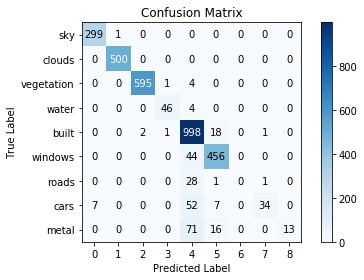

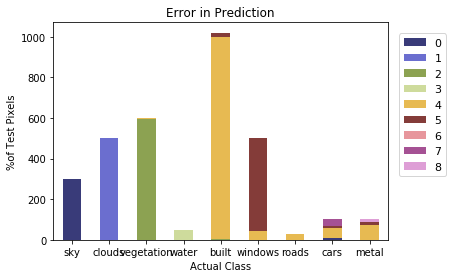

In [66]:
plot_confusion_matrix(df_test, norm=False)
#plot_confusion_matrix(df_test_norm, norm=True)
plot_test_result(df_test_norm)

## Split classified pixels into 20% training and 80% testing sets

In [67]:
train_ratio = 0.2

import random

# sky coordinates
sky_ind = np.arange(sky_coords.shape[0])
random.Random(3).shuffle(sky_ind)
lim_ind = int(len(sky_ind)*train_ratio)
sky_train_ind = sky_ind[:lim_ind]
sky_test_ind = sky_ind[lim_ind:]
print("sky %d %d" % (len(sky_train_ind), len(sky_test_ind)))

# clouds coordinates
clouds_ind = np.arange(clouds_coords.shape[0])
random.Random(3).shuffle(clouds_ind)
lim_ind = int(len(clouds_ind)*train_ratio)
clouds_train_ind = clouds_ind[:lim_ind]
clouds_test_ind = clouds_ind[lim_ind:]
print("clouds %d %d" % (len(clouds_train_ind), len(clouds_test_ind)))

# vegetation coordinates
veg_ind = np.arange(veg_coords.shape[0])
random.Random(3).shuffle(veg_ind)
lim_ind = int(len(veg_ind)*train_ratio)
veg_train_ind = veg_ind[:lim_ind]
veg_test_ind = veg_ind[lim_ind:]
print("vegetation %d %d" % (len(veg_train_ind), len(veg_test_ind)))

# water coordinates
wtr_ind = np.arange(wtr_coords.shape[0])
random.Random(3).shuffle(wtr_ind)
lim_ind = int(len(wtr_ind)*train_ratio)
wtr_train_ind = wtr_ind[:lim_ind]
wtr_test_ind = wtr_ind[lim_ind:]
print("water %d %d" % (len(wtr_train_ind), len(wtr_test_ind)))

# built coordinates
blt_ind = np.arange(blt_coords.shape[0])
random.Random(3).shuffle(blt_ind)
lim_ind = int(len(blt_ind)*train_ratio)
blt_train_ind = blt_ind[:lim_ind]
blt_test_ind = blt_ind[lim_ind:]
print("built %d %d" % (len(blt_train_ind), len(blt_test_ind)))

# windows coordinates
windows_ind = np.arange(windows_coords.shape[0])
random.Random(3).shuffle(windows_ind)
lim_ind = int(len(windows_ind)*train_ratio)
windows_train_ind = windows_ind[:lim_ind]
windows_test_ind = windows_ind[lim_ind:]
print("windows %d %d" % (len(windows_train_ind), len(windows_test_ind)))

# roads coordinates
rds_ind = np.arange(rds_coords.shape[0])
random.Random(3).shuffle(rds_ind)
lim_ind = int(len(rds_ind)*train_ratio)
rds_train_ind = rds_ind[:lim_ind]
rds_test_ind = rds_ind[lim_ind:]
print("roads %d %d" % (len(rds_train_ind), len(rds_test_ind)))

# cars coordinates
cars_ind = np.arange(cars_coords.shape[0])
random.Random(3).shuffle(cars_ind)
lim_ind = int(len(cars_ind)*train_ratio)
cars_train_ind = cars_ind[:lim_ind]
cars_test_ind = cars_ind[lim_ind:]
print("cars %d %d" % (len(cars_train_ind), len(cars_test_ind)))

# metal coordinates
mtl_ind = np.arange(mtl_coords.shape[0])
random.Random(3).shuffle(mtl_ind)
lim_ind = int(len(mtl_ind)*train_ratio)
mtl_train_ind = mtl_ind[:lim_ind]
mtl_test_ind = mtl_ind[lim_ind:]
print("metal %d %d" % (len(mtl_train_ind), len(mtl_test_ind)))

sky 60 240
clouds 100 400
vegetation 120 480
water 10 40
built 204 816
windows 100 400
roads 6 24
cars 20 80
metal 20 80


In [68]:
cube_sky_train = cube_specxy[sky_coords[sky_train_ind[:], 0], sky_coords[sky_train_ind[:], 1], :]
cube_sky_test = cube_specxy[sky_coords[sky_test_ind[:], 0], sky_coords[sky_test_ind[:], 1], :]
print("sky ", cube_sky_train.shape, cube_sky_test.shape)

cube_clouds_train = cube_specxy[clouds_coords[clouds_train_ind[:], 0], clouds_coords[clouds_train_ind[:], 1], :]
cube_clouds_test = cube_specxy[clouds_coords[clouds_test_ind[:], 0], clouds_coords[clouds_test_ind[:], 1], :]
print("clouds ", cube_clouds_train.shape, cube_clouds_test.shape)

cube_veg_train = cube_specxy[veg_coords[veg_train_ind[:], 0], veg_coords[veg_train_ind[:], 1], :]
cube_veg_test = cube_specxy[veg_coords[veg_test_ind[:], 0], veg_coords[veg_test_ind[:], 1], :]
print("vegetation ", cube_veg_train.shape, cube_veg_test.shape)

cube_wtr_train = cube_specxy[wtr_coords[wtr_train_ind[:], 0], wtr_coords[wtr_train_ind[:], 1], :]
cube_wtr_test = cube_specxy[wtr_coords[wtr_test_ind[:], 0], wtr_coords[wtr_test_ind[:], 1], :]
print("water ", cube_wtr_train.shape, cube_wtr_test.shape)

cube_blt_train = cube_specxy[blt_coords[blt_train_ind[:], 0], blt_coords[blt_train_ind[:], 1], :]
cube_blt_test = cube_specxy[blt_coords[blt_test_ind[:], 0], blt_coords[blt_test_ind[:], 1], :]
print("built ", cube_blt_train.shape, cube_blt_test.shape)

cube_windows_train = cube_specxy[windows_coords[windows_train_ind[:], 0], windows_coords[windows_train_ind[:], 1], :]
cube_windows_test = cube_specxy[windows_coords[windows_test_ind[:], 0], windows_coords[windows_test_ind[:], 1], :]
print("windows ", cube_windows_train.shape, cube_windows_test.shape)

cube_rds_train = cube_specxy[rds_coords[rds_train_ind[:], 0], rds_coords[rds_train_ind[:], 1], :]
cube_rds_test = cube_specxy[rds_coords[rds_test_ind[:], 0], rds_coords[rds_test_ind[:], 1], :]
print("roads ", cube_rds_train.shape, cube_rds_test.shape)

cube_cars_train = cube_specxy[cars_coords[cars_train_ind[:], 0], cars_coords[cars_train_ind[:], 1], :]
cube_cars_test = cube_specxy[cars_coords[cars_test_ind[:], 0], cars_coords[cars_test_ind[:], 1], :]
print("cars ", cube_cars_train.shape, cube_cars_test.shape)

cube_mtl_train = cube_specxy[mtl_coords[mtl_train_ind[:], 0], mtl_coords[mtl_train_ind[:], 1], :]
cube_mtl_test = cube_specxy[mtl_coords[mtl_test_ind[:], 0], mtl_coords[mtl_test_ind[:], 1], :]
print("metal ", cube_mtl_train.shape, cube_mtl_test.shape)

sky  (60, 850) (240, 850)
clouds  (100, 850) (400, 850)
vegetation  (120, 850) (480, 850)
water  (10, 850) (40, 850)
built  (204, 850) (816, 850)
windows  (100, 850) (400, 850)
roads  (6, 850) (24, 850)
cars  (20, 850) (80, 850)
metal  (20, 850) (80, 850)


In [69]:
# concatenate training and testing sets and create index arrays

cube_train = np.concatenate((cube_sky_train, cube_clouds_train, cube_veg_train, cube_wtr_train, cube_blt_train,
                            cube_windows_train, cube_rds_train, cube_cars_train, cube_mtl_train), axis=0)
cube_train_labels = [0]*cube_sky_train.shape[0] + [1]*cube_clouds_train.shape[0] \
                    + [2]*cube_veg_train.shape[0] + [3]*cube_wtr_train.shape[0] \
                    + [4]*cube_blt_train.shape[0] + [5]*cube_windows_train.shape[0] \
                    + [6]*cube_rds_train.shape[0] + [7]*cube_cars_train.shape[0] + [8]*cube_mtl_train.shape[0]

print(cube_train.shape)

cube_test = np.concatenate((cube_sky_test, cube_clouds_test, cube_veg_test, cube_wtr_test, cube_blt_test,
                            cube_windows_test, cube_rds_test, cube_cars_test, cube_mtl_test), axis=0)
cube_test_labels = [0]*cube_sky_test.shape[0] + [1]*cube_clouds_test.shape[0] \
                    + [2]*cube_veg_test.shape[0] + [3]*cube_wtr_test.shape[0] \
                    + [4]*cube_blt_test.shape[0] + [5]*cube_windows_test.shape[0] \
                    + [6]*cube_rds_test.shape[0] + [7]*cube_cars_test.shape[0] + [8]*cube_mtl_test.shape[0]

print(cube_test.shape)

(640, 850)
(2560, 850)


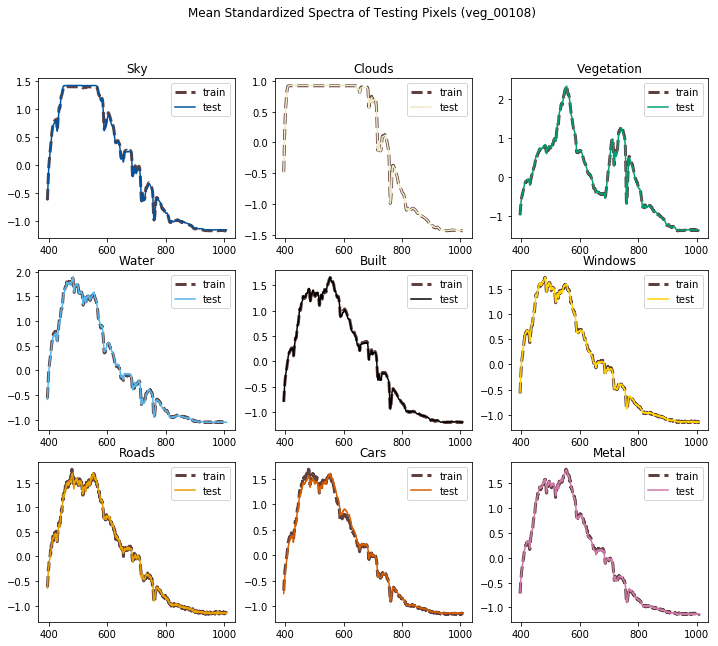

In [70]:
# plot mean spectra for testing set separately

import matplotlib.pyplot as plt
%matplotlib inline

f, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(12, 10))
plt.suptitle('Mean Standardized Spectra of Testing Pixels (veg_00108)')
ax1.plot(cube.waves, cube_sky_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=3, ls="dashed")
ax1.plot(cube.waves, cube_sky_test[:,:-2].mean(0), color=[0,0.32549,0.62353])
ax1.set_title("Sky")
ax1.legend(['train', 'test'], loc='upper right')
ax2.plot(cube.waves, cube_clouds_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=3, ls="dashed")
ax2.plot(cube.waves, cube_clouds_test[:,:-2].mean(0), color=[0.93333,0.9098,0.77255])
ax2.set_title("Clouds")
ax2.legend(['train', 'test'], loc='upper right')
ax3.plot(cube.waves, cube_veg_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=3, ls="dashed")
ax3.plot(cube.waves, cube_veg_test[:,:-2].mean(0), color=[0,0.61961,0.45098])
ax3.set_title("Vegetation")
ax3.legend(['train', 'test'], loc='upper right')
ax4.plot(cube.waves, cube_wtr_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=3, ls="dashed")
ax4.plot(cube.waves, cube_wtr_test[:,:-2].mean(0), color=[0.33725,0.70588,0.91373])
ax4.set_title("Water")
ax4.legend(['train', 'test'], loc='upper right')
ax5.plot(cube.waves, cube_blt_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=3, ls="dashed")
ax5.plot(cube.waves, cube_blt_test[:,:-2].mean(0), color=[0,0,0])
ax5.set_title("Built")
ax5.legend(['train', 'test'], loc='upper right')
ax6.plot(cube.waves, cube_windows_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=3, ls="dashed")
ax6.plot(cube.waves, cube_windows_test[:,:-2].mean(0), color=[1,0.82353,0])
ax6.set_title("Windows")
ax6.legend(['train', 'test'], loc='upper right')
ax7.plot(cube.waves, cube_rds_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=3, ls="dashed")
ax7.plot(cube.waves, cube_rds_test[:,:-2].mean(0), color=[0.90196,0.62353,0])
ax7.set_title("Roads")
ax7.legend(['train', 'test'], loc='upper right')
ax8.plot(cube.waves, cube_cars_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=3, ls="dashed")
ax8.plot(cube.waves, cube_cars_test[:,:-2].mean(0), color=[0.83529,0.36863,0])
ax8.set_title("Cars")
ax8.legend(['train', 'test'], loc='upper right')
ax9.plot(cube.waves, cube_mtl_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=3, ls="dashed")
ax9.plot(cube.waves, cube_mtl_test[:,:-2].mean(0), color=[0.8,0.47451,0.65490])
ax9.set_title("Metal")
ax9.legend(['train', 'test'], loc='upper right')
plt.show()
#f.savefig("./plots/CNN_spatial_train_108_3_mean_spectra_108_training_vs_testing_pixels_3x3.png")

#### Train CNN on 20%

In [71]:
cube_train_labels = np.array(cube_train_labels)
cube_test_labels = np.array(cube_test_labels)

In [72]:
import tensorflow as tf
from tensorflow import keras

cnn = keras.Sequential([keras.layers.Conv1D(16, kernel_size=(50), padding="same", 
                                            activation="relu", input_shape=(cube_specxy.shape[2], 1)),
                       keras.layers.MaxPooling1D((2), strides=2),
                        keras.layers.Conv1D(32, kernel_size=(50), padding="same", activation="relu"),
                        keras.layers.MaxPooling1D((2), strides=2),
                        keras.layers.Flatten(),
                        keras.layers.Dense(512, activation="relu"),
                        keras.layers.Dense(10, activation="softmax")])

cnn.compile(optimizer="adam", loss=["sparse_categorical_crossentropy"], metrics=['accuracy'])

cube_train2 = cube_train.reshape(cube_train.shape[0], cube_train.shape[1], 1)
cube_test2 = cube_test.reshape(cube_test.shape[0], cube_test.shape[1], 1)

CNNmodel = cnn.fit(cube_train2, cube_train_labels, validation_data=(cube_test2, cube_test_labels), 
                   epochs=100, batch_size=512)

Train on 640 samples, validate on 2560 samples
Epoch 1/100
640/640 [==============================] - 1s 2ms/sample - loss: 2.1578 - accuracy: 0.3391 - val_loss: 1.6508 - val_accuracy: 0.4949
Epoch 2/100
640/640 [==============================] - 0s 670us/sample - loss: 1.6012 - accuracy: 0.5125 - val_loss: 1.2060 - val_accuracy: 0.6410
Epoch 3/100
640/640 [==============================] - 0s 641us/sample - loss: 1.1983 - accuracy: 0.6406 - val_loss: 1.0782 - val_accuracy: 0.6336
Epoch 4/100
640/640 [==============================] - 0s 602us/sample - loss: 1.0571 - accuracy: 0.6531 - val_loss: 0.8846 - val_accuracy: 0.6840
Epoch 5/100
640/640 [==============================] - 0s 662us/sample - loss: 0.8805 - accuracy: 0.6891 - val_loss: 0.8447 - val_accuracy: 0.7133
Epoch 6/100
640/640 [==============================] - 0s 674us/sample - loss: 0.8256 - accuracy: 0.7047 - val_loss: 0.7803 - val_accuracy: 0.7398
Epoch 7/100
640/640 [==============================] - 0s 623us/sample - 

<function matplotlib.pyplot.show(*args, **kw)>

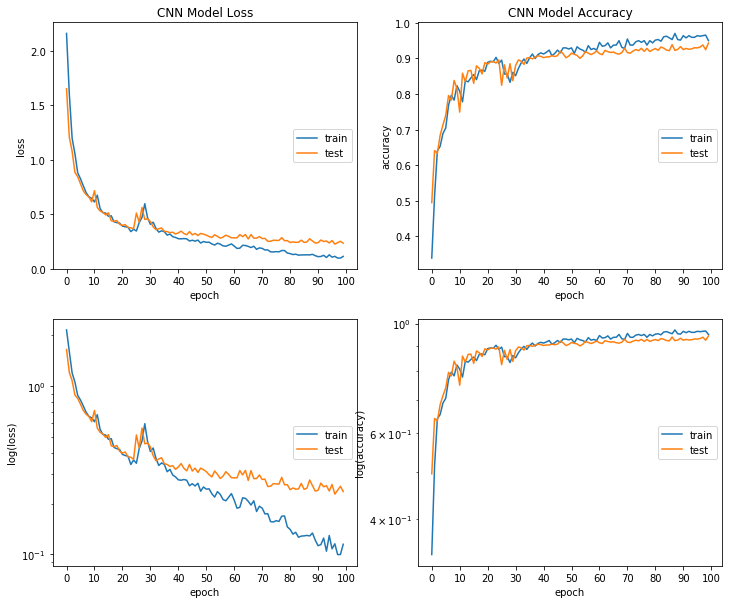

In [73]:
# summarize history of loss

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(12, 10))
ax1.plot(CNNmodel.history['loss'])
ax1.plot(CNNmodel.history['val_loss'])
ax1.set_title('CNN Model Loss')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.locator_params(nbins=13, axis='x')
ax1.legend(['train', 'test'], loc='center right')
ax2.plot(CNNmodel.history['accuracy'])
ax2.plot(CNNmodel.history['val_accuracy'])
ax2.set_title('CNN Model Accuracy')
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')
ax2.locator_params(nbins=12, axis='x')
ax2.legend(['train', 'test'], loc='center right')
ax3.plot(CNNmodel.history['loss'])
ax3.plot(CNNmodel.history['val_loss'])
ax3.set_ylabel('log(loss)')
ax3.set_xlabel('epoch')
ax3.locator_params(nbins=13, axis='x')
ax3.legend(['train', 'test'], loc='center right')
ax3.set_yscale('log')
ax4.plot(CNNmodel.history['accuracy'])
ax4.plot(CNNmodel.history['val_accuracy'])
ax4.set_ylabel('log(accuracy)')
ax4.set_xlabel('epoch')
ax4.locator_params(nbins=12, axis='x')
ax4.legend(['train', 'test'], loc='center right')
ax4.set_yscale('log')
plt.show
#f.savefig("./plots/CNN_spatial_train_108_5_CNN_loss_accuracy_vs_epoch.png")

In [74]:
import tensorflow as tf
from tensorflow import keras

cnn = keras.Sequential([keras.layers.Conv1D(16, kernel_size=(50), padding="same", 
                                            activation="relu", input_shape=(cube_specxy.shape[2], 1)),
                       keras.layers.MaxPooling1D((2), strides=2),
                        keras.layers.Conv1D(32, kernel_size=(50), padding="same", activation="relu"),
                        keras.layers.MaxPooling1D((2), strides=2),
                        keras.layers.Flatten(),
                        keras.layers.Dense(512, activation="relu"),
                        keras.layers.Dense(10, activation="softmax")])

cnn.compile(optimizer="adam", loss=["sparse_categorical_crossentropy"], metrics=['accuracy'])

cube_train2 = cube_train.reshape(cube_train.shape[0], cube_train.shape[1], 1)
cube_test2 = cube_test.reshape(cube_test.shape[0], cube_test.shape[1], 1)

CNNmodel = cnn.fit(cube_train2, cube_train_labels, validation_data=(cube_test2, cube_test_labels), 
                   epochs=35, batch_size=512)

Train on 640 samples, validate on 2560 samples
Epoch 1/35
640/640 [==============================] - 1s 2ms/sample - loss: 2.2376 - accuracy: 0.1984 - val_loss: 1.8389 - val_accuracy: 0.4285
Epoch 2/35
640/640 [==============================] - 0s 718us/sample - loss: 1.8023 - accuracy: 0.4391 - val_loss: 1.5423 - val_accuracy: 0.4953
Epoch 3/35
640/640 [==============================] - 0s 643us/sample - loss: 1.4970 - accuracy: 0.5281 - val_loss: 1.1185 - val_accuracy: 0.6676
Epoch 4/35
640/640 [==============================] - 0s 648us/sample - loss: 1.1092 - accuracy: 0.6703 - val_loss: 1.0146 - val_accuracy: 0.7324
Epoch 5/35
640/640 [==============================] - 0s 704us/sample - loss: 1.0109 - accuracy: 0.7172 - val_loss: 0.9274 - val_accuracy: 0.7812
Epoch 6/35
640/640 [==============================] - 0s 664us/sample - loss: 0.9115 - accuracy: 0.7625 - val_loss: 0.7925 - val_accuracy: 0.7586
Epoch 7/35
640/640 [==============================] - 0s 744us/sample - loss: 0

In [75]:
# model accuracy on training and testing sets

train_loss_20, train_acc_20 = cnn.evaluate(cube_train2, cube_train_labels)
test_loss_20, test_acc_20 = cnn.evaluate(cube_test2, cube_test_labels)

print(train_acc_20, test_acc_20)

2560/2560 [==============================] - 1s 227us/sample - loss: 0.3431 - accuracy: 0.9016
0.903125 0.9015625


#### Predict pixel classification on veg_00108 trained with 20-80 split

In [76]:
# classify entire binned cube
import time
start_time = time.time()

cube_specxy_2d_1 = cube_specxy_2d.reshape(cube_specxy_2d.shape[0], cube_specxy_2d.shape[1], 1)
predictCube = cnn.predict_classes(cube_specxy_2d_1)

elapsed_time = time.time() - start_time
print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

00:09:09


In [77]:
predictCube_reshape = predictCube.reshape(cube_specxy.shape[0], cube_specxy.shape[1])

In [78]:
veg_by_row = np.zeros(cube_sub.shape[1])
for row in range(0, cube_sub.shape[1]):
    veg_by_row[row] = np.count_nonzero(predictCube_reshape[row,:] == 2)

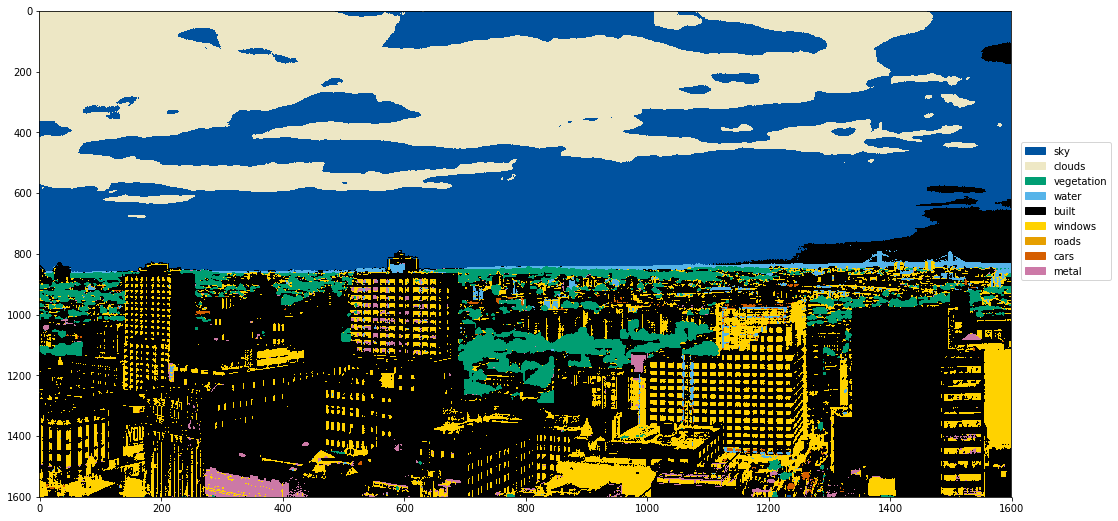

In [79]:
import matplotlib.pyplot as plt
import matplotlib.colors as ListedColorMap
import matplotlib.patches as mpatches
from matplotlib.ticker import NullFormatter
%matplotlib inline

cmap = {0:[0,0.32549,0.62353,1], 1:[0.93333,0.9098,0.77255,1], 2:[0,0.61961,0.45098,1],  3:[0.33725,0.70588,0.91373,1],
        4:[0,0,0,1], 5:[1,0.82353,0,1], 6:[0.90196,0.62353,0,1], 7:[0.83529,0.36863,0,1],
        8:[0.8,0.47451,0.65490,1]}
labels = {0:'sky', 1:'clouds', 2:'vegetation', 3:'water', 4:'built',
          5:'windows', 6:'roads', 7:'cars', 8:'metal'}
arrayShow = np.array([[cmap[i] for i in j] for j in predictCube_reshape])
patches = [mpatches.Patch(color=cmap[i], label=labels[i]) for i in cmap]

fig = plt.figure(figsize=(15,15))
ax = fig.add_axes([0.1,0.1,0.9,0.9])
ax.tick_params(labelsize=10)
ax.imshow(arrayShow, aspect=0.5)
lgd = ax.legend(handles=patches, bbox_to_anchor=(1,0.75), loc='upper left', borderaxespad=1.0, prop={'size':10}, ncol=1)
plt.show()
#fig.savefig("./plots/CNN_spatial_train_108_6_108_predict_map.png", bbox_extra_artists=(lgd,), bbox_inches='tight')

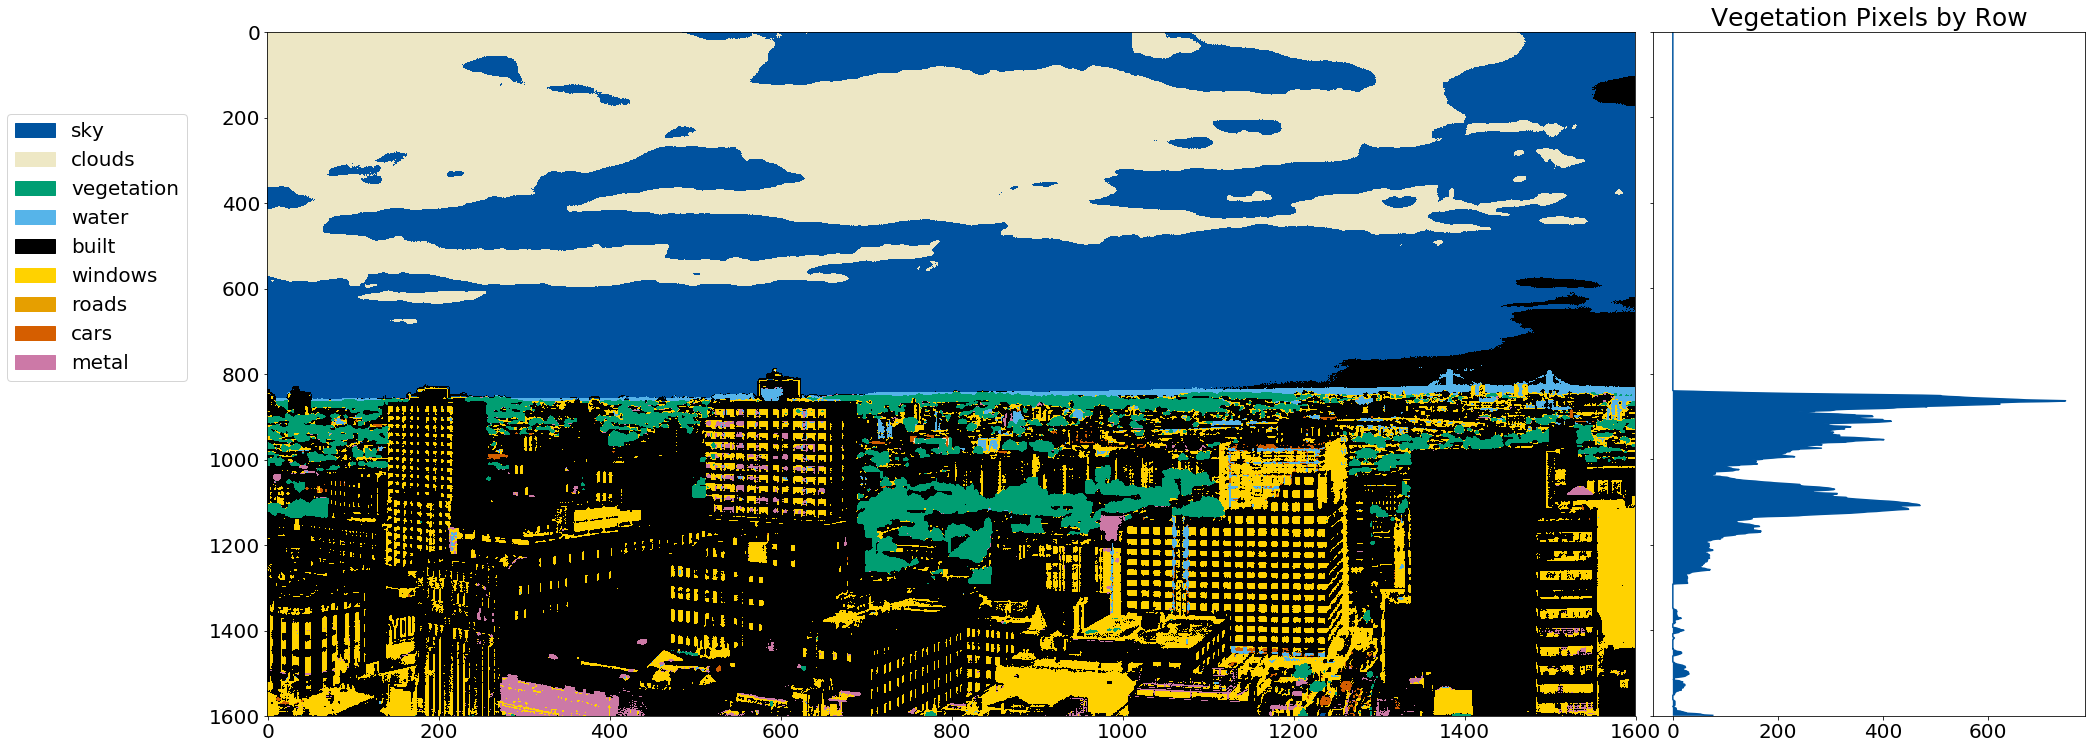

In [80]:
import matplotlib.pyplot as plt
import matplotlib.colors as ListedColorMap
import matplotlib.patches as mpatches
from matplotlib.ticker import NullFormatter
%matplotlib inline

cmap = {0:[0,0.32549,0.62353,1], 1:[0.93333,0.9098,0.77255,1], 2:[0,0.61961,0.45098,1],  3:[0.33725,0.70588,0.91373,1],
        4:[0,0,0,1], 5:[1,0.82353,0,1], 6:[0.90196,0.62353,0,1], 7:[0.83529,0.36863,0,1],
        8:[0.8,0.47451,0.65490,1]}
labels = {0:'sky', 1:'clouds', 2:'vegetation', 3:'water', 4:'built',
          5:'windows', 6:'roads', 7:'cars', 8:'metal'}
arrayShow = np.array([[cmap[i] for i in j] for j in predictCube_reshape])
patches = [mpatches.Patch(color=cmap[i], label=labels[i]) for i in cmap]
#fig, ax = plt.subplots(figsize = (20,10))

fig = plt.figure(1, figsize=(30,10))
axImage = plt.axes([0.1,0.1,0.85,0.95])
axHist = plt.axes([0.85,0.1,0.2,0.95])
axHist.yaxis.set_major_formatter(NullFormatter())
axImage.tick_params(labelsize=20)
axHist.tick_params(labelsize=20)
axImage.imshow(arrayShow, aspect=0.5)
axHist.plot(veg_by_row, np.arange(0,cube_sub.shape[1]), color=[0.0,0.33,0.62])
axHist.fill_between(veg_by_row, np.arange(0,cube_sub.shape[1]), cube_sub.shape[1], facecolor=[0.0,0.33,0.62])
axHist.set_ylim(cube_sub.shape[1], 0)
axHist.set(title='Vegetation Pixels by Row')
axHist.title.set_fontsize(25)
lgd = axImage.legend(handles=patches, bbox_to_anchor=(0,0.5), loc=2, borderaxespad=-13.0, prop={'size':20}, ncol=1)
plt.show()
#fig.savefig("./plots/CNN_spatial_train_108_6_108_predict_map_veg_by_row.png", bbox_extra_artists=(lgd,), bbox_inches='tight')

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.6/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


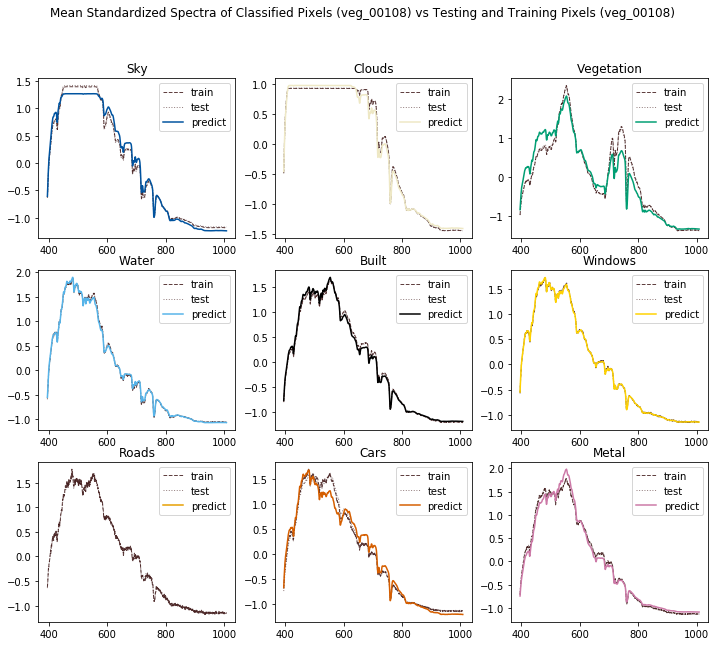

In [81]:
# plot mean spectra for testing set separately

import matplotlib.pyplot as plt
%matplotlib inline

f, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(12, 10))
plt.suptitle('Mean Standardized Spectra of Classified Pixels (veg_00108) vs Testing and Training Pixels (veg_00108)')
ax1.plot(cube.waves, cube_sky_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=1, ls="dashed")
ax1.plot(cube.waves, cube_sky_test[:,:-2].mean(0), color=[0.170,0,0,0.5], lw=1, ls="dotted")
ax1.plot(cube.waves, cube_standard[np.where(predictCube == 0)[0]].mean(0), color=[0,0.32549,0.62353])
ax1.set_title("Sky")
ax1.legend(['train', 'test', 'predict'], loc='upper right')
ax2.plot(cube.waves, cube_clouds_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=1, ls="dashed")
ax2.plot(cube.waves, cube_clouds_test[:,:-2].mean(0), color=[0.170,0,0,0.5], lw=1, ls="dotted")
ax2.plot(cube.waves, cube_standard[np.where(predictCube == 1)[0]].mean(0), color=[0.93333,0.9098,0.77255])
ax2.set_title("Clouds")
ax2.legend(['train', 'test', 'predict'], loc='upper right')
ax3.plot(cube.waves, cube_veg_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=1, ls="dashed")
ax3.plot(cube.waves, cube_veg_test[:,:-2].mean(0), color=[0.170,0,0,0.5], lw=1, ls="dotted")
ax3.plot(cube.waves, cube_standard[np.where(predictCube == 2)[0]].mean(0), color=[0,0.61961,0.45098])
ax3.set_title("Vegetation")
ax3.legend(['train', 'test', 'predict'], loc='upper right')
ax4.plot(cube.waves, cube_wtr_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=1, ls="dashed")
ax4.plot(cube.waves, cube_wtr_test[:,:-2].mean(0), color=[0.170,0,0,0.5], lw=1, ls="dotted")
ax4.plot(cube.waves, cube_standard[np.where(predictCube == 3)[0]].mean(0), color=[0.33725,0.70588,0.91373])
ax4.set_title("Water")
ax4.legend(['train', 'test', 'predict'], loc='upper right')
ax5.plot(cube.waves, cube_blt_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=1, ls="dashed")
ax5.plot(cube.waves, cube_blt_test[:,:-2].mean(0), color=[0.170,0,0,0.5], lw=1, ls="dotted")
ax5.plot(cube.waves, cube_standard[np.where(predictCube == 4)[0]].mean(0), color=[0,0,0])
ax5.set_title("Built")
ax5.legend(['train', 'test', 'predict'], loc='upper right')
ax6.plot(cube.waves, cube_windows_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=1, ls="dashed")
ax6.plot(cube.waves, cube_windows_test[:,:-2].mean(0), color=[0.170,0,0,0.5], lw=1, ls="dotted")
ax6.plot(cube.waves, cube_standard[np.where(predictCube == 5)[0]].mean(0), color=[1,0.82353,0])
ax6.set_title("Windows")
ax6.legend(['train', 'test', 'predict'], loc='upper right')
ax7.plot(cube.waves, cube_rds_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=1, ls="dashed")
ax7.plot(cube.waves, cube_rds_test[:,:-2].mean(0), color=[0.170,0,0,0.5], lw=1, ls="dotted")
ax7.plot(cube.waves, cube_standard[np.where(predictCube == 6)[0]].mean(0), color=[0.90196,0.62353,0])
ax7.set_title("Roads")
ax7.legend(['train', 'test', 'predict'], loc='upper right')
ax8.plot(cube.waves, cube_cars_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=1, ls="dashed")
ax8.plot(cube.waves, cube_cars_test[:,:-2].mean(0), color=[0.170,0,0,0.5], lw=1, ls="dotted")
ax8.plot(cube.waves, cube_standard[np.where(predictCube == 7)[0]].mean(0), color=[0.83529,0.36863,0])
ax8.set_title("Cars")
ax8.legend(['train', 'test', 'predict'], loc='upper right')
ax9.plot(cube.waves, cube_mtl_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=1, ls="dashed")
ax9.plot(cube.waves, cube_mtl_test[:,:-2].mean(0), color=[0.170,0,0,0.5], lw=1, ls="dotted")
ax9.plot(cube.waves, cube_standard[np.where(predictCube == 8)[0]].mean(0), color=[0.8,0.47451,0.65490])
ax9.set_title("Metal")
ax9.legend(['train', 'test', 'predict'], loc='upper right')
plt.show()
#f.savefig("./plots/CNN_spatial_train_108_7_108_mean_spectra_train_test_predict_3x3.png")

#### Evaluation Metrics 20-80 split

In [82]:
labels_pred_sky = predictCube_reshape[sky_coords[:,0], sky_coords[:,1]]
labels_pred_clouds = predictCube_reshape[clouds_coords[:,0], clouds_coords[:,1]]
labels_pred_veg = predictCube_reshape[veg_coords[:,0], veg_coords[:,1]]
labels_pred_wtr = predictCube_reshape[wtr_coords[:,0], wtr_coords[:,1]]
labels_pred_blt = predictCube_reshape[blt_coords[:,0], blt_coords[:,1]]
labels_pred_windows = predictCube_reshape[windows_coords[:,0], windows_coords[:,1]]
labels_pred_rds = predictCube_reshape[rds_coords[:,0], rds_coords[:,1]]
labels_pred_cars = predictCube_reshape[cars_coords[:,0], cars_coords[:,1]]
labels_pred_mtl = predictCube_reshape[mtl_coords[:,0], mtl_coords[:,1]]

labels_pred = np.concatenate((labels_pred_sky, labels_pred_clouds, labels_pred_veg, labels_pred_wtr, 
                             labels_pred_blt, labels_pred_windows, labels_pred_rds, labels_pred_cars, labels_pred_mtl))

In [83]:
labels_true_sky = np.full((sky_coords.shape[0]), 0)
labels_true_clouds = np.full((clouds_coords.shape[0]), 1)
labels_true_veg = np.full((veg_coords.shape[0]), 2)
labels_true_wtr = np.full((wtr_coords.shape[0]), 3)
labels_true_blt = np.full((blt_coords.shape[0]), 4)
labels_true_windows = np.full((windows_coords.shape[0]), 5)
labels_true_rds = np.full((rds_coords.shape[0]), 6)
labels_true_cars = np.full((cars_coords.shape[0]), 7)
labels_true_mtl = np.full((mtl_coords.shape[0]), 8)

labels_true = np.concatenate((labels_true_sky, labels_true_clouds, labels_true_veg, labels_true_wtr, 
                             labels_true_blt, labels_true_windows, labels_true_rds, labels_true_cars, labels_true_mtl))

In [84]:
print(labels_pred.shape)
print(labels_true.shape)

(3200,)
(3200,)


In [85]:
from sklearn import metrics

print("Confusion Matrix")
print(metrics.confusion_matrix(labels_true, labels_pred))

print("")
print("Accuracy Score")
print(metrics.accuracy_score(labels_true, labels_pred))

target_names = ['sky', 'clouds', 'vegetation', 'water', 'built', 'windows', 'roads', 'cars', 'metal']
print("")
print("Classification Report")
print(metrics.classification_report(labels_true, labels_pred, target_names=target_names))

Confusion Matrix
[[299   0   0   0   1   0   0   0   0]
 [  2 498   0   0   0   0   0   0   0]
 [  0   0 593   1   6   0   0   0   0]
 [  0   0   0  50   0   0   0   0   0]
 [  0   0   0  15 968  35   0   1   1]
 [  0   0   0   2  49 447   0   1   1]
 [  0   0   0   0  30   0   0   0   0]
 [  6   0   0   2  63  12   0  14   3]
 [  0   0   0   0  69  14   0   0  17]]

Accuracy Score
0.901875

Classification Report
             precision    recall  f1-score   support

        sky       0.97      1.00      0.99       300
     clouds       1.00      1.00      1.00       500
 vegetation       1.00      0.99      0.99       600
      water       0.71      1.00      0.83        50
      built       0.82      0.95      0.88      1020
    windows       0.88      0.89      0.89       500
      roads       0.00      0.00      0.00        30
       cars       0.88      0.14      0.24       100
      metal       0.77      0.17      0.28       100

avg / total       0.90      0.90      0.88      320

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [86]:
#f = open("./metrics/CNN_spatial_train_108_test_108_binned_848_metrics.txt", "w")
#f.write("Confusion Matrix")
#f.write('\n')
#f.write(str(metrics.confusion_matrix(labels_true, labels_pred)))
#f.write('\n')
#f.write('\n')
#f.write("Accuracy Score")
#f.write('\n')
#f.write(str(metrics.accuracy_score(labels_true, labels_pred)))
#target_names = ['sky', 'clouds', 'vegetation', 'water', 'built', 'windows', 'roads', 'cars', 'metal']
#f.write('\n')
#f.write('\n')
#f.write("Classification Report")
#f.write('\n')
#f.write(metrics.classification_report(labels_true, labels_pred, target_names=target_names))
#f.close()

In [87]:
sky_dict, sky_dict_norm = kmeans_test_dictionary(predictCube_reshape, sky_coords, 9)
clouds_dict, cloud_dict_norm = kmeans_test_dictionary(predictCube_reshape, clouds_coords, 9)
veg_dict, veg_dict_norm = kmeans_test_dictionary(predictCube_reshape, veg_coords, 9)
wtr_dict, wtr_dict_norm = kmeans_test_dictionary(predictCube_reshape, wtr_coords, 9)
blt_dict, blt_dict_norm = kmeans_test_dictionary(predictCube_reshape, blt_coords, 9)
windows_dict, windows_dict_norm = kmeans_test_dictionary(predictCube_reshape, windows_coords, 9)
rds_dict, rds_dict_norm = kmeans_test_dictionary(predictCube_reshape, rds_coords, 9)
cars_dict, cars_dict_norm = kmeans_test_dictionary(predictCube_reshape, cars_coords, 9)
mtl_dict, mtl_dict_norm = kmeans_test_dictionary(predictCube_reshape, mtl_coords, 9)

df_test = kmeans_test_dataframe(sky_dict, clouds_dict, veg_dict, wtr_dict,
                                blt_dict, windows_dict, rds_dict, cars_dict, mtl_dict)
print(df_test.transpose())
df_test_norm = kmeans_test_dataframe(sky_dict, clouds_dict, veg_dict, wtr_dict,
                                     blt_dict, windows_dict, rds_dict, cars_dict, mtl_dict)
#print("")
#print(df_test_norm.transpose())

              0    1    2   3    4    5  6   7   8
sky         299    0    0   0    1    0  0   0   0
clouds        2  498    0   0    0    0  0   0   0
vegetation    0    0  593   1    6    0  0   0   0
water         0    0    0  50    0    0  0   0   0
built         0    0    0  15  968   35  0   1   1
windows       0    0    0   2   49  447  0   1   1
roads         0    0    0   0   30    0  0   0   0
cars          6    0    0   2   63   12  0  14   3
metal         0    0    0   0   69   14  0   0  17


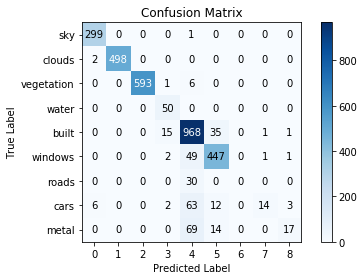

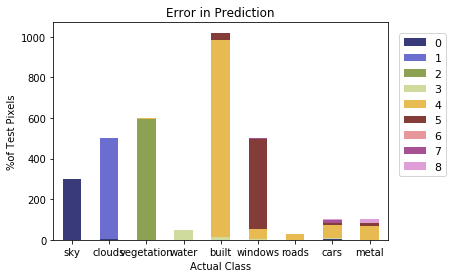

In [88]:
plot_confusion_matrix(df_test, norm=False)
#plot_confusion_matrix(df_test_norm, norm=True)
plot_test_result(df_test_norm)

## Split classified pixels into 10% training and 90% testing sets

In [ ]:
train_ratio = 0.1

import random

# sky coordinates
sky_ind = np.arange(sky_coords.shape[0])
random.Random(3).shuffle(sky_ind)
lim_ind = int(len(sky_ind)*train_ratio)
sky_train_ind = sky_ind[:lim_ind]
sky_test_ind = sky_ind[lim_ind:]
print("sky %d %d" % (len(sky_train_ind), len(sky_test_ind)))

# clouds coordinates
clouds_ind = np.arange(clouds_coords.shape[0])
random.Random(3).shuffle(clouds_ind)
lim_ind = int(len(clouds_ind)*train_ratio)
clouds_train_ind = clouds_ind[:lim_ind]
clouds_test_ind = clouds_ind[lim_ind:]
print("clouds %d %d" % (len(clouds_train_ind), len(clouds_test_ind)))

# vegetation coordinates
veg_ind = np.arange(veg_coords.shape[0])
random.Random(3).shuffle(veg_ind)
lim_ind = int(len(veg_ind)*train_ratio)
veg_train_ind = veg_ind[:lim_ind]
veg_test_ind = veg_ind[lim_ind:]
print("vegetation %d %d" % (len(veg_train_ind), len(veg_test_ind)))

# water coordinates
wtr_ind = np.arange(wtr_coords.shape[0])
random.Random(3).shuffle(wtr_ind)
lim_ind = int(len(wtr_ind)*train_ratio)
wtr_train_ind = wtr_ind[:lim_ind]
wtr_test_ind = wtr_ind[lim_ind:]
print("water %d %d" % (len(wtr_train_ind), len(wtr_test_ind)))

# built coordinates
blt_ind = np.arange(blt_coords.shape[0])
random.Random(3).shuffle(blt_ind)
lim_ind = int(len(blt_ind)*train_ratio)
blt_train_ind = blt_ind[:lim_ind]
blt_test_ind = blt_ind[lim_ind:]
print("built %d %d" % (len(blt_train_ind), len(blt_test_ind)))

# windows coordinates
windows_ind = np.arange(windows_coords.shape[0])
random.Random(3).shuffle(windows_ind)
lim_ind = int(len(windows_ind)*train_ratio)
windows_train_ind = windows_ind[:lim_ind]
windows_test_ind = windows_ind[lim_ind:]
print("windows %d %d" % (len(windows_train_ind), len(windows_test_ind)))

# roads coordinates
rds_ind = np.arange(rds_coords.shape[0])
random.Random(3).shuffle(rds_ind)
lim_ind = int(len(rds_ind)*train_ratio)
rds_train_ind = rds_ind[:lim_ind]
rds_test_ind = rds_ind[lim_ind:]
print("roads %d %d" % (len(rds_train_ind), len(rds_test_ind)))

# cars coordinates
cars_ind = np.arange(cars_coords.shape[0])
random.Random(3).shuffle(cars_ind)
lim_ind = int(len(cars_ind)*train_ratio)
cars_train_ind = cars_ind[:lim_ind]
cars_test_ind = cars_ind[lim_ind:]
print("cars %d %d" % (len(cars_train_ind), len(cars_test_ind)))

# metal coordinates
mtl_ind = np.arange(mtl_coords.shape[0])
random.Random(3).shuffle(mtl_ind)
lim_ind = int(len(mtl_ind)*train_ratio)
mtl_train_ind = mtl_ind[:lim_ind]
mtl_test_ind = mtl_ind[lim_ind:]
print("metal %d %d" % (len(mtl_train_ind), len(mtl_test_ind)))

In [ ]:
cube_sky_train = cube_specxy[sky_coords[sky_train_ind[:], 0], sky_coords[sky_train_ind[:], 1], :]
cube_sky_test = cube_specxy[sky_coords[sky_test_ind[:], 0], sky_coords[sky_test_ind[:], 1], :]
print("sky ", cube_sky_train.shape, cube_sky_test.shape)

cube_clouds_train = cube_specxy[clouds_coords[clouds_train_ind[:], 0], clouds_coords[clouds_train_ind[:], 1], :]
cube_clouds_test = cube_specxy[clouds_coords[clouds_test_ind[:], 0], clouds_coords[clouds_test_ind[:], 1], :]
print("clouds ", cube_clouds_train.shape, cube_clouds_test.shape)

cube_veg_train = cube_specxy[veg_coords[veg_train_ind[:], 0], veg_coords[veg_train_ind[:], 1], :]
cube_veg_test = cube_specxy[veg_coords[veg_test_ind[:], 0], veg_coords[veg_test_ind[:], 1], :]
print("vegetation ", cube_veg_train.shape, cube_veg_test.shape)

cube_wtr_train = cube_specxy[wtr_coords[wtr_train_ind[:], 0], wtr_coords[wtr_train_ind[:], 1], :]
cube_wtr_test = cube_specxy[wtr_coords[wtr_test_ind[:], 0], wtr_coords[wtr_test_ind[:], 1], :]
print("water ", cube_wtr_train.shape, cube_wtr_test.shape)

cube_blt_train = cube_specxy[blt_coords[blt_train_ind[:], 0], blt_coords[blt_train_ind[:], 1], :]
cube_blt_test = cube_specxy[blt_coords[blt_test_ind[:], 0], blt_coords[blt_test_ind[:], 1], :]
print("built ", cube_blt_train.shape, cube_blt_test.shape)

cube_windows_train = cube_specxy[windows_coords[windows_train_ind[:], 0], windows_coords[windows_train_ind[:], 1], :]
cube_windows_test = cube_specxy[windows_coords[windows_test_ind[:], 0], windows_coords[windows_test_ind[:], 1], :]
print("windows ", cube_windows_train.shape, cube_windows_test.shape)

cube_rds_train = cube_specxy[rds_coords[rds_train_ind[:], 0], rds_coords[rds_train_ind[:], 1], :]
cube_rds_test = cube_specxy[rds_coords[rds_test_ind[:], 0], rds_coords[rds_test_ind[:], 1], :]
print("roads ", cube_rds_train.shape, cube_rds_test.shape)

cube_cars_train = cube_specxy[cars_coords[cars_train_ind[:], 0], cars_coords[cars_train_ind[:], 1], :]
cube_cars_test = cube_specxy[cars_coords[cars_test_ind[:], 0], cars_coords[cars_test_ind[:], 1], :]
print("cars ", cube_cars_train.shape, cube_cars_test.shape)

cube_mtl_train = cube_specxy[mtl_coords[mtl_train_ind[:], 0], mtl_coords[mtl_train_ind[:], 1], :]
cube_mtl_test = cube_specxy[mtl_coords[mtl_test_ind[:], 0], mtl_coords[mtl_test_ind[:], 1], :]
print("metal ", cube_mtl_train.shape, cube_mtl_test.shape)

In [ ]:
# concatenate training and testing sets and create index arrays

cube_train = np.concatenate((cube_sky_train, cube_clouds_train, cube_veg_train, cube_wtr_train, cube_blt_train,
                            cube_windows_train, cube_rds_train, cube_cars_train, cube_mtl_train), axis=0)
cube_train_labels = [0]*cube_sky_train.shape[0] + [1]*cube_clouds_train.shape[0] \
                    + [2]*cube_veg_train.shape[0] + [3]*cube_wtr_train.shape[0] \
                    + [4]*cube_blt_train.shape[0] + [5]*cube_windows_train.shape[0] \
                    + [6]*cube_rds_train.shape[0] + [7]*cube_cars_train.shape[0] + [8]*cube_mtl_train.shape[0]

print(cube_train.shape)

cube_test = np.concatenate((cube_sky_test, cube_clouds_test, cube_veg_test, cube_wtr_test, cube_blt_test,
                            cube_windows_test, cube_rds_test, cube_cars_test, cube_mtl_test), axis=0)
cube_test_labels = [0]*cube_sky_test.shape[0] + [1]*cube_clouds_test.shape[0] \
                    + [2]*cube_veg_test.shape[0] + [3]*cube_wtr_test.shape[0] \
                    + [4]*cube_blt_test.shape[0] + [5]*cube_windows_test.shape[0] \
                    + [6]*cube_rds_test.shape[0] + [7]*cube_cars_test.shape[0] + [8]*cube_mtl_test.shape[0]

print(cube_test.shape)

In [ ]:
# plot mean spectra for testing set separately

import matplotlib.pyplot as plt
%matplotlib inline

f, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(12, 10))
plt.suptitle('Mean Standardized Spectra of Testing Pixels (veg_00108)')
ax1.plot(cube.waves, cube_sky_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=3, ls="dashed")
ax1.plot(cube.waves, cube_sky_test[:,:-2].mean(0), color=[0,0.32549,0.62353])
ax1.set_title("Sky")
ax1.legend(['train', 'test'], loc='upper right')
ax2.plot(cube.waves, cube_clouds_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=3, ls="dashed")
ax2.plot(cube.waves, cube_clouds_test[:,:-2].mean(0), color=[0.93333,0.9098,0.77255])
ax2.set_title("Clouds")
ax2.legend(['train', 'test'], loc='upper right')
ax3.plot(cube.waves, cube_veg_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=3, ls="dashed")
ax3.plot(cube.waves, cube_veg_test[:,:-2].mean(0), color=[0,0.61961,0.45098])
ax3.set_title("Vegetation")
ax3.legend(['train', 'test'], loc='upper right')
ax4.plot(cube.waves, cube_wtr_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=3, ls="dashed")
ax4.plot(cube.waves, cube_wtr_test[:,:-2].mean(0), color=[0.33725,0.70588,0.91373])
ax4.set_title("Water")
ax4.legend(['train', 'test'], loc='upper right')
ax5.plot(cube.waves, cube_blt_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=3, ls="dashed")
ax5.plot(cube.waves, cube_blt_test[:,:-2].mean(0), color=[0,0,0])
ax5.set_title("Built")
ax5.legend(['train', 'test'], loc='upper right')
ax6.plot(cube.waves, cube_windows_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=3, ls="dashed")
ax6.plot(cube.waves, cube_windows_test[:,:-2].mean(0), color=[1,0.82353,0])
ax6.set_title("Windows")
ax6.legend(['train', 'test'], loc='upper right')
ax7.plot(cube.waves, cube_rds_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=3, ls="dashed")
ax7.plot(cube.waves, cube_rds_test[:,:-2].mean(0), color=[0.90196,0.62353,0])
ax7.set_title("Roads")
ax7.legend(['train', 'test'], loc='upper right')
ax8.plot(cube.waves, cube_cars_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=3, ls="dashed")
ax8.plot(cube.waves, cube_cars_test[:,:-2].mean(0), color=[0.83529,0.36863,0])
ax8.set_title("Cars")
ax8.legend(['train', 'test'], loc='upper right')
ax9.plot(cube.waves, cube_mtl_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=3, ls="dashed")
ax9.plot(cube.waves, cube_mtl_test[:,:-2].mean(0), color=[0.8,0.47451,0.65490])
ax9.set_title("Metal")
ax9.legend(['train', 'test'], loc='upper right')
plt.show()
#f.savefig("./plots/CNN_spatial_train_108_3_mean_spectra_108_training_vs_testing_pixels_3x3.png")

#### Train CNN on 10%

In [ ]:
cube_train_labels = np.array(cube_train_labels)
cube_test_labels = np.array(cube_test_labels)

In [ ]:
import tensorflow as tf
from tensorflow import keras

cnn = keras.Sequential([keras.layers.Conv1D(16, kernel_size=(50), padding="same", 
                                            activation="relu", input_shape=(cube_specxy.shape[2], 1)),
                       keras.layers.MaxPooling1D((2), strides=2),
                        keras.layers.Conv1D(32, kernel_size=(50), padding="same", activation="relu"),
                        keras.layers.MaxPooling1D((2), strides=2),
                        keras.layers.Flatten(),
                        keras.layers.Dense(512, activation="relu"),
                        keras.layers.Dense(10, activation="softmax")])

cnn.compile(optimizer="adam", loss=["sparse_categorical_crossentropy"], metrics=['accuracy'])

cube_train2 = cube_train.reshape(cube_train.shape[0], cube_train.shape[1], 1)
cube_test2 = cube_test.reshape(cube_test.shape[0], cube_test.shape[1], 1)

CNNmodel = cnn.fit(cube_train2, cube_train_labels, validation_data=(cube_test2, cube_test_labels), 
                   epochs=100, batch_size=512)

In [ ]:
# summarize history of loss

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(12, 10))
ax1.plot(CNNmodel.history['loss'])
ax1.plot(CNNmodel.history['val_loss'])
ax1.set_title('CNN Model Loss')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.locator_params(nbins=13, axis='x')
ax1.legend(['train', 'test'], loc='center right')
ax2.plot(CNNmodel.history['accuracy'])
ax2.plot(CNNmodel.history['val_accuracy'])
ax2.set_title('CNN Model Accuracy')
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')
ax2.locator_params(nbins=12, axis='x')
ax2.legend(['train', 'test'], loc='center right')
ax3.plot(CNNmodel.history['loss'])
ax3.plot(CNNmodel.history['val_loss'])
ax3.set_ylabel('log(loss)')
ax3.set_xlabel('epoch')
ax3.locator_params(nbins=13, axis='x')
ax3.legend(['train', 'test'], loc='center right')
ax3.set_yscale('log')
ax4.plot(CNNmodel.history['accuracy'])
ax4.plot(CNNmodel.history['val_accuracy'])
ax4.set_ylabel('log(accuracy)')
ax4.set_xlabel('epoch')
ax4.locator_params(nbins=12, axis='x')
ax4.legend(['train', 'test'], loc='center right')
ax4.set_yscale('log')
plt.show
#f.savefig("./plots/CNN_spatial_train_108_5_CNN_loss_accuracy_vs_epoch.png")

In [ ]:
import tensorflow as tf
from tensorflow import keras

cnn = keras.Sequential([keras.layers.Conv1D(16, kernel_size=(50), padding="same", 
                                            activation="relu", input_shape=(cube_specxy.shape[2], 1)),
                       keras.layers.MaxPooling1D((2), strides=2),
                        keras.layers.Conv1D(32, kernel_size=(50), padding="same", activation="relu"),
                        keras.layers.MaxPooling1D((2), strides=2),
                        keras.layers.Flatten(),
                        keras.layers.Dense(512, activation="relu"),
                        keras.layers.Dense(10, activation="softmax")])

cnn.compile(optimizer="adam", loss=["sparse_categorical_crossentropy"], metrics=['accuracy'])

cube_train2 = cube_train.reshape(cube_train.shape[0], cube_train.shape[1], 1)
cube_test2 = cube_test.reshape(cube_test.shape[0], cube_test.shape[1], 1)

CNNmodel = cnn.fit(cube_train2, cube_train_labels, validation_data=(cube_test2, cube_test_labels), 
                   epochs=25, batch_size=512)

In [ ]:
# model accuracy on training and testing sets

train_loss_10, train_acc_10 = cnn.evaluate(cube_train2, cube_train_labels)
test_loss_10, test_acc_10 = cnn.evaluate(cube_test2, cube_test_labels)

print(train_acc_10, test_acc_10)

### Predict pixel classification on veg_00108 trained with 10-90 split

In [ ]:
# classify entire binned cube
import time
start_time = time.time()

cube_specxy_2d_1 = cube_specxy_2d.reshape(cube_specxy_2d.shape[0], cube_specxy_2d.shape[1], 1)
predictCube = cnn.predict_classes(cube_specxy_2d_1)

elapsed_time = time.time() - start_time
print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

In [ ]:
predictCube_reshape = predictCube.reshape(cube_specxy.shape[0], cube_specxy.shape[1])

In [ ]:
veg_by_row = np.zeros(cube_sub.shape[1])
for row in range(0, cube_sub.shape[1]):
    veg_by_row[row] = np.count_nonzero(predictCube_reshape[row,:] == 2)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as ListedColorMap
import matplotlib.patches as mpatches
from matplotlib.ticker import NullFormatter
%matplotlib inline

cmap = {0:[0,0.32549,0.62353,1], 1:[0.93333,0.9098,0.77255,1], 2:[0,0.61961,0.45098,1],  3:[0.33725,0.70588,0.91373,1],
        4:[0,0,0,1], 5:[1,0.82353,0,1], 6:[0.90196,0.62353,0,1], 7:[0.83529,0.36863,0,1],
        8:[0.8,0.47451,0.65490,1]}
labels = {0:'sky', 1:'clouds', 2:'vegetation', 3:'water', 4:'built',
          5:'windows', 6:'roads', 7:'cars', 8:'metal'}
arrayShow = np.array([[cmap[i] for i in j] for j in predictCube_reshape])
patches = [mpatches.Patch(color=cmap[i], label=labels[i]) for i in cmap]

fig = plt.figure(figsize=(15,15))
ax = fig.add_axes([0.1,0.1,0.9,0.9])
ax.tick_params(labelsize=10)
ax.imshow(arrayShow, aspect=0.5)
lgd = ax.legend(handles=patches, bbox_to_anchor=(1,0.75), loc='upper left', borderaxespad=1.0, prop={'size':10}, ncol=1)
plt.show()
#fig.savefig("./plots/CNN_spatial_train_108_6_108_predict_map.png", bbox_extra_artists=(lgd,), bbox_inches='tight')

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as ListedColorMap
import matplotlib.patches as mpatches
from matplotlib.ticker import NullFormatter
%matplotlib inline

cmap = {0:[0,0.32549,0.62353,1], 1:[0.93333,0.9098,0.77255,1], 2:[0,0.61961,0.45098,1],  3:[0.33725,0.70588,0.91373,1],
        4:[0,0,0,1], 5:[1,0.82353,0,1], 6:[0.90196,0.62353,0,1], 7:[0.83529,0.36863,0,1],
        8:[0.8,0.47451,0.65490,1]}
labels = {0:'sky', 1:'clouds', 2:'vegetation', 3:'water', 4:'built',
          5:'windows', 6:'roads', 7:'cars', 8:'metal'}
arrayShow = np.array([[cmap[i] for i in j] for j in predictCube_reshape])
patches = [mpatches.Patch(color=cmap[i], label=labels[i]) for i in cmap]
#fig, ax = plt.subplots(figsize = (20,10))

fig = plt.figure(1, figsize=(30,10))
axImage = plt.axes([0.1,0.1,0.85,0.95])
axHist = plt.axes([0.85,0.1,0.2,0.95])
axHist.yaxis.set_major_formatter(NullFormatter())
axImage.tick_params(labelsize=20)
axHist.tick_params(labelsize=20)
axImage.imshow(arrayShow, aspect=0.5)
axHist.plot(veg_by_row, np.arange(0,cube_sub.shape[1]), color=[0.0,0.33,0.62])
axHist.fill_between(veg_by_row, np.arange(0,cube_sub.shape[1]), cube_sub.shape[1], facecolor=[0.0,0.33,0.62])
axHist.set_ylim(cube_sub.shape[1], 0)
axHist.set(title='Vegetation Pixels by Row')
axHist.title.set_fontsize(25)
lgd = axImage.legend(handles=patches, bbox_to_anchor=(0,0.5), loc=2, borderaxespad=-13.0, prop={'size':20}, ncol=1)
plt.show()
#fig.savefig("./plots/CNN_spatial_train_108_6_108_predict_map_veg_by_row.png", bbox_extra_artists=(lgd,), bbox_inches='tight')

In [ ]:
# plot mean spectra for testing set separately

import matplotlib.pyplot as plt
%matplotlib inline

f, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(12, 10))
plt.suptitle('Mean Standardized Spectra of Classified Pixels (veg_00108) vs Testing and Training Pixels (veg_00108)')
ax1.plot(cube.waves, cube_sky_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=1, ls="dashed")
ax1.plot(cube.waves, cube_sky_test[:,:-2].mean(0), color=[0.170,0,0,0.5], lw=1, ls="dotted")
ax1.plot(cube.waves, cube_standard[np.where(predictCube == 0)[0]].mean(0), color=[0,0.32549,0.62353])
ax1.set_title("Sky")
ax1.legend(['train', 'test', 'predict'], loc='upper right')
ax2.plot(cube.waves, cube_clouds_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=1, ls="dashed")
ax2.plot(cube.waves, cube_clouds_test[:,:-2].mean(0), color=[0.170,0,0,0.5], lw=1, ls="dotted")
ax2.plot(cube.waves, cube_standard[np.where(predictCube == 1)[0]].mean(0), color=[0.93333,0.9098,0.77255])
ax2.set_title("Clouds")
ax2.legend(['train', 'test', 'predict'], loc='upper right')
ax3.plot(cube.waves, cube_veg_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=1, ls="dashed")
ax3.plot(cube.waves, cube_veg_test[:,:-2].mean(0), color=[0.170,0,0,0.5], lw=1, ls="dotted")
ax3.plot(cube.waves, cube_standard[np.where(predictCube == 2)[0]].mean(0), color=[0,0.61961,0.45098])
ax3.set_title("Vegetation")
ax3.legend(['train', 'test', 'predict'], loc='upper right')
ax4.plot(cube.waves, cube_wtr_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=1, ls="dashed")
ax4.plot(cube.waves, cube_wtr_test[:,:-2].mean(0), color=[0.170,0,0,0.5], lw=1, ls="dotted")
ax4.plot(cube.waves, cube_standard[np.where(predictCube == 3)[0]].mean(0), color=[0.33725,0.70588,0.91373])
ax4.set_title("Water")
ax4.legend(['train', 'test', 'predict'], loc='upper right')
ax5.plot(cube.waves, cube_blt_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=1, ls="dashed")
ax5.plot(cube.waves, cube_blt_test[:,:-2].mean(0), color=[0.170,0,0,0.5], lw=1, ls="dotted")
ax5.plot(cube.waves, cube_standard[np.where(predictCube == 4)[0]].mean(0), color=[0,0,0])
ax5.set_title("Built")
ax5.legend(['train', 'test', 'predict'], loc='upper right')
ax6.plot(cube.waves, cube_windows_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=1, ls="dashed")
ax6.plot(cube.waves, cube_windows_test[:,:-2].mean(0), color=[0.170,0,0,0.5], lw=1, ls="dotted")
ax6.plot(cube.waves, cube_standard[np.where(predictCube == 5)[0]].mean(0), color=[1,0.82353,0])
ax6.set_title("Windows")
ax6.legend(['train', 'test', 'predict'], loc='upper right')
ax7.plot(cube.waves, cube_rds_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=1, ls="dashed")
ax7.plot(cube.waves, cube_rds_test[:,:-2].mean(0), color=[0.170,0,0,0.5], lw=1, ls="dotted")
ax7.plot(cube.waves, cube_standard[np.where(predictCube == 6)[0]].mean(0), color=[0.90196,0.62353,0])
ax7.set_title("Roads")
ax7.legend(['train', 'test', 'predict'], loc='upper right')
ax8.plot(cube.waves, cube_cars_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=1, ls="dashed")
ax8.plot(cube.waves, cube_cars_test[:,:-2].mean(0), color=[0.170,0,0,0.5], lw=1, ls="dotted")
ax8.plot(cube.waves, cube_standard[np.where(predictCube == 7)[0]].mean(0), color=[0.83529,0.36863,0])
ax8.set_title("Cars")
ax8.legend(['train', 'test', 'predict'], loc='upper right')
ax9.plot(cube.waves, cube_mtl_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=1, ls="dashed")
ax9.plot(cube.waves, cube_mtl_test[:,:-2].mean(0), color=[0.170,0,0,0.5], lw=1, ls="dotted")
ax9.plot(cube.waves, cube_standard[np.where(predictCube == 8)[0]].mean(0), color=[0.8,0.47451,0.65490])
ax9.set_title("Metal")
ax9.legend(['train', 'test', 'predict'], loc='upper right')
plt.show()
#f.savefig("./plots/CNN_spatial_train_108_7_108_mean_spectra_train_test_predict_3x3.png")

#### Evaluation Metrics 10-90 split

In [ ]:
labels_pred_sky = predictCube_reshape[sky_coords[:,0], sky_coords[:,1]]
labels_pred_clouds = predictCube_reshape[clouds_coords[:,0], clouds_coords[:,1]]
labels_pred_veg = predictCube_reshape[veg_coords[:,0], veg_coords[:,1]]
labels_pred_wtr = predictCube_reshape[wtr_coords[:,0], wtr_coords[:,1]]
labels_pred_blt = predictCube_reshape[blt_coords[:,0], blt_coords[:,1]]
labels_pred_windows = predictCube_reshape[windows_coords[:,0], windows_coords[:,1]]
labels_pred_rds = predictCube_reshape[rds_coords[:,0], rds_coords[:,1]]
labels_pred_cars = predictCube_reshape[cars_coords[:,0], cars_coords[:,1]]
labels_pred_mtl = predictCube_reshape[mtl_coords[:,0], mtl_coords[:,1]]

labels_pred = np.concatenate((labels_pred_sky, labels_pred_clouds, labels_pred_veg, labels_pred_wtr, 
                             labels_pred_blt, labels_pred_windows, labels_pred_rds, labels_pred_cars, labels_pred_mtl))

In [ ]:
labels_true_sky = np.full((sky_coords.shape[0]), 0)
labels_true_clouds = np.full((clouds_coords.shape[0]), 1)
labels_true_veg = np.full((veg_coords.shape[0]), 2)
labels_true_wtr = np.full((wtr_coords.shape[0]), 3)
labels_true_blt = np.full((blt_coords.shape[0]), 4)
labels_true_windows = np.full((windows_coords.shape[0]), 5)
labels_true_rds = np.full((rds_coords.shape[0]), 6)
labels_true_cars = np.full((cars_coords.shape[0]), 7)
labels_true_mtl = np.full((mtl_coords.shape[0]), 8)

labels_true = np.concatenate((labels_true_sky, labels_true_clouds, labels_true_veg, labels_true_wtr, 
                             labels_true_blt, labels_true_windows, labels_true_rds, labels_true_cars, labels_true_mtl))

In [ ]:
print(labels_pred.shape)
print(labels_true.shape)

In [ ]:
from sklearn import metrics

print("Confusion Matrix")
print(metrics.confusion_matrix(labels_true, labels_pred))

print("")
print("Accuracy Score")
print(metrics.accuracy_score(labels_true, labels_pred))

target_names = ['sky', 'clouds', 'vegetation', 'water', 'built', 'windows', 'roads', 'cars', 'metal']
print("")
print("Classification Report")
print(metrics.classification_report(labels_true, labels_pred, target_names=target_names))

In [ ]:
#f = open("./metrics/CNN_spatial_train_108_test_108_binned_848_metrics.txt", "w")
#f.write("Confusion Matrix")
#f.write('\n')
#f.write(str(metrics.confusion_matrix(labels_true, labels_pred)))
#f.write('\n')
#f.write('\n')
#f.write("Accuracy Score")
#f.write('\n')
#f.write(str(metrics.accuracy_score(labels_true, labels_pred)))
#target_names = ['sky', 'clouds', 'vegetation', 'water', 'built', 'windows', 'roads', 'cars', 'metal']
#f.write('\n')
#f.write('\n')
#f.write("Classification Report")
#f.write('\n')
#f.write(metrics.classification_report(labels_true, labels_pred, target_names=target_names))
#f.close()

In [ ]:
sky_dict, sky_dict_norm = kmeans_test_dictionary(predictCube_reshape, sky_coords, 9)
clouds_dict, cloud_dict_norm = kmeans_test_dictionary(predictCube_reshape, clouds_coords, 9)
veg_dict, veg_dict_norm = kmeans_test_dictionary(predictCube_reshape, veg_coords, 9)
wtr_dict, wtr_dict_norm = kmeans_test_dictionary(predictCube_reshape, wtr_coords, 9)
blt_dict, blt_dict_norm = kmeans_test_dictionary(predictCube_reshape, blt_coords, 9)
windows_dict, windows_dict_norm = kmeans_test_dictionary(predictCube_reshape, windows_coords, 9)
rds_dict, rds_dict_norm = kmeans_test_dictionary(predictCube_reshape, rds_coords, 9)
cars_dict, cars_dict_norm = kmeans_test_dictionary(predictCube_reshape, cars_coords, 9)
mtl_dict, mtl_dict_norm = kmeans_test_dictionary(predictCube_reshape, mtl_coords, 9)

df_test = kmeans_test_dataframe(sky_dict, clouds_dict, veg_dict, wtr_dict,
                                blt_dict, windows_dict, rds_dict, cars_dict, mtl_dict)
print(df_test.transpose())
df_test_norm = kmeans_test_dataframe(sky_dict, clouds_dict, veg_dict, wtr_dict,
                                     blt_dict, windows_dict, rds_dict, cars_dict, mtl_dict)
#print("")
#print(df_test_norm.transpose())

In [ ]:
plot_confusion_matrix(df_test, norm=False)
#plot_confusion_matrix(df_test_norm, norm=True)
plot_test_result(df_test_norm)

## Split classified pixels into 5% training and 95% testing sets

In [ ]:
train_ratio = 0.05

import random

# sky coordinates
sky_ind = np.arange(sky_coords.shape[0])
random.Random(3).shuffle(sky_ind)
lim_ind = int(len(sky_ind)*train_ratio)
sky_train_ind = sky_ind[:lim_ind]
sky_test_ind = sky_ind[lim_ind:]
print("sky %d %d" % (len(sky_train_ind), len(sky_test_ind)))

# clouds coordinates
clouds_ind = np.arange(clouds_coords.shape[0])
random.Random(3).shuffle(clouds_ind)
lim_ind = int(len(clouds_ind)*train_ratio)
clouds_train_ind = clouds_ind[:lim_ind]
clouds_test_ind = clouds_ind[lim_ind:]
print("clouds %d %d" % (len(clouds_train_ind), len(clouds_test_ind)))

# vegetation coordinates
veg_ind = np.arange(veg_coords.shape[0])
random.Random(3).shuffle(veg_ind)
lim_ind = int(len(veg_ind)*train_ratio)
veg_train_ind = veg_ind[:lim_ind]
veg_test_ind = veg_ind[lim_ind:]
print("vegetation %d %d" % (len(veg_train_ind), len(veg_test_ind)))

# water coordinates
wtr_ind = np.arange(wtr_coords.shape[0])
random.Random(3).shuffle(wtr_ind)
lim_ind = int(len(wtr_ind)*train_ratio)
wtr_train_ind = wtr_ind[:lim_ind]
wtr_test_ind = wtr_ind[lim_ind:]
print("water %d %d" % (len(wtr_train_ind), len(wtr_test_ind)))

# built coordinates
blt_ind = np.arange(blt_coords.shape[0])
random.Random(3).shuffle(blt_ind)
lim_ind = int(len(blt_ind)*train_ratio)
blt_train_ind = blt_ind[:lim_ind]
blt_test_ind = blt_ind[lim_ind:]
print("built %d %d" % (len(blt_train_ind), len(blt_test_ind)))

# windows coordinates
windows_ind = np.arange(windows_coords.shape[0])
random.Random(3).shuffle(windows_ind)
lim_ind = int(len(windows_ind)*train_ratio)
windows_train_ind = windows_ind[:lim_ind]
windows_test_ind = windows_ind[lim_ind:]
print("windows %d %d" % (len(windows_train_ind), len(windows_test_ind)))

# roads coordinates
rds_ind = np.arange(rds_coords.shape[0])
random.Random(3).shuffle(rds_ind)
lim_ind = int(len(rds_ind)*train_ratio)
rds_train_ind = rds_ind[:lim_ind]
rds_test_ind = rds_ind[lim_ind:]
print("roads %d %d" % (len(rds_train_ind), len(rds_test_ind)))

# cars coordinates
cars_ind = np.arange(cars_coords.shape[0])
random.Random(3).shuffle(cars_ind)
lim_ind = int(len(cars_ind)*train_ratio)
cars_train_ind = cars_ind[:lim_ind]
cars_test_ind = cars_ind[lim_ind:]
print("cars %d %d" % (len(cars_train_ind), len(cars_test_ind)))

# metal coordinates
mtl_ind = np.arange(mtl_coords.shape[0])
random.Random(3).shuffle(mtl_ind)
lim_ind = int(len(mtl_ind)*train_ratio)
mtl_train_ind = mtl_ind[:lim_ind]
mtl_test_ind = mtl_ind[lim_ind:]
print("metal %d %d" % (len(mtl_train_ind), len(mtl_test_ind)))

In [ ]:
cube_sky_train = cube_specxy[sky_coords[sky_train_ind[:], 0], sky_coords[sky_train_ind[:], 1], :]
cube_sky_test = cube_specxy[sky_coords[sky_test_ind[:], 0], sky_coords[sky_test_ind[:], 1], :]
print("sky ", cube_sky_train.shape, cube_sky_test.shape)

cube_clouds_train = cube_specxy[clouds_coords[clouds_train_ind[:], 0], clouds_coords[clouds_train_ind[:], 1], :]
cube_clouds_test = cube_specxy[clouds_coords[clouds_test_ind[:], 0], clouds_coords[clouds_test_ind[:], 1], :]
print("clouds ", cube_clouds_train.shape, cube_clouds_test.shape)

cube_veg_train = cube_specxy[veg_coords[veg_train_ind[:], 0], veg_coords[veg_train_ind[:], 1], :]
cube_veg_test = cube_specxy[veg_coords[veg_test_ind[:], 0], veg_coords[veg_test_ind[:], 1], :]
print("vegetation ", cube_veg_train.shape, cube_veg_test.shape)

cube_wtr_train = cube_specxy[wtr_coords[wtr_train_ind[:], 0], wtr_coords[wtr_train_ind[:], 1], :]
cube_wtr_test = cube_specxy[wtr_coords[wtr_test_ind[:], 0], wtr_coords[wtr_test_ind[:], 1], :]
print("water ", cube_wtr_train.shape, cube_wtr_test.shape)

cube_blt_train = cube_specxy[blt_coords[blt_train_ind[:], 0], blt_coords[blt_train_ind[:], 1], :]
cube_blt_test = cube_specxy[blt_coords[blt_test_ind[:], 0], blt_coords[blt_test_ind[:], 1], :]
print("built ", cube_blt_train.shape, cube_blt_test.shape)

cube_windows_train = cube_specxy[windows_coords[windows_train_ind[:], 0], windows_coords[windows_train_ind[:], 1], :]
cube_windows_test = cube_specxy[windows_coords[windows_test_ind[:], 0], windows_coords[windows_test_ind[:], 1], :]
print("windows ", cube_windows_train.shape, cube_windows_test.shape)

cube_rds_train = cube_specxy[rds_coords[rds_train_ind[:], 0], rds_coords[rds_train_ind[:], 1], :]
cube_rds_test = cube_specxy[rds_coords[rds_test_ind[:], 0], rds_coords[rds_test_ind[:], 1], :]
print("roads ", cube_rds_train.shape, cube_rds_test.shape)

cube_cars_train = cube_specxy[cars_coords[cars_train_ind[:], 0], cars_coords[cars_train_ind[:], 1], :]
cube_cars_test = cube_specxy[cars_coords[cars_test_ind[:], 0], cars_coords[cars_test_ind[:], 1], :]
print("cars ", cube_cars_train.shape, cube_cars_test.shape)

cube_mtl_train = cube_specxy[mtl_coords[mtl_train_ind[:], 0], mtl_coords[mtl_train_ind[:], 1], :]
cube_mtl_test = cube_specxy[mtl_coords[mtl_test_ind[:], 0], mtl_coords[mtl_test_ind[:], 1], :]
print("metal ", cube_mtl_train.shape, cube_mtl_test.shape)

In [ ]:
# concatenate training and testing sets and create index arrays

cube_train = np.concatenate((cube_sky_train, cube_clouds_train, cube_veg_train, cube_wtr_train, cube_blt_train,
                            cube_windows_train, cube_rds_train, cube_cars_train, cube_mtl_train), axis=0)
cube_train_labels = [0]*cube_sky_train.shape[0] + [1]*cube_clouds_train.shape[0] \
                    + [2]*cube_veg_train.shape[0] + [3]*cube_wtr_train.shape[0] \
                    + [4]*cube_blt_train.shape[0] + [5]*cube_windows_train.shape[0] \
                    + [6]*cube_rds_train.shape[0] + [7]*cube_cars_train.shape[0] + [8]*cube_mtl_train.shape[0]

print(cube_train.shape)

cube_test = np.concatenate((cube_sky_test, cube_clouds_test, cube_veg_test, cube_wtr_test, cube_blt_test,
                            cube_windows_test, cube_rds_test, cube_cars_test, cube_mtl_test), axis=0)
cube_test_labels = [0]*cube_sky_test.shape[0] + [1]*cube_clouds_test.shape[0] \
                    + [2]*cube_veg_test.shape[0] + [3]*cube_wtr_test.shape[0] \
                    + [4]*cube_blt_test.shape[0] + [5]*cube_windows_test.shape[0] \
                    + [6]*cube_rds_test.shape[0] + [7]*cube_cars_test.shape[0] + [8]*cube_mtl_test.shape[0]

print(cube_test.shape)

In [ ]:
# plot mean spectra for testing set separately

import matplotlib.pyplot as plt
%matplotlib inline

f, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(12, 10))
plt.suptitle('Mean Standardized Spectra of Testing Pixels (veg_00108)')
ax1.plot(cube.waves, cube_sky_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=3, ls="dashed")
ax1.plot(cube.waves, cube_sky_test[:,:-2].mean(0), color=[0,0.32549,0.62353])
ax1.set_title("Sky")
ax1.legend(['train', 'test'], loc='upper right')
ax2.plot(cube.waves, cube_clouds_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=3, ls="dashed")
ax2.plot(cube.waves, cube_clouds_test[:,:-2].mean(0), color=[0.93333,0.9098,0.77255])
ax2.set_title("Clouds")
ax2.legend(['train', 'test'], loc='upper right')
ax3.plot(cube.waves, cube_veg_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=3, ls="dashed")
ax3.plot(cube.waves, cube_veg_test[:,:-2].mean(0), color=[0,0.61961,0.45098])
ax3.set_title("Vegetation")
ax3.legend(['train', 'test'], loc='upper right')
ax4.plot(cube.waves, cube_wtr_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=3, ls="dashed")
ax4.plot(cube.waves, cube_wtr_test[:,:-2].mean(0), color=[0.33725,0.70588,0.91373])
ax4.set_title("Water")
ax4.legend(['train', 'test'], loc='upper right')
ax5.plot(cube.waves, cube_blt_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=3, ls="dashed")
ax5.plot(cube.waves, cube_blt_test[:,:-2].mean(0), color=[0,0,0])
ax5.set_title("Built")
ax5.legend(['train', 'test'], loc='upper right')
ax6.plot(cube.waves, cube_windows_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=3, ls="dashed")
ax6.plot(cube.waves, cube_windows_test[:,:-2].mean(0), color=[1,0.82353,0])
ax6.set_title("Windows")
ax6.legend(['train', 'test'], loc='upper right')
ax7.plot(cube.waves, cube_rds_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=3, ls="dashed")
ax7.plot(cube.waves, cube_rds_test[:,:-2].mean(0), color=[0.90196,0.62353,0])
ax7.set_title("Roads")
ax7.legend(['train', 'test'], loc='upper right')
ax8.plot(cube.waves, cube_cars_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=3, ls="dashed")
ax8.plot(cube.waves, cube_cars_test[:,:-2].mean(0), color=[0.83529,0.36863,0])
ax8.set_title("Cars")
ax8.legend(['train', 'test'], loc='upper right')
ax9.plot(cube.waves, cube_mtl_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=3, ls="dashed")
ax9.plot(cube.waves, cube_mtl_test[:,:-2].mean(0), color=[0.8,0.47451,0.65490])
ax9.set_title("Metal")
ax9.legend(['train', 'test'], loc='upper right')
plt.show()
#f.savefig("./plots/CNN_spatial_train_108_3_mean_spectra_108_training_vs_testing_pixels_3x3.png")

#### Train CNN on 5%

In [ ]:
cube_train_labels = np.array(cube_train_labels)
cube_test_labels = np.array(cube_test_labels)

In [ ]:
import tensorflow as tf
from tensorflow import keras

cnn = keras.Sequential([keras.layers.Conv1D(16, kernel_size=(50), padding="same", 
                                            activation="relu", input_shape=(cube_specxy.shape[2], 1)),
                       keras.layers.MaxPooling1D((2), strides=2),
                        keras.layers.Conv1D(32, kernel_size=(50), padding="same", activation="relu"),
                        keras.layers.MaxPooling1D((2), strides=2),
                        keras.layers.Flatten(),
                        keras.layers.Dense(512, activation="relu"),
                        keras.layers.Dense(10, activation="softmax")])

cnn.compile(optimizer="adam", loss=["sparse_categorical_crossentropy"], metrics=['accuracy'])

cube_train2 = cube_train.reshape(cube_train.shape[0], cube_train.shape[1], 1)
cube_test2 = cube_test.reshape(cube_test.shape[0], cube_test.shape[1], 1)

CNNmodel = cnn.fit(cube_train2, cube_train_labels, validation_data=(cube_test2, cube_test_labels), 
                   epochs=100, batch_size=512)

In [ ]:
# summarize history of loss

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(12, 10))
ax1.plot(CNNmodel.history['loss'])
ax1.plot(CNNmodel.history['val_loss'])
ax1.set_title('CNN Model Loss')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.locator_params(nbins=13, axis='x')
ax1.legend(['train', 'test'], loc='center right')
ax2.plot(CNNmodel.history['accuracy'])
ax2.plot(CNNmodel.history['val_accuracy'])
ax2.set_title('CNN Model Accuracy')
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')
ax2.locator_params(nbins=12, axis='x')
ax2.legend(['train', 'test'], loc='center right')
ax3.plot(CNNmodel.history['loss'])
ax3.plot(CNNmodel.history['val_loss'])
ax3.set_ylabel('log(loss)')
ax3.set_xlabel('epoch')
ax3.locator_params(nbins=13, axis='x')
ax3.legend(['train', 'test'], loc='center right')
ax3.set_yscale('log')
ax4.plot(CNNmodel.history['accuracy'])
ax4.plot(CNNmodel.history['val_accuracy'])
ax4.set_ylabel('log(accuracy)')
ax4.set_xlabel('epoch')
ax4.locator_params(nbins=12, axis='x')
ax4.legend(['train', 'test'], loc='center right')
ax4.set_yscale('log')
plt.show
#f.savefig("./plots/CNN_spatial_train_108_5_CNN_loss_accuracy_vs_epoch.png")

In [ ]:
import tensorflow as tf
from tensorflow import keras

cnn = keras.Sequential([keras.layers.Conv1D(16, kernel_size=(50), padding="same", 
                                            activation="relu", input_shape=(cube_specxy.shape[2], 1)),
                       keras.layers.MaxPooling1D((2), strides=2),
                        keras.layers.Conv1D(32, kernel_size=(50), padding="same", activation="relu"),
                        keras.layers.MaxPooling1D((2), strides=2),
                        keras.layers.Flatten(),
                        keras.layers.Dense(512, activation="relu"),
                        keras.layers.Dense(10, activation="softmax")])

cnn.compile(optimizer="adam", loss=["sparse_categorical_crossentropy"], metrics=['accuracy'])

cube_train2 = cube_train.reshape(cube_train.shape[0], cube_train.shape[1], 1)
cube_test2 = cube_test.reshape(cube_test.shape[0], cube_test.shape[1], 1)

CNNmodel = cnn.fit(cube_train2, cube_train_labels, validation_data=(cube_test2, cube_test_labels), 
                   epochs=25, batch_size=512)

In [ ]:
# model accuracy on training and testing sets

train_loss_5, train_acc_5 = cnn.evaluate(cube_train2, cube_train_labels)
test_loss_5, test_acc_5 = cnn.evaluate(cube_test2, cube_test_labels)

print(train_acc_5, test_acc_5)

### Predict pixel classification on veg_00108 trained with 5-95 split

In [ ]:
# classify entire binned cube
import time
start_time = time.time()

cube_specxy_2d_1 = cube_specxy_2d.reshape(cube_specxy_2d.shape[0], cube_specxy_2d.shape[1], 1)
predictCube = cnn.predict_classes(cube_specxy_2d_1)

elapsed_time = time.time() - start_time
print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

In [ ]:
predictCube_reshape = predictCube.reshape(cube_specxy.shape[0], cube_specxy.shape[1])

In [ ]:
veg_by_row = np.zeros(cube_sub.shape[1])
for row in range(0, cube_sub.shape[1]):
    veg_by_row[row] = np.count_nonzero(predictCube_reshape[row,:] == 2)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as ListedColorMap
import matplotlib.patches as mpatches
from matplotlib.ticker import NullFormatter
%matplotlib inline

cmap = {0:[0,0.32549,0.62353,1], 1:[0.93333,0.9098,0.77255,1], 2:[0,0.61961,0.45098,1],  3:[0.33725,0.70588,0.91373,1],
        4:[0,0,0,1], 5:[1,0.82353,0,1], 6:[0.90196,0.62353,0,1], 7:[0.83529,0.36863,0,1],
        8:[0.8,0.47451,0.65490,1]}
labels = {0:'sky', 1:'clouds', 2:'vegetation', 3:'water', 4:'built',
          5:'windows', 6:'roads', 7:'cars', 8:'metal'}
arrayShow = np.array([[cmap[i] for i in j] for j in predictCube_reshape])
patches = [mpatches.Patch(color=cmap[i], label=labels[i]) for i in cmap]

fig = plt.figure(figsize=(15,15))
ax = fig.add_axes([0.1,0.1,0.9,0.9])
ax.tick_params(labelsize=10)
ax.imshow(arrayShow, aspect=0.5)
lgd = ax.legend(handles=patches, bbox_to_anchor=(1,0.75), loc='upper left', borderaxespad=1.0, prop={'size':10}, ncol=1)
plt.show()
#fig.savefig("./plots/CNN_spatial_train_108_6_108_predict_map.png", bbox_extra_artists=(lgd,), bbox_inches='tight')

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as ListedColorMap
import matplotlib.patches as mpatches
from matplotlib.ticker import NullFormatter
%matplotlib inline

cmap = {0:[0,0.32549,0.62353,1], 1:[0.93333,0.9098,0.77255,1], 2:[0,0.61961,0.45098,1],  3:[0.33725,0.70588,0.91373,1],
        4:[0,0,0,1], 5:[1,0.82353,0,1], 6:[0.90196,0.62353,0,1], 7:[0.83529,0.36863,0,1],
        8:[0.8,0.47451,0.65490,1]}
labels = {0:'sky', 1:'clouds', 2:'vegetation', 3:'water', 4:'built',
          5:'windows', 6:'roads', 7:'cars', 8:'metal'}
arrayShow = np.array([[cmap[i] for i in j] for j in predictCube_reshape])
patches = [mpatches.Patch(color=cmap[i], label=labels[i]) for i in cmap]
#fig, ax = plt.subplots(figsize = (20,10))

fig = plt.figure(1, figsize=(30,10))
axImage = plt.axes([0.1,0.1,0.85,0.95])
axHist = plt.axes([0.85,0.1,0.2,0.95])
axHist.yaxis.set_major_formatter(NullFormatter())
axImage.tick_params(labelsize=20)
axHist.tick_params(labelsize=20)
axImage.imshow(arrayShow, aspect=0.5)
axHist.plot(veg_by_row, np.arange(0,cube_sub.shape[1]), color=[0.0,0.33,0.62])
axHist.fill_between(veg_by_row, np.arange(0,cube_sub.shape[1]), cube_sub.shape[1], facecolor=[0.0,0.33,0.62])
axHist.set_ylim(cube_sub.shape[1], 0)
axHist.set(title='Vegetation Pixels by Row')
axHist.title.set_fontsize(25)
lgd = axImage.legend(handles=patches, bbox_to_anchor=(0,0.5), loc=2, borderaxespad=-13.0, prop={'size':20}, ncol=1)
plt.show()
#fig.savefig("./plots/CNN_spatial_train_108_6_108_predict_map_veg_by_row.png", bbox_extra_artists=(lgd,), bbox_inches='tight')

In [ ]:
# plot mean spectra for testing set separately

import matplotlib.pyplot as plt
%matplotlib inline

f, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(12, 10))
plt.suptitle('Mean Standardized Spectra of Classified Pixels (veg_00108) vs Testing and Training Pixels (veg_00108)')
ax1.plot(cube.waves, cube_sky_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=1, ls="dashed")
ax1.plot(cube.waves, cube_sky_test[:,:-2].mean(0), color=[0.170,0,0,0.5], lw=1, ls="dotted")
ax1.plot(cube.waves, cube_standard[np.where(predictCube == 0)[0]].mean(0), color=[0,0.32549,0.62353])
ax1.set_title("Sky")
ax1.legend(['train', 'test', 'predict'], loc='upper right')
ax2.plot(cube.waves, cube_clouds_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=1, ls="dashed")
ax2.plot(cube.waves, cube_clouds_test[:,:-2].mean(0), color=[0.170,0,0,0.5], lw=1, ls="dotted")
ax2.plot(cube.waves, cube_standard[np.where(predictCube == 1)[0]].mean(0), color=[0.93333,0.9098,0.77255])
ax2.set_title("Clouds")
ax2.legend(['train', 'test', 'predict'], loc='upper right')
ax3.plot(cube.waves, cube_veg_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=1, ls="dashed")
ax3.plot(cube.waves, cube_veg_test[:,:-2].mean(0), color=[0.170,0,0,0.5], lw=1, ls="dotted")
ax3.plot(cube.waves, cube_standard[np.where(predictCube == 2)[0]].mean(0), color=[0,0.61961,0.45098])
ax3.set_title("Vegetation")
ax3.legend(['train', 'test', 'predict'], loc='upper right')
ax4.plot(cube.waves, cube_wtr_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=1, ls="dashed")
ax4.plot(cube.waves, cube_wtr_test[:,:-2].mean(0), color=[0.170,0,0,0.5], lw=1, ls="dotted")
ax4.plot(cube.waves, cube_standard[np.where(predictCube == 3)[0]].mean(0), color=[0.33725,0.70588,0.91373])
ax4.set_title("Water")
ax4.legend(['train', 'test', 'predict'], loc='upper right')
ax5.plot(cube.waves, cube_blt_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=1, ls="dashed")
ax5.plot(cube.waves, cube_blt_test[:,:-2].mean(0), color=[0.170,0,0,0.5], lw=1, ls="dotted")
ax5.plot(cube.waves, cube_standard[np.where(predictCube == 4)[0]].mean(0), color=[0,0,0])
ax5.set_title("Built")
ax5.legend(['train', 'test', 'predict'], loc='upper right')
ax6.plot(cube.waves, cube_windows_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=1, ls="dashed")
ax6.plot(cube.waves, cube_windows_test[:,:-2].mean(0), color=[0.170,0,0,0.5], lw=1, ls="dotted")
ax6.plot(cube.waves, cube_standard[np.where(predictCube == 5)[0]].mean(0), color=[1,0.82353,0])
ax6.set_title("Windows")
ax6.legend(['train', 'test', 'predict'], loc='upper right')
ax7.plot(cube.waves, cube_rds_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=1, ls="dashed")
ax7.plot(cube.waves, cube_rds_test[:,:-2].mean(0), color=[0.170,0,0,0.5], lw=1, ls="dotted")
ax7.plot(cube.waves, cube_standard[np.where(predictCube == 6)[0]].mean(0), color=[0.90196,0.62353,0])
ax7.set_title("Roads")
ax7.legend(['train', 'test', 'predict'], loc='upper right')
ax8.plot(cube.waves, cube_cars_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=1, ls="dashed")
ax8.plot(cube.waves, cube_cars_test[:,:-2].mean(0), color=[0.170,0,0,0.5], lw=1, ls="dotted")
ax8.plot(cube.waves, cube_standard[np.where(predictCube == 7)[0]].mean(0), color=[0.83529,0.36863,0])
ax8.set_title("Cars")
ax8.legend(['train', 'test', 'predict'], loc='upper right')
ax9.plot(cube.waves, cube_mtl_train[:,:-2].mean(0), color=[0.170,0,0,0.75], lw=1, ls="dashed")
ax9.plot(cube.waves, cube_mtl_test[:,:-2].mean(0), color=[0.170,0,0,0.5], lw=1, ls="dotted")
ax9.plot(cube.waves, cube_standard[np.where(predictCube == 8)[0]].mean(0), color=[0.8,0.47451,0.65490])
ax9.set_title("Metal")
ax9.legend(['train', 'test', 'predict'], loc='upper right')
plt.show()
#f.savefig("./plots/CNN_spatial_train_108_7_108_mean_spectra_train_test_predict_3x3.png")

#### Evaluation Metrics 5-95 split

In [ ]:
labels_pred_sky = predictCube_reshape[sky_coords[:,0], sky_coords[:,1]]
labels_pred_clouds = predictCube_reshape[clouds_coords[:,0], clouds_coords[:,1]]
labels_pred_veg = predictCube_reshape[veg_coords[:,0], veg_coords[:,1]]
labels_pred_wtr = predictCube_reshape[wtr_coords[:,0], wtr_coords[:,1]]
labels_pred_blt = predictCube_reshape[blt_coords[:,0], blt_coords[:,1]]
labels_pred_windows = predictCube_reshape[windows_coords[:,0], windows_coords[:,1]]
labels_pred_rds = predictCube_reshape[rds_coords[:,0], rds_coords[:,1]]
labels_pred_cars = predictCube_reshape[cars_coords[:,0], cars_coords[:,1]]
labels_pred_mtl = predictCube_reshape[mtl_coords[:,0], mtl_coords[:,1]]

labels_pred = np.concatenate((labels_pred_sky, labels_pred_clouds, labels_pred_veg, labels_pred_wtr, 
                             labels_pred_blt, labels_pred_windows, labels_pred_rds, labels_pred_cars, labels_pred_mtl))

In [ ]:
labels_true_sky = np.full((sky_coords.shape[0]), 0)
labels_true_clouds = np.full((clouds_coords.shape[0]), 1)
labels_true_veg = np.full((veg_coords.shape[0]), 2)
labels_true_wtr = np.full((wtr_coords.shape[0]), 3)
labels_true_blt = np.full((blt_coords.shape[0]), 4)
labels_true_windows = np.full((windows_coords.shape[0]), 5)
labels_true_rds = np.full((rds_coords.shape[0]), 6)
labels_true_cars = np.full((cars_coords.shape[0]), 7)
labels_true_mtl = np.full((mtl_coords.shape[0]), 8)

labels_true = np.concatenate((labels_true_sky, labels_true_clouds, labels_true_veg, labels_true_wtr, 
                             labels_true_blt, labels_true_windows, labels_true_rds, labels_true_cars, labels_true_mtl))

In [ ]:
print(labels_pred.shape)
print(labels_true.shape)

In [ ]:
from sklearn import metrics

print("Confusion Matrix")
print(metrics.confusion_matrix(labels_true, labels_pred))

print("")
print("Accuracy Score")
print(metrics.accuracy_score(labels_true, labels_pred))

target_names = ['sky', 'clouds', 'vegetation', 'water', 'built', 'windows', 'roads', 'cars', 'metal']
print("")
print("Classification Report")
print(metrics.classification_report(labels_true, labels_pred, target_names=target_names))

In [ ]:
#f = open("./metrics/CNN_spatial_train_108_test_108_binned_848_metrics.txt", "w")
#f.write("Confusion Matrix")
#f.write('\n')
#f.write(str(metrics.confusion_matrix(labels_true, labels_pred)))
#f.write('\n')
#f.write('\n')
#f.write("Accuracy Score")
#f.write('\n')
#f.write(str(metrics.accuracy_score(labels_true, labels_pred)))
#target_names = ['sky', 'clouds', 'vegetation', 'water', 'built', 'windows', 'roads', 'cars', 'metal']
#f.write('\n')
#f.write('\n')
#f.write("Classification Report")
#f.write('\n')
#f.write(metrics.classification_report(labels_true, labels_pred, target_names=target_names))
#f.close()

In [ ]:
sky_dict, sky_dict_norm = kmeans_test_dictionary(predictCube_reshape, sky_coords, 9)
clouds_dict, cloud_dict_norm = kmeans_test_dictionary(predictCube_reshape, clouds_coords, 9)
veg_dict, veg_dict_norm = kmeans_test_dictionary(predictCube_reshape, veg_coords, 9)
wtr_dict, wtr_dict_norm = kmeans_test_dictionary(predictCube_reshape, wtr_coords, 9)
blt_dict, blt_dict_norm = kmeans_test_dictionary(predictCube_reshape, blt_coords, 9)
windows_dict, windows_dict_norm = kmeans_test_dictionary(predictCube_reshape, windows_coords, 9)
rds_dict, rds_dict_norm = kmeans_test_dictionary(predictCube_reshape, rds_coords, 9)
cars_dict, cars_dict_norm = kmeans_test_dictionary(predictCube_reshape, cars_coords, 9)
mtl_dict, mtl_dict_norm = kmeans_test_dictionary(predictCube_reshape, mtl_coords, 9)

df_test = kmeans_test_dataframe(sky_dict, clouds_dict, veg_dict, wtr_dict,
                                blt_dict, windows_dict, rds_dict, cars_dict, mtl_dict)
print(df_test.transpose())
df_test_norm = kmeans_test_dataframe(sky_dict, clouds_dict, veg_dict, wtr_dict,
                                     blt_dict, windows_dict, rds_dict, cars_dict, mtl_dict)
#print("")
#print(df_test_norm.transpose())

In [ ]:
plot_confusion_matrix(df_test, norm=False)
#plot_confusion_matrix(df_test_norm, norm=True)
plot_test_result(df_test_norm

## Plot Accuracies of train-test splits

In [89]:
n_groups = 5
train_acc = [train_acc_80, train_acc_50, train_acc_20, train_acc_10, train_acc_5]
test_acc =[test_acc_80, test_acc_50, test_acc_20, test_acc_10, test_acc_5]

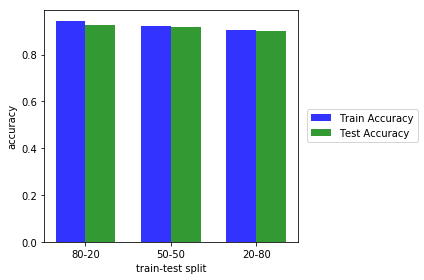

In [100]:
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index,train_acc, bar_width, alpha=opacity, color='b', label='Train Accuracy')
rects2 = plt.bar(index + bar_width,test_acc, bar_width, alpha=opacity, color='g', label='Test Accuracy')

plt.xlabel('train-test split')
plt.ylabel('accuracy')
plt.xticks(index + bar_width/2, ('80-20', '50-50', '20-80', '10-90', '5-95'))
plt.legend(loc='center right', borderaxespad=-12.0)

plt.tight_layout()
plt.show()